In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:390: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729837e+15 2.80000000e+01]
 [1.53729837e+15 2.90000000e+01]
 [1.53729837e+15 2.90000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/690/database


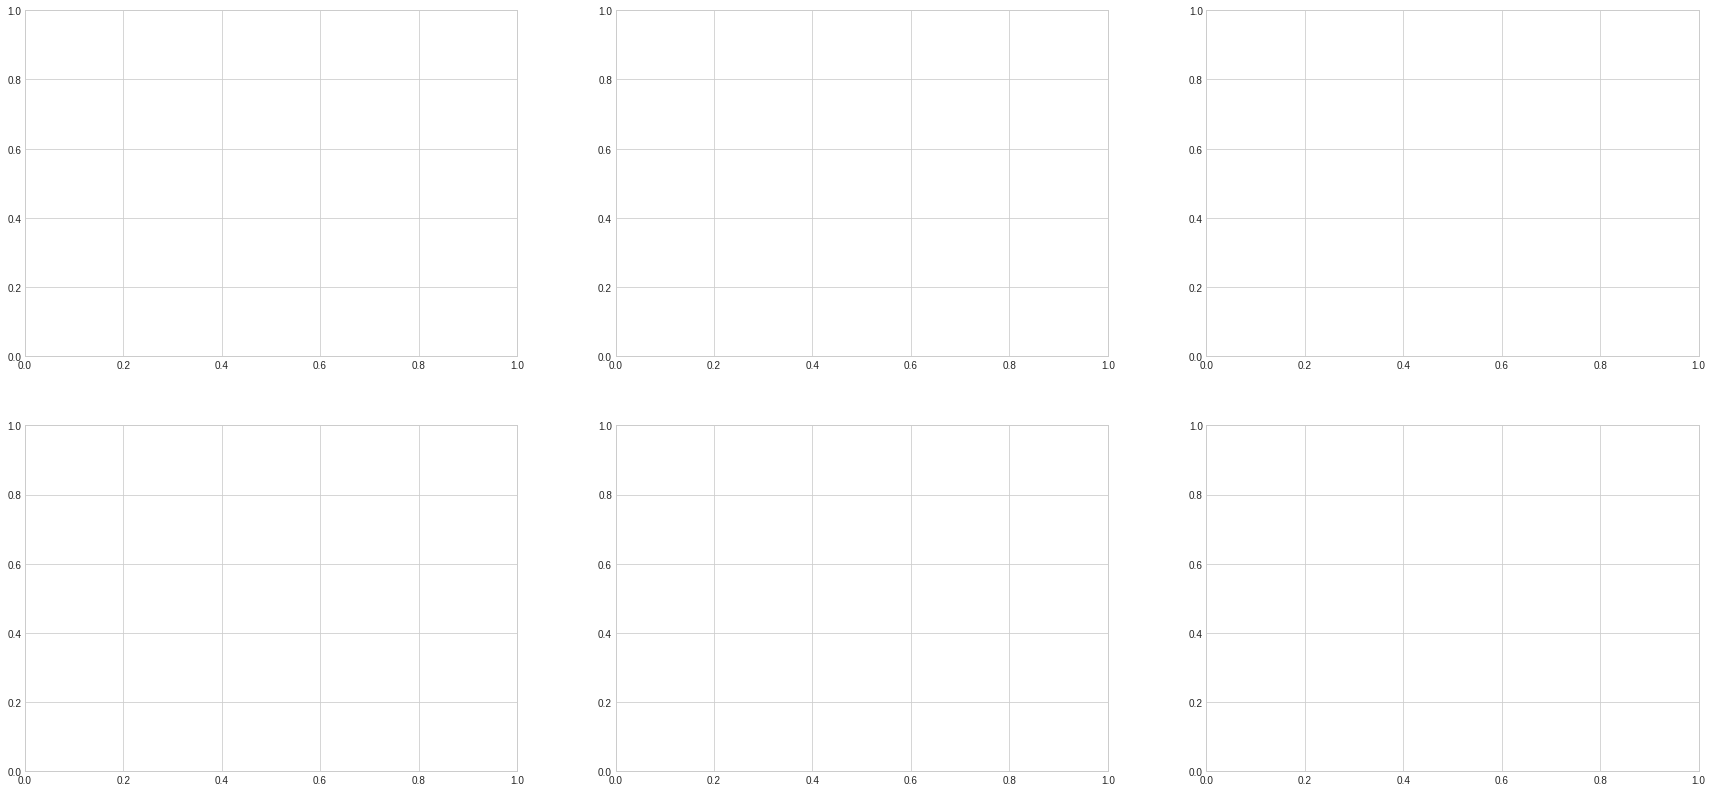

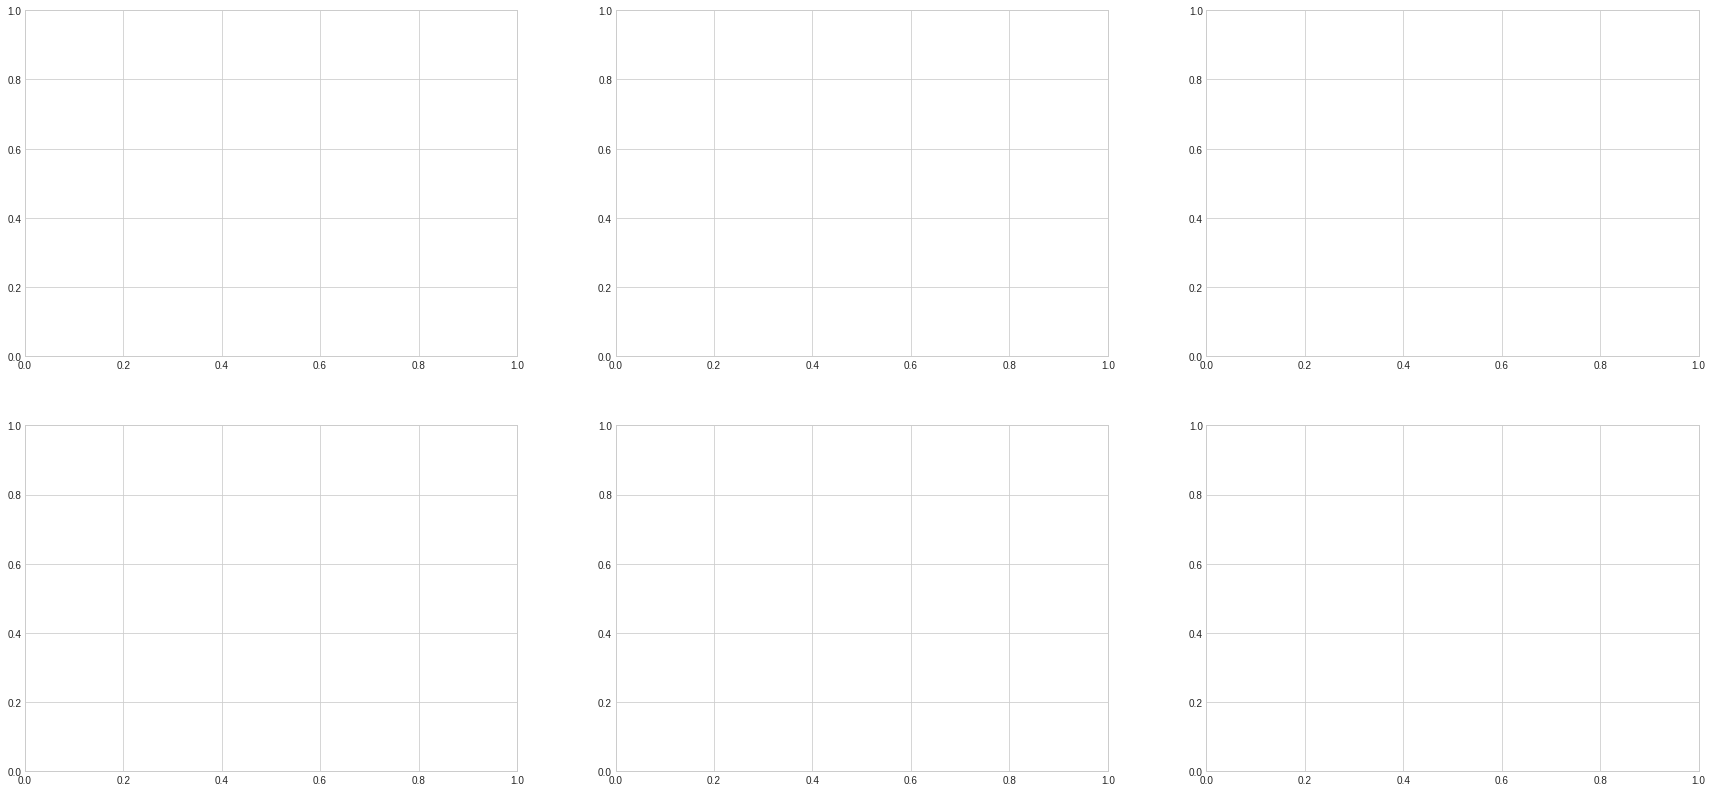

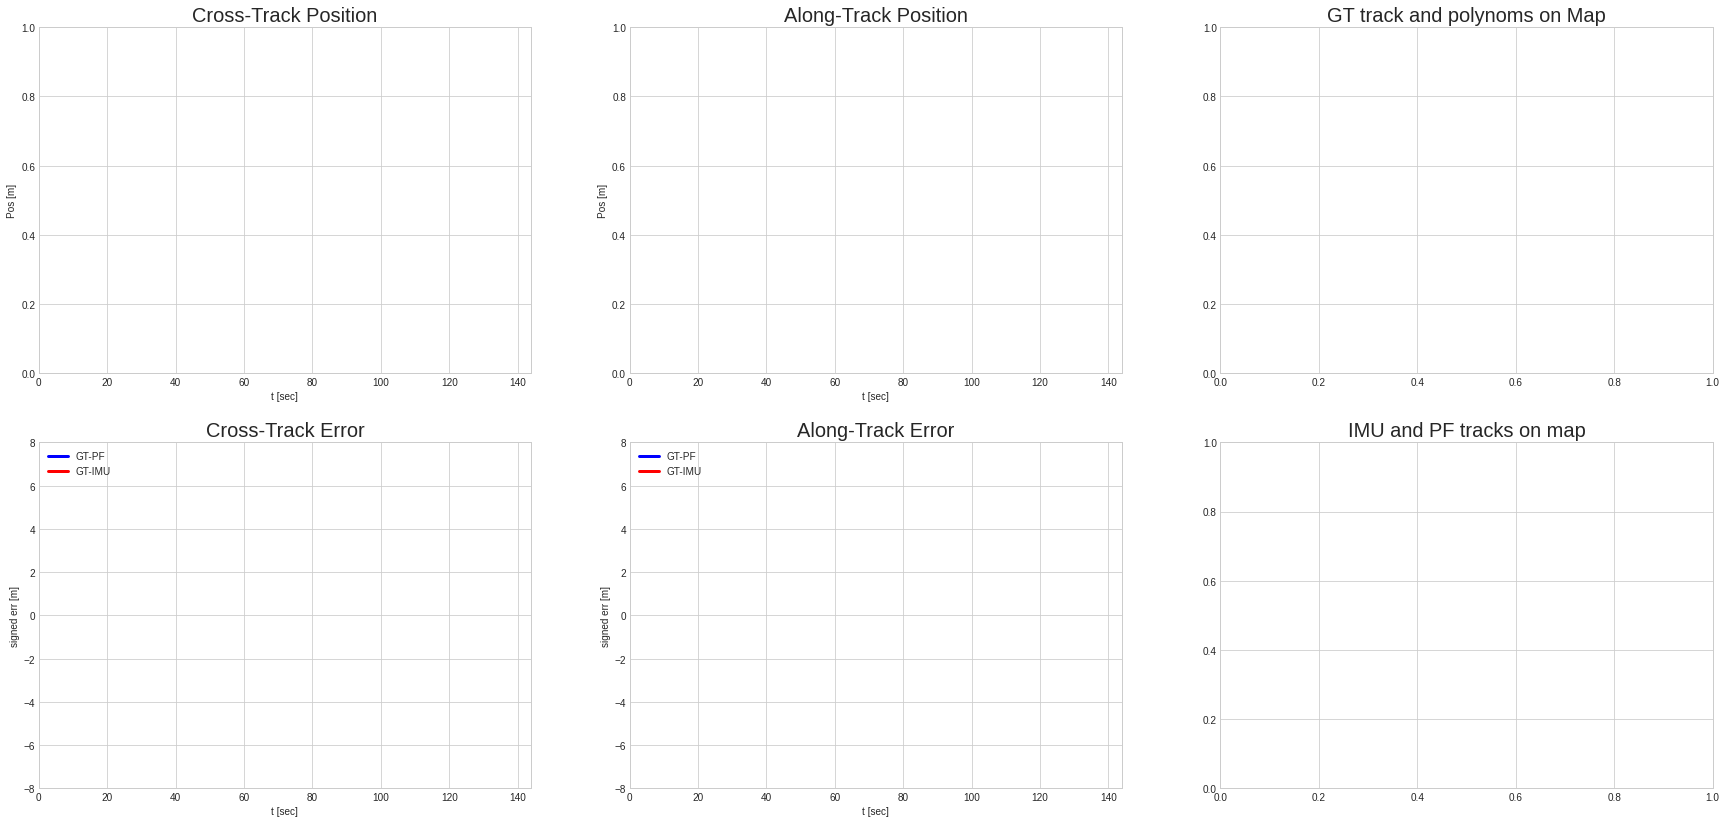

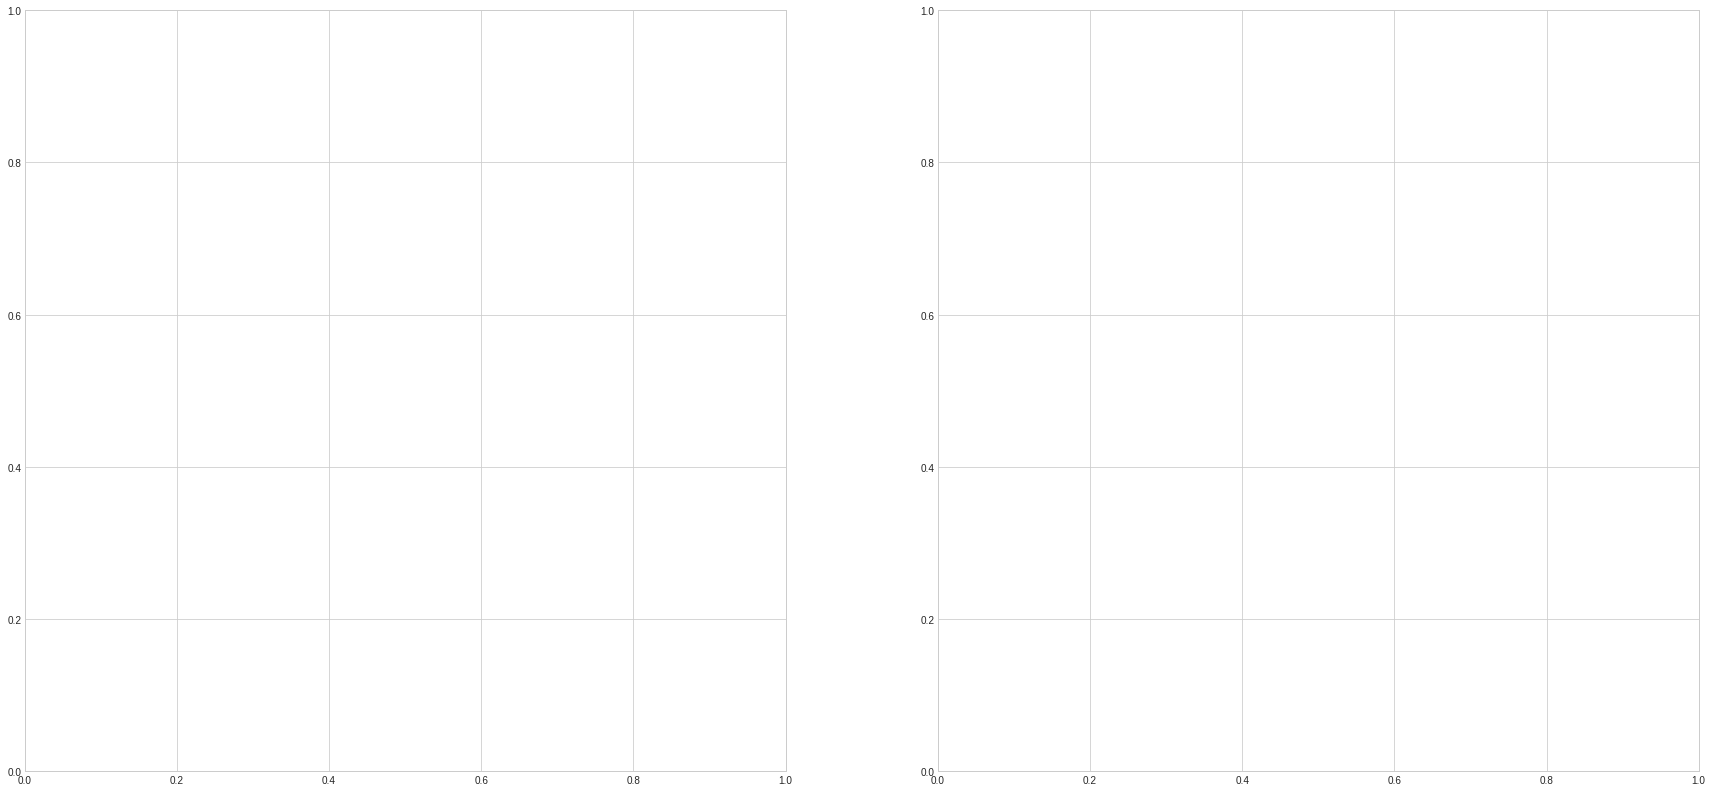

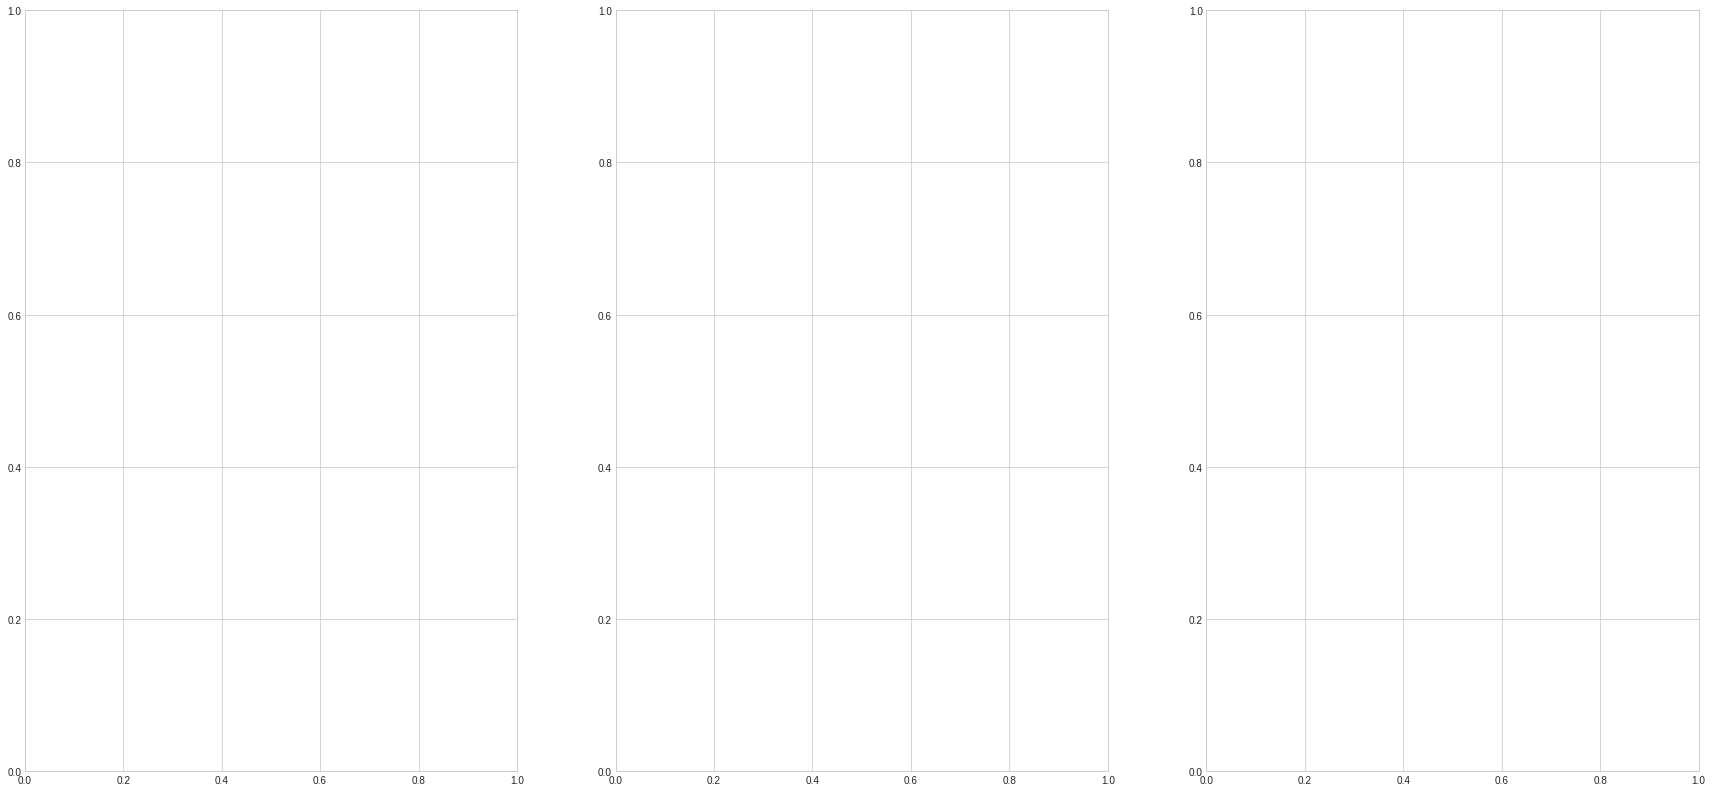

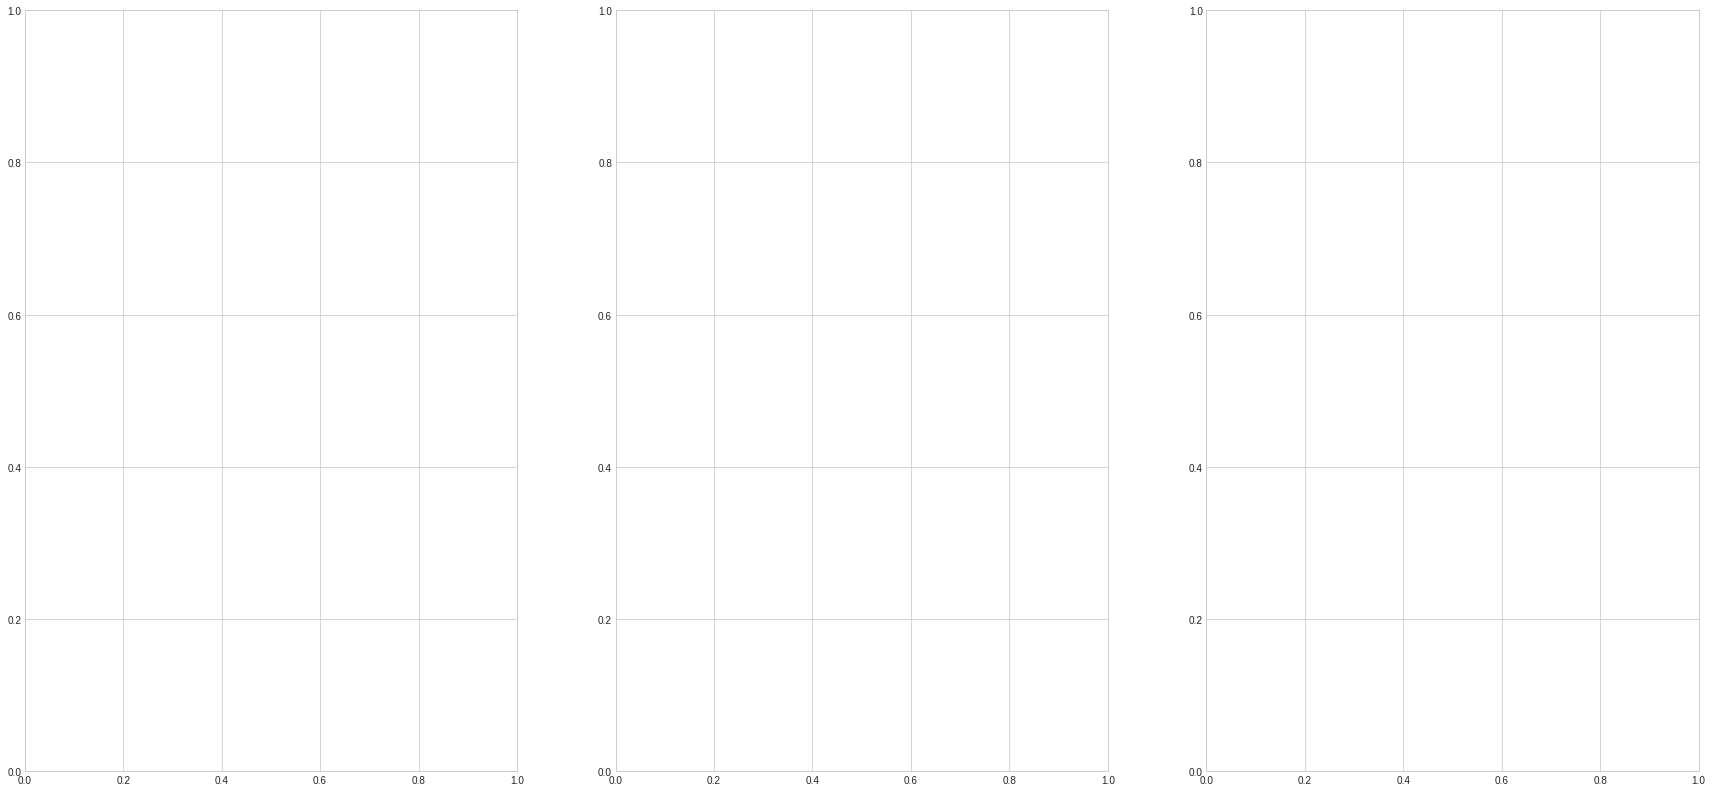

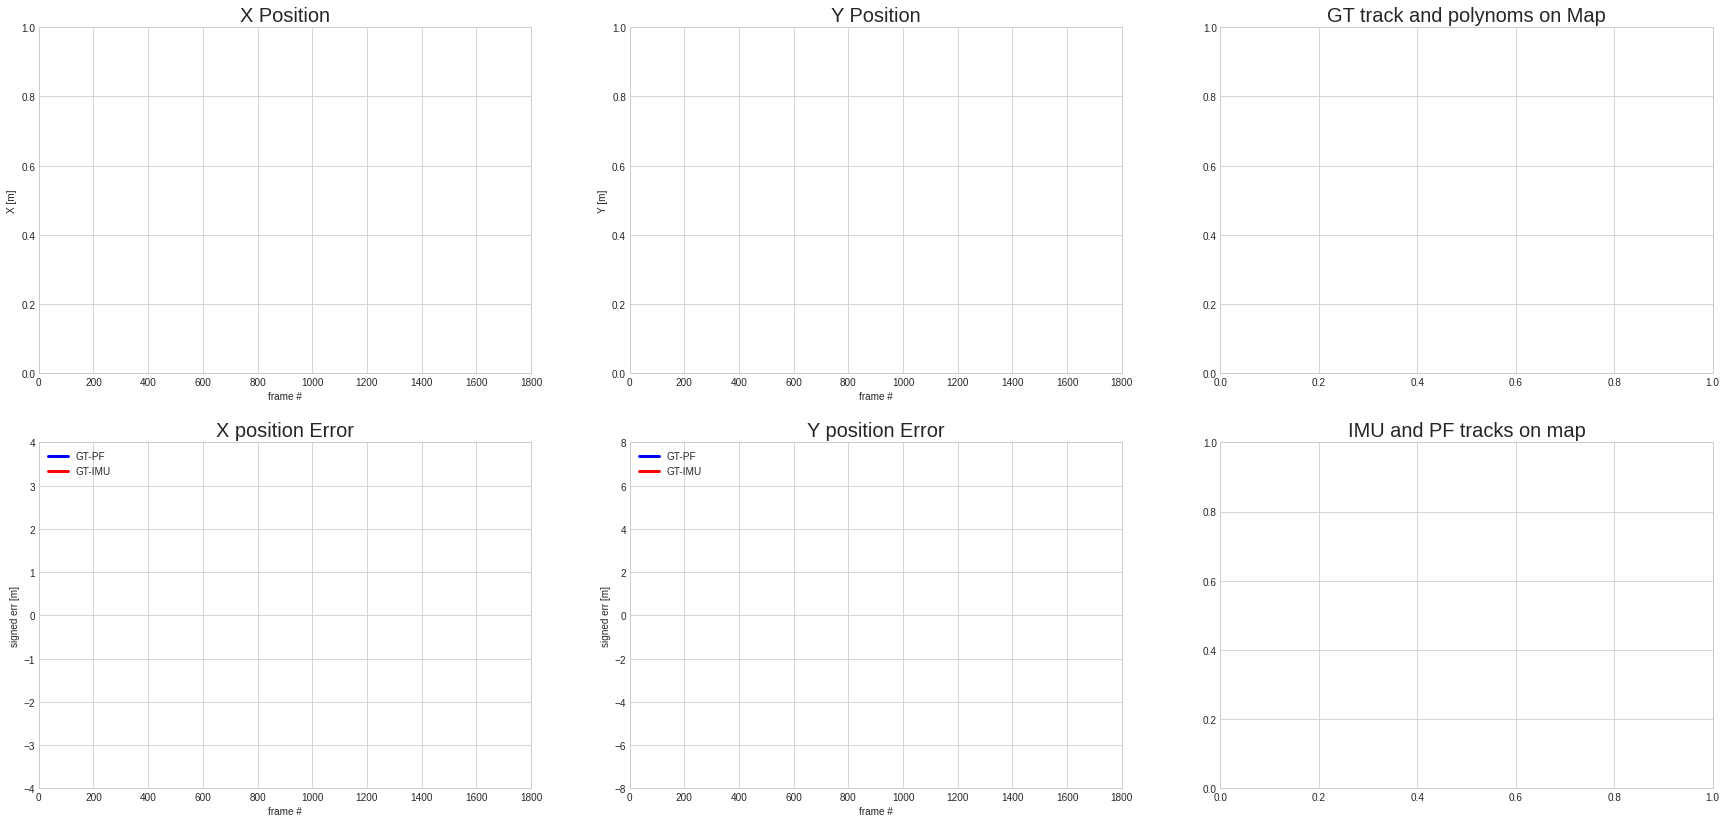

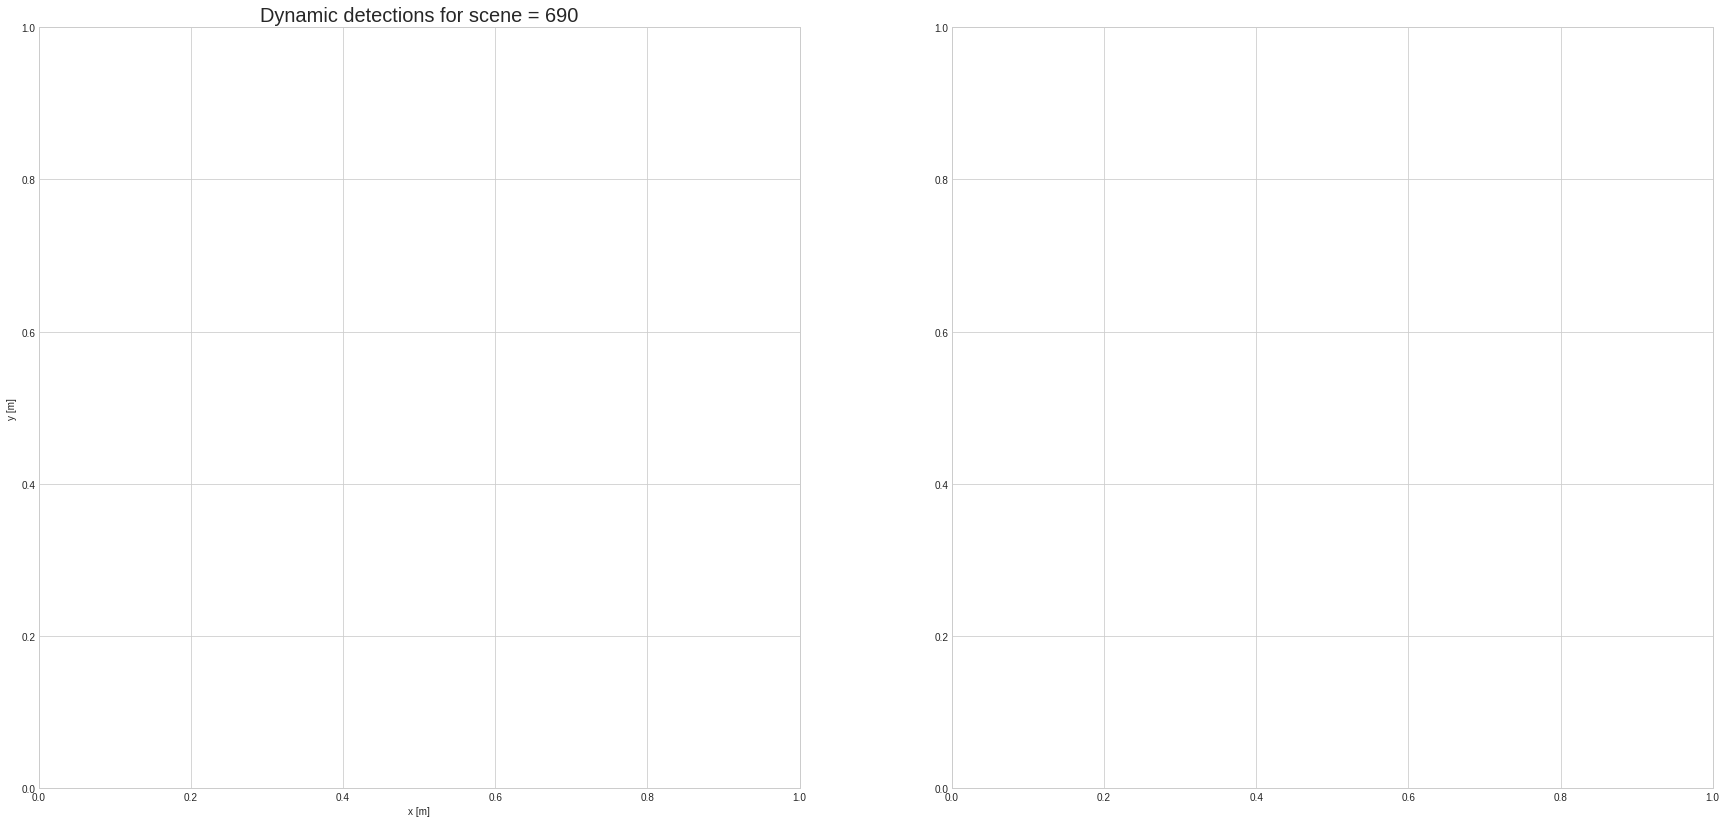

In [30]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation

class DummyModel():
    def __init__(self):
        self.mm = True
        
scene = 690
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1800, video_list=video_list, save_processed=False)

In [3]:
from tqdm import tqdm
import math
from metrics import *

In [7]:
from database import NuscenesProcessedDatabase
from tqdm import tqdm
data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

for t in tqdm(range(0,200)):
    img = sim.dataset.getSyncedImage(t)
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    video_data["img"] = img

    sim.video_list["video"] = False
    sim.video_list["video_debug"] = False
    sim.video_list["video_pf"] = True
    sim.video_list["video_pf_xy"] = False
    sim.video_list["dynamic_tracker"] = False

    sim.drawPlots(t, video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, nusc_map, video_with_priors, translation, debug_info)

self.dir_name images/814/database


  0%|          | 0/200 [00:00<?, ?it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


PF RMSE lateral: 0.011485451677993691
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0


No handles with labels found to put in legend.
  0%|          | 1/200 [00:01<04:07,  1.24s/it]

PF RMSE lateral: 0.04442978281560927
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04783997033288175
IMU RMSE longitudal: 0.0


  1%|          | 2/200 [00:02<03:46,  1.14s/it]

PF RMSE lateral: 0.040533018112826426
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.041299238350159986
IMU RMSE longitudal: 0.0


  2%|▏         | 3/200 [00:03<03:33,  1.08s/it]

PF RMSE lateral: 0.041794218597803544
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.044888767007759255
IMU RMSE longitudal: 0.0


  2%|▏         | 4/200 [00:04<03:25,  1.05s/it]

PF RMSE lateral: 0.04068367717475314
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.042918670726321724
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.3773171938338775, 2.076117806329708] cost_mean [1.46708752631336, 1.0757500963511253]


  2%|▎         | 5/200 [00:05<03:31,  1.09s/it]

PF RMSE lateral: 0.04783491876067411
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05100533206929821
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.387657691769874, 2.0183953765908087, 3.105836320173868] cost_mean [1.3582755182040929, 1.3575263029268332, 1.2209183991395485]


  3%|▎         | 6/200 [00:06<03:38,  1.13s/it]

PF RMSE lateral: 0.052243033552600814
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05761293688613588
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.363333705365351, 1.6874577963831108, 2.5097246208142043, 3.5384720982000673] cost_mean [1.1709998264642738, 1.0697356194338046, 1.6149807896337485, 4.9609942428058]


  4%|▎         | 7/200 [00:07<03:44,  1.16s/it]

PF RMSE lateral: 0.05351841987401182
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05954991795379846
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.2834929947526938, 1.4648540006065, 2.17694292367122, 3.930138050298735, 2.5083924243923694] cost_mean [1.3509584953240035, 1.0041991295842985, 1.1395890463528893, 5.4441092948025105, 2.2546775071402765]


  4%|▍         | 8/200 [00:08<03:50,  1.20s/it]

PF RMSE lateral: 0.06233787817246894
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.06786847412001723
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.3641000913507773, 1.7875356955979875, 2.790969164148314, 4.160960901962932, 18.18973944627923] cost_mean [1.240834954167216, 1.4484258318228183, 1.2195097322168826, 5.749380107444173, 23.239885372642984]


  4%|▍         | 9/200 [00:10<03:54,  1.23s/it]

PF RMSE lateral: 0.06409797310407539
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07000256689453829
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.1386498238849605, 1.5942586742016571, 2.3366257238619417, 3.382523246678127, 13.165495641628125] cost_mean [1.1097916008949, 1.2824371345612124, 0.9718661275171009, 4.528090741004838, 18.267286830434543]


  5%|▌         | 10/200 [00:11<04:00,  1.26s/it]

PF RMSE lateral: 0.07129667219917998
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07556730867377971
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.539958788967468, 1.9013475576916388, 2.9372097020622654, 3.9984868250897363, 16.431130511437246] cost_mean [1.4158717328343695, 1.4910661747907392, 1.2330642562433145, 5.2615764105109255, 18.47516634633067]


  6%|▌         | 11/200 [00:13<04:05,  1.30s/it]

PF RMSE lateral: 0.08196959814197319
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08486318840277148
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.184558227939095, 1.2995811432277746, 2.5190572954767894, 3.376609752580488, 15.213883416535456, 4.490006977556002] cost_mean [1.2094911397614099, 1.1344218276312659, 1.0394658571009923, 4.290481353469713, 18.74602159020456, 11.149456615187846]
n_tracks 1 cost_dyn_true [2.16810574578766] cost_dyn_mean [0.26228908070194745]
abs_vel =[13.73369737]
xlim [1020.0810632559214, 1026.2979836500083] ylim [2619.874251974766, 2629.4402207163153]
abs_vel =[13.73369737]


  6%|▌         | 12/200 [00:14<04:28,  1.43s/it]

PF RMSE lateral: 0.08491753101852817
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08793840642925144
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.2115869768259788, 1.6557532177508034, 1.5916479456445376, 3.714002122573793, 18.86180878237758, 6.79590603002028] cost_mean [1.2508543944860688, 1.0685704546398183, 1.4660919986156185, 4.7206018910309275, 17.68257846992788, 4.509540869400383]
n_tracks 1 cost_dyn_true [2.1806657592543823] cost_dyn_mean [0.31274369479168623]
abs_vel =[13.73492151]
xlim [1018.8620898548647, 1025.699955840084] ylim [2618.1501072129604, 2628.5220888061976]
abs_vel =[13.73492151]


  6%|▋         | 13/200 [00:16<04:48,  1.54s/it]

PF RMSE lateral: 0.09137726142821141
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.09268897733552278
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.3298048773309732, 1.754742338062496, 2.013281415357376, 4.080782216894872, 14.359590189015064, 6.210933687694348] cost_mean [1.412248372822756, 1.0084969804348067, 0.9287500696867342, 5.064905665015962, 15.725698798477284, 3.9781555351546234]
n_tracks 1 cost_dyn_true [2.372310344786498] cost_dyn_mean [0.3787790761623138]
abs_vel =[13.74214659]
xlim [1018.263796038128, 1025.2437574735895] ylim [2617.294653438367, 2627.8191872775337]
abs_vel =[13.74214659]


  7%|▋         | 14/200 [00:18<05:02,  1.63s/it]

PF RMSE lateral: 0.09456441343538098
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0953733551668054
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.1155054645591127, 1.5024676196546665, 2.243466269429503, 3.6658895931836875, 16.84212787700296, 5.075137379156241] cost_mean [1.2369217892606776, 1.1396583076721045, 1.0858898179697025, 4.206338630400868, 23.815163474185127, 5.607274294814778]
n_tracks 1 cost_dyn_true [2.626349054869297] cost_dyn_mean [0.5063334038718952]
abs_vel =[13.75178269]
xlim [1017.7270569483535, 1024.580327060951] ylim [2616.398680927099, 2626.7942150731715]
abs_vel =[13.75178269]


  8%|▊         | 15/200 [00:20<05:13,  1.69s/it]

PF RMSE lateral: 0.10135885514902819
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10103266884027479
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.228136975293645, 1.9063688120338589, 4.405780283276126, 20.802582014551763, 5.308585354501431] cost_mean [1.3041234296274586, 0.9235440888017147, 4.928245822405232, 21.86787705473852, 4.39533465183728]
n_tracks 1 cost_dyn_true [2.4099467636976164] cost_dyn_mean [0.6145416855685808]
abs_vel =[13.76276942]
xlim [1017.1176540107142, 1023.4456432524315] ylim [2615.5147216639043, 2625.0798407597003]
abs_vel =[13.76276942]


  8%|▊         | 16/200 [00:22<05:21,  1.74s/it]

PF RMSE lateral: 0.10397101660955037
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10373936329594802
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.0264405231247329, 3.3700076442016065, 17.558393698809194, 3.8014044486353353, 1.2750257894796238] cost_mean [1.1382621493578753, 3.760929562796971, 19.072853684923235, 4.118559822757667, 1.2739034950585775]
n_tracks 1 cost_dyn_true [2.2506703295382273] cost_dyn_mean [0.7319756253357415]
abs_vel =[13.77354982]
xlim [1016.5876499204924, 1022.9033660311235] ylim [2614.606404032567, 2624.1866400617105]
abs_vel =[13.77354982]


  8%|▊         | 17/200 [00:23<05:27,  1.79s/it]

PF RMSE lateral: 0.10660845039376042
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10688519416009977
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.190786766840492, 17.2600564843738, 7.28891030649697, 1.5935176245989733] cost_mean [1.4792016421436467, 17.554307731988565, 4.863481806203853, 1.1038554159307374]
n_tracks 1 cost_dyn_true [2.6186893247577796] cost_dyn_mean [0.7281488364816742]
abs_vel =[13.77822869]
xlim [1015.3459893124951, 1022.3467975066181] ylim [2612.8572746999735, 2623.3284588681477]
abs_vel =[13.77822869]


  9%|▉         | 18/200 [00:25<05:34,  1.84s/it]

PF RMSE lateral: 0.1117912308996382
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1120037816954809
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.1798534792919688, 20.678540361853393, 7.052439943391476, 1.1176004791975758, 1.9872166303414764] cost_mean [1.3661855770772537, 20.553127166012384, 4.7743510615484865, 1.122289078142104, 2.3614802871950196]
n_tracks 1 cost_dyn_true [3.1466736732876424] cost_dyn_mean [0.8260473508807817]
abs_vel =[13.78062954]
xlim [1014.7367969151859, 1021.8583223879509] ylim [2611.9981216323927, 2622.6266301289984]
abs_vel =[13.78062954]


 10%|▉         | 19/200 [00:27<05:39,  1.87s/it]

PF RMSE lateral: 0.11373381891008641
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11465286549876616
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.1018674810172113, 15.268511561515655, 5.047752491562515, 1.2060549607580633, 2.321430069185284, 0.979274224048679] cost_mean [1.4504480700490006, 15.982825979872302, 5.4440437366278775, 1.3812259898440513, 2.1650781200813567, 2.4673459096963555]
n_tracks 1 cost_dyn_true [3.3423628843045394] cost_dyn_mean [0.8289249083473975]
abs_vel =[13.78225453]
xlim [1014.1225842748378, 1021.1675539780726] ylim [2611.1281375775648, 2621.621439832968]
abs_vel =[13.78225453]


 10%|█         | 20/200 [00:29<05:43,  1.91s/it]

PF RMSE lateral: 0.1159695384442104
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11769921247959857
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.7232231837361869, 15.293442271371198, 4.847182125811604, 1.3764032666805657, 2.2670438434517868, 0.829425269122396, 3.1606079559022096, 0.8586216125795598] cost_mean [1.0127358326545872, 16.227721288146192, 3.9275386686858504, 1.1514599246375528, 2.4334893385745175, 2.5227260717605637, 3.7135616977459858, 0.8073785882212912]
n_tracks 1 cost_dyn_true [3.4335894413929706] cost_dyn_mean [0.9124398770097706]
abs_vel =[13.78390308]
xlim [1013.5260936182032, 1020.5920504001407] ylim [2610.1977297834796, 2620.756942036067]
abs_vel =[13.78390308]


 10%|█         | 21/200 [00:31<05:46,  1.94s/it]

PF RMSE lateral: 0.11810379854906439
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12094728239298315
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.9989161429976349, 12.23677991665609, 3.751477599277923, 1.3272036280525275, 1.8692093459102765, 1.162120604925946, 4.643104739860636, 0.8270718374043766] cost_mean [1.3531153384256913, 13.183663101014295, 3.6887352056893556, 1.1140539010505048, 1.8555075155703176, 2.4394781146222493, 4.988034127970133, 0.8087572555939309]
n_tracks 1 cost_dyn_true [3.5868742793159436] cost_dyn_mean [0.9701177902707439]
abs_vel =[13.78591105]
xlim [1012.9366797327187, 1019.4217594446701] ylim [2609.3497142143674, 2619.0994567665616]
abs_vel =[13.78591105]


 11%|█         | 22/200 [00:33<05:47,  1.95s/it]

PF RMSE lateral: 0.11996478939751863
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12446656374936096
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.8009635357648919, 13.445708126677754, 2.5921362085677795, 1.3798802189991533, 1.8212710762363593, 0.8678488440076998, 3.702935582814234, 0.8298249963144897] cost_mean [1.0407265985774055, 13.936283158853426, 4.145162322898068, 1.1435231336259712, 2.0933280106019856, 2.6922205231134786, 4.184121646519389, 0.683127489205184]
n_tracks 1 cost_dyn_true [3.5950017348084446] cost_dyn_mean [0.9503368268488634]
abs_vel =[13.78815463]
xlim [1012.3479580091423, 1018.8092577242178] ylim [2608.47099305527, 2618.2247192863338]
abs_vel =[13.78815463]


 12%|█▏        | 23/200 [00:35<05:48,  1.97s/it]

PF RMSE lateral: 0.12333101871327744
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1288780804530463
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [0.9309488586549411, 22.006122538061053, 7.523508366719933, 1.4854334752089957, 2.1373476281331083, 0.9509958189092854, 4.284294390902243, 0.7730773410847613] cost_mean [1.365851541815295, 21.075249182219885, 5.463997704730187, 0.9239051401267612, 2.239708935016596, 2.539815616625713, 4.386152639441083, 0.6861927859308954]
n_tracks 1 cost_dyn_true [3.4498319475263965] cost_dyn_mean [0.9632349089181356]
abs_vel =[13.79238846]
xlim [1011.1071750852931, 1018.3074050057998] ylim [2606.674291904017, 2617.4118805337675]
abs_vel =[13.79238846]


 12%|█▏        | 24/200 [00:37<05:49,  1.99s/it]

PF RMSE lateral: 0.12880825931874826
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.13468091349992015
IMU RMSE longitudal: 0.0
n_polynoms 9 cost_true [0.8337260820101783, 14.35083737477819, 5.3920098122006355, 1.3257383847189035, 2.1376018509927808, 0.9340532270339711, 4.101695286159587, 0.8401159264627502, 2.8911983387359266] cost_mean [1.2527246006810178, 16.28510700728481, 4.352652883338801, 1.0488744449984126, 2.3634612721298973, 2.4745091228726674, 4.390365342663876, 0.7303193977515706, 2.378313288121178]
n_tracks 1 cost_dyn_true [3.5303898623687253] cost_dyn_mean [1.0061502916478076]
abs_vel =[13.79763075]
xlim [1010.5116755297191, 1017.6651604200545] ylim [2605.8173570777303, 2616.4802502090924]
abs_vel =[13.79763075]


 12%|█▎        | 25/200 [00:39<05:52,  2.01s/it]

PF RMSE lateral: 0.1329654526903562
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.13948278296949262
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [12.719153006425183, 4.265831940324689, 1.1256344495522765, 2.812692985949969, 1.0689771333917302, 3.1917555334987195, 0.7588405561739819, 2.630104901261899] cost_mean [15.361127104839879, 3.922259319200575, 1.2000477861868935, 2.9612801945971796, 2.473779084149782, 3.8058944600139712, 0.6432774028603542, 1.8533558358467255]
n_tracks 1 cost_dyn_true [3.49185756937523] cost_dyn_mean [1.0137685197812791]
abs_vel =[13.80229135]
xlim [1009.9036045455668, 1017.1679559383834] ylim [2604.963198405728, 2615.6140443279737]
abs_vel =[13.80229135]


 13%|█▎        | 26/200 [00:42<05:53,  2.03s/it]

PF RMSE lateral: 0.13635499828320688
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.14368633855910004
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [4.849871887591333, 1.6506257723533222, 1.970573561051882, 0.9648803227510375, 4.598850322018088, 0.7072389772221935, 2.8862719445725102] cost_mean [3.6735079254212706, 1.0672970763507388, 2.1413379765330327, 2.583576025974488, 4.4060920469798095, 0.8724376179743881, 2.8825405482266078]
n_tracks 1 cost_dyn_true [3.5071081646308313] cost_dyn_mean [1.0307109552923892]
abs_vel =[13.80545897]
xlim [1009.3575826161823, 1015.8843323603855] ylim [2604.1427493985357, 2613.801817187257]
abs_vel =[13.80545897]


 14%|█▎        | 27/200 [00:44<05:55,  2.05s/it]

PF RMSE lateral: 0.1397592028904031
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.14811503400654125
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.8530112138600145, 1.2210148368520541, 3.597711113833841, 0.8307294895541151, 2.967887511704786] cost_mean [1.8841096124362213, 2.8857968624068606, 3.55855472221561, 0.80243823329151, 2.28092606115229]
n_tracks 1 cost_dyn_true [3.656376323821765] cost_dyn_mean [1.0881039276581994]
abs_vel =[13.80823613]
xlim [1008.7955582959207, 1015.2663167847091] ylim [2603.2530939469493, 2612.932358243765]
abs_vel =[13.80823613]


 14%|█▍        | 28/200 [00:46<05:58,  2.08s/it]

PF RMSE lateral: 0.14355883920607385
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1533229692520851
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.4159151080253904, 0.9635159640918963, 4.310409140898956, 0.8753962251352492, 3.33482881390234, 1.1168878551054144] cost_mean [2.598516601124453, 2.468585997804372, 3.8979507975155037, 0.8914912733252286, 2.800991789037107, 1.189973674541572]
n_tracks 1 cost_dyn_true [3.5317809558183364] cost_dyn_mean [1.0634847908049871]
abs_vel =[13.81262189]
xlim [1007.5266915859394, 1014.7263252990056] ylim [2601.4549831640384, 2612.200836184458]
abs_vel =[13.81262189]


 14%|█▍        | 29/200 [00:48<06:00,  2.11s/it]

PF RMSE lateral: 0.1490139433593001
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1602379932959738
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [0.8704090162606497, 4.015459659871765, 0.7697409411797881, 2.859409852509281, 1.0294944312203826, 2.3125198145602384] cost_mean [2.573015019474245, 4.380878822979458, 0.747727612762306, 2.122282255263706, 1.246326961852931, 0.8692457938752887]
n_tracks 1 cost_dyn_true [3.551122458472683] cost_dyn_mean [1.0904365931876614]
abs_vel =[13.81791364]
xlim [1006.9201861145101, 1014.1392564846271] ylim [2600.567166932865, 2611.3010937772283]
abs_vel =[13.81791364]


 15%|█▌        | 30/200 [00:50<06:02,  2.13s/it]

PF RMSE lateral: 0.1532024803636758
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.16595499118225054
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [4.690011220865657, 0.7603808967880936, 2.7639254910138296, 1.1442209296869308, 1.8354845753739701] cost_mean [4.446975918272377, 0.6981327695468083, 2.1184916719792044, 1.0072195458637083, 0.7052901945507687]
n_tracks 1 cost_dyn_true [3.5014521066450284] cost_dyn_mean [1.084850540500627]
abs_vel =[13.82174194]
xlim [1006.3116768091215, 1013.5129233805193] ylim [2599.7104881563046, 2610.4005501254787]
abs_vel =[13.82174194]


 16%|█▌        | 31/200 [00:52<06:04,  2.16s/it]

PF RMSE lateral: 0.1579635668427483
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1728614812296988
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.366150770403107, 1.2397342472972654, 1.8508725386076945, 1.087533210907221] cost_mean [1.8123877977222789, 1.1545664142832421, 0.8197716188114569, 3.042386334530734]
n_tracks 1 cost_dyn_true [3.460702703163399] cost_dyn_mean [1.0369528712114398]
abs_vel =[13.825706]
xlim [1005.676194322226, 1012.9360676529884] ylim [2598.8058552522257, 2609.543209068576]
abs_vel =[13.825706]


 16%|█▌        | 32/200 [00:55<06:07,  2.18s/it]

PF RMSE lateral: 0.16164700559297437
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1790212645335932
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [3.1133828958727054, 1.205457264201143, 1.7835328788572786, 0.8476773182781978] cost_mean [2.702417143580087, 0.8787763507412765, 0.8067034879599716, 2.4912495881935897]
n_tracks 1 cost_dyn_true [3.563480667009613] cost_dyn_mean [1.0608433019533365]
abs_vel =[13.82971201]
xlim [1005.1419050700893, 1011.6830550863112] ylim [2597.973161462527, 2607.712740765017]
abs_vel =[13.82971201]


 16%|█▋        | 33/200 [00:57<06:08,  2.21s/it]

PF RMSE lateral: 0.165292624580426
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.18517426847758753
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.7235438669955565, 1.1529845410986785, 2.04480888087739, 1.2085359591273177] cost_mean [2.160737629374666, 1.3119225903273917, 0.80837078601471, 2.3789533044995395]
n_tracks 1 cost_dyn_true [3.811828284148075] cost_dyn_mean [1.1684322638562317]
abs_vel =[13.83413001]
xlim [1004.5591670544263, 1011.0493127286425] ylim [2596.9845845131304, 2606.8062736016423]
abs_vel =[13.83413001]


 17%|█▋        | 34/200 [00:59<06:11,  2.24s/it]

PF RMSE lateral: 0.16917702217493347
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.19178003182326753
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [3.184573028653687, 1.153048905387326, 1.6885234044775823, 0.9038482522843437] cost_mean [2.8277813385902677, 1.0398900238773467, 0.8474228943509339, 2.415325082880609]
n_tracks 1 cost_dyn_true [3.745370348624176] cost_dyn_mean [1.2635318194962168]
abs_vel =[13.83723442]
xlim [1003.3141561992853, 1010.4783252286709] ylim [2595.2154514516556, 2606.0268603924674]
abs_vel =[13.83723442]


 18%|█▊        | 35/200 [01:02<06:16,  2.28s/it]

PF RMSE lateral: 0.17321311817504567
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.19864710481174766
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.125896527780534, 2.006155719954768, 0.9258214541367629] cost_mean [1.1558021946622183, 0.8901710097730358, 2.4684031854095982]
n_tracks 1 cost_dyn_true [3.812945099548174] cost_dyn_mean [1.2722057159279467]
abs_vel =[13.84055775]
xlim [1002.755162752552, 1009.9464736707295] ylim [2594.3972237872877, 2605.2302515419788]
abs_vel =[13.84055775]


 18%|█▊        | 36/200 [01:04<06:26,  2.36s/it]

PF RMSE lateral: 0.17720111768693472
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2055564439011234
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.1351614726750694, 1.4869616149289842, 0.9456604690258041, 2.367683666820124] cost_mean [0.9699402582860437, 0.7261638792541302, 2.50892424440813, 2.2113530772592696]
n_tracks 1 cost_dyn_true [3.8302155437936394] cost_dyn_mean [1.271792079501036]
abs_vel =[13.84460335]
xlim [1002.1215695017972, 1009.3691341888423] ylim [2593.4724264079146, 2604.3234950579417]
abs_vel =[13.84460335]


 18%|█▊        | 37/200 [01:07<06:59,  2.57s/it]

PF RMSE lateral: 0.17946740663301045
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.21117445971233284
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0514973547742883, 2.1372651146160644, 1.0963133634794744, 2.0955977317639047] cost_mean [0.9849458248701216, 0.28848507617326224, 2.3880626006477477, 1.6639860246874325]
n_tracks 1 cost_dyn_true [4.016744171274695] cost_dyn_mean [1.2771838011298131]
abs_vel =[13.84947803]
xlim [1001.5833056801781, 1008.0651240891265] ylim [2592.619814156705, 2602.452078776274]
abs_vel =[13.84947803]


 19%|█▉        | 38/200 [01:10<07:22,  2.73s/it]

PF RMSE lateral: 0.18314314893950728
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.21808918259809235
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9247148806134351, 1.4539192454679108, 0.9081802667475339, 3.012545800285995] cost_mean [0.887218010775023, 0.8169701470870805, 2.3786735307997064, 2.4596194580479436]
n_tracks 1 cost_dyn_true [4.001675062852861] cost_dyn_mean [1.308426197911178]
abs_vel =[13.85540588]
xlim [1000.9642601158455, 1007.4740130963103] ylim [2591.7316318023004, 2601.579933634973]
abs_vel =[13.85540588]


 20%|█▉        | 39/200 [01:13<07:37,  2.84s/it]

PF RMSE lateral: 0.18865174081084932
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.22689254388609498
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.4539740772084453, 1.0694264265853903, 2.2528177281450947] cost_mean [0.8426159311074474, 2.506408581860267, 2.007264737072843]
n_tracks 1 cost_dyn_true [3.8691425985772208] cost_dyn_mean [1.3120945372098882]
abs_vel =[13.860201]
xlim [999.7510976096752, 1006.9694156956135] ylim [2589.9669498569906, 2600.889477325553]
abs_vel =[13.860201]


 20%|██        | 40/200 [01:17<07:50,  2.94s/it]

PF RMSE lateral: 0.19045659089103592
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.23288534677315656
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.2153058407276853, 2.455548642939005] cost_mean [2.391095535712606, 2.2407852165903837]
n_tracks 1 cost_dyn_true [3.8967445402079512] cost_dyn_mean [1.3058325445740908]
abs_vel =[13.86477096]
xlim [999.1024076903745, 1006.1977681650219] ylim [2589.033661087278, 2599.785963944803]
abs_vel =[13.86477096]


 20%|██        | 41/200 [01:19<07:41,  2.90s/it]

PF RMSE lateral: 0.1923004710872422
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.23913258142231808
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.4679145736080805, 1.7412373111698005] cost_mean [2.4747176715783756, 1.4836325164221682]
n_tracks 1 cost_dyn_true [3.8682622276532674] cost_dyn_mean [1.2598193264682547]
abs_vel =[13.86948701]
xlim [998.4779426868802, 1005.6875672479499] ylim [2588.137885896705, 2598.9772610015007]
abs_vel =[13.86948701]


 21%|██        | 42/200 [01:22<07:25,  2.82s/it]

PF RMSE lateral: 0.19507293329638417
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.24653759957002322
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.5061211855643872, 1.1374978475952704] cost_mean [2.0453819535272117, 1.0055020996339217]
n_tracks 1 cost_dyn_true [3.866997771176506] cost_dyn_mean [1.1938430573924161]
abs_vel =[13.87449341]
xlim [997.8747807880287, 1005.1440942713346] ylim [2587.2478885930573, 2598.0541194208445]
abs_vel =[13.87449341]


 22%|██▏       | 43/200 [01:25<07:15,  2.77s/it]

PF RMSE lateral: 0.1965609086458483
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2529725468501443
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.0659025347461686, 1.192182392369738, 2.6494302339932085] cost_mean [1.7731891482931876, 0.965348335458593, 2.4455778707933513]
n_tracks 1 cost_dyn_true [3.9091049426091042] cost_dyn_mean [1.162479340446152]
abs_vel =[13.87982188]
xlim [997.3064238114799, 1003.8849488543768] ylim [2586.3949898332307, 2596.241173099707]
abs_vel =[13.87982188]


 22%|██▏       | 44/200 [01:27<07:09,  2.75s/it]

PF RMSE lateral: 0.19906521006932362
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2604102587690686
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.4162233087731686, 0.7970138491268745, 2.6211327297354385] cost_mean [1.3222042243462688, 0.8491175718915132, 1.9613312984600952]
n_tracks 1 cost_dyn_true [3.9372672915408353] cost_dyn_mean [1.2043885816773212]
abs_vel =[13.88549866]
xlim [996.6940462656718, 1003.3454245255293] ylim [2585.4884200080924, 2595.4616108019422]
abs_vel =[13.88549866]


 22%|██▎       | 45/200 [01:30<07:02,  2.73s/it]

PF RMSE lateral: 0.20137570978034042
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.26802474540436433
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.8616203751447582, 0.8485948095802541, 2.441651800087954, 2.644091098045991] cost_mean [1.7862910537780263, 0.7734288558672062, 2.4151291156860832, 1.2445072067316314]
n_tracks 1 cost_dyn_true [3.8087887906141087] cost_dyn_mean [1.2195478692091215]
abs_vel =[13.89231873]
xlim [995.4437905481988, 1002.7105283695305] ylim [2583.6627766180027, 2594.5642425565597]
abs_vel =[13.89231873]


 23%|██▎       | 46/200 [01:33<07:01,  2.74s/it]

PF RMSE lateral: 0.20291797301639708
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.274685795677382
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6866336298739149, 0.9397641012908761, 2.5397058838602518, 2.4568988578832713, 1.026830524214253] cost_mean [1.6777447654425384, 0.8032112040445675, 2.5582401296515753, 1.433016119699887, 1.4958308785578291]
n_tracks 1 cost_dyn_true [4.011628008927855] cost_dyn_mean [1.2287281948850808]
abs_vel =[13.89979373]
xlim [994.8036545609796, 1002.1534163432925] ylim [2582.7196741659723, 2593.687511340524]
abs_vel =[13.89979373]


 24%|██▎       | 47/200 [01:36<06:57,  2.73s/it]

PF RMSE lateral: 0.2048984735847771
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.28207996117377393
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8749572899112075, 2.675691582811354, 2.4533628146912188, 1.2898625644507213] cost_mean [0.9676320915203052, 2.160915557176139, 1.2248849538370872, 1.4843821332908178]
n_tracks 1 cost_dyn_true [3.997193184346671] cost_dyn_mean [1.208364317650192]
abs_vel =[13.90709396]
xlim [994.1968374733049, 1001.5299126242526] ylim [2581.8305766079425, 2592.7814125394593]
abs_vel =[13.90709396]


 24%|██▍       | 48/200 [01:38<07:00,  2.77s/it]

PF RMSE lateral: 0.20566326908925514
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.28870504312504297
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0796230157638695, 2.631287622951807, 2.056810076663334, 1.2903216730325355] cost_mean [1.0123823841283033, 1.5685601966624025, 1.1266240552437357, 1.5557058132570458]
n_tracks 1 cost_dyn_true [3.862697391002786] cost_dyn_mean [1.1978374623917691]
abs_vel =[13.91412377]
xlim [993.6108279764144, 1000.217053725124] ylim [2581.000474547081, 2590.8748572638992]
abs_vel =[13.91412377]


 24%|██▍       | 49/200 [01:41<06:58,  2.77s/it]

PF RMSE lateral: 0.2071258593715645
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.29588595184054767
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9855695473790603, 2.585091735389433, 2.39927607745453, 1.196015576570688] cost_mean [0.817527988746231, 2.4378366578376984, 1.0567516150463818, 1.8500584331704495]
n_tracks 1 cost_dyn_true [3.7797538709688716] cost_dyn_mean [1.1708182737626482]
abs_vel =[13.92087955]
xlim [992.9691905393332, 999.6985812812914] ylim [2580.1155834243627, 2590.1309752494262]
abs_vel =[13.92087955]


 25%|██▌       | 50/200 [01:44<06:57,  2.79s/it]

PF RMSE lateral: 0.20795317872182642
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.30269121983876485
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9603253913731913, 2.571710160727633, 2.4217131113692667, 1.3798946323890366] cost_mean [1.1994886911213274, 1.9951020968970974, 1.016627340310402, 1.6062082892945446]
n_tracks 1 cost_dyn_true [3.6681412023426043] cost_dyn_mean [1.1135561130600138]
abs_vel =[13.92754059]
xlim [992.3338540123156, 999.0257025048115] ylim [2579.2469935379468, 2589.1693011317834]
abs_vel =[13.92754059]


 26%|██▌       | 51/200 [01:47<06:58,  2.81s/it]

PF RMSE lateral: 0.2086357848085721
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3097568725354483
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8167312754155168, 3.0719230539342957, 2.5375536623021233, 1.0896505007337944] cost_mean [0.9249726084594087, 1.8903564338613728, 1.222219600626535, 1.736205033589382]
n_tracks 1 cost_dyn_true [3.4092304157279667] cost_dyn_mean [1.0741580795157943]
abs_vel =[13.93443489]
xlim [991.0580239341476, 998.389783329718] ylim [2577.4192889045084, 2588.2435339866943]
abs_vel =[13.93443489]


 26%|██▌       | 52/200 [01:50<06:59,  2.83s/it]

PF RMSE lateral: 0.2097451868022011
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.31726234850180157
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9371817635458777, 2.391527031215894, 2.359534074022128, 1.1716588723639698] cost_mean [0.7603702271460864, 1.4830381714827208, 1.2670614145208745, 1.4665164604985672]
n_tracks 1 cost_dyn_true [3.448605090962853] cost_dyn_mean [1.037427932839039]
abs_vel =[13.94136726]
xlim [990.4093643436091, 997.8537451581394] ylim [2576.509407629644, 2587.4442238956017]
abs_vel =[13.94136726]


 26%|██▋       | 53/200 [01:53<07:03,  2.88s/it]

PF RMSE lateral: 0.21025677825719405
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.324133411283853
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.548006483646471, 2.3299302421099397, 1.1549619542746605] cost_mean [2.3502467887611, 1.253813658095799, 1.7169208518997223]
n_tracks 1 cost_dyn_true [3.452083869043948] cost_dyn_mean [1.002479176793846]
abs_vel =[13.94839412]
xlim [989.7474681710966, 997.170402811733] ylim [2575.5762078691946, 2586.4272929549825]
abs_vel =[13.94839412]


 27%|██▋       | 54/200 [01:56<06:59,  2.88s/it]

PF RMSE lateral: 0.2114905575034498
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3317774138754097
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.9665082642503457, 1.1227315244981662] cost_mean [1.1101296660876088, 1.723884477826555]
n_tracks 1 cost_dyn_true [3.2761485605587657] cost_dyn_mean [0.9601722724748462]
abs_vel =[13.95503221]
xlim [989.1113370028133, 995.975559206046] ylim [2574.7593182449536, 2584.6688293402663]
abs_vel =[13.95503221]


 28%|██▊       | 55/200 [01:59<06:58,  2.89s/it]

PF RMSE lateral: 0.21261471417742098
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3392605115242491
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.2309901825201677, 1.2296310826411678] cost_mean [1.1274078924748723, 1.7455297804125014]
n_tracks 1 cost_dyn_true [3.0667817877742656] cost_dyn_mean [0.940164568395019]
abs_vel =[13.96138731]
xlim [988.4069948982932, 995.3684347096233] ylim [2573.821636320265, 2583.77335891308]
abs_vel =[13.96138731]


 28%|██▊       | 56/200 [02:01<06:56,  2.89s/it]

PF RMSE lateral: 0.21398271569438782
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3469920399406919
IMU RMSE longitudal: 0.0
n_polynoms 1 cost_true [1.0132899369863486] cost_mean [1.619293769041782]
n_tracks 1 cost_dyn_true [2.8521086800504882] cost_dyn_mean [0.8867294296290307]
abs_vel =[13.96722365]
xlim [987.1128476220083, 994.7442613474725] ylim [2572.0151727341126, 2582.8766011161665]
abs_vel =[13.96722365]


 28%|██▊       | 57/200 [02:04<07:00,  2.94s/it]

PF RMSE lateral: 0.21457957867478059
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.35426856773336046
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.721138842834062, 0.9447850718423385] cost_mean [1.7920169549831524, 0.7708040268550141]
n_tracks 1 cost_dyn_true [2.9031390477568246] cost_dyn_mean [0.8457946005868004]
abs_vel =[13.97268899]
xlim [986.4686897847764, 994.145843745101] ylim [2571.136786853545, 2582.0137886629423]
abs_vel =[13.97268899]


 29%|██▉       | 58/200 [02:07<06:59,  2.95s/it]

PF RMSE lateral: 0.2154685538316001
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3619345189414231
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.5929690244321852, 0.8155323294143014, 1.132046437103686] cost_mean [1.5355199307478058, 0.7385882885439154, 1.952686291616246]
n_tracks 1 cost_dyn_true [2.8680466693692432] cost_dyn_mean [0.8068843759497464]
abs_vel =[13.97777766]
xlim [985.861882577657, 993.4974516214216] ylim [2570.2408142621907, 2581.129424101102]
abs_vel =[13.97777766]


 30%|██▉       | 59/200 [02:10<06:59,  2.97s/it]

PF RMSE lateral: 0.2157932066839768
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.36910945366160824
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.6630168686485076, 0.859763935950675, 1.03327666255891] cost_mean [1.5895792605010104, 0.8428627711965315, 1.742788475265036]
n_tracks 1 cost_dyn_true [2.7685188383234403] cost_dyn_mean [0.7628015447625311]
abs_vel =[13.98271134]
xlim [985.1867578862467, 992.8161815798591] ylim [2569.33221880477, 2580.192020368357]
abs_vel =[13.98271134]


 30%|███       | 60/200 [02:14<07:01,  3.01s/it]

PF RMSE lateral: 0.2159900969028643
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.37618824923169264
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.5658766698615696, 0.7858726902170993, 1.0662463021675839] cost_mean [1.8167875325669356, 0.8235719215467241, 1.7681265726146325]
n_tracks 1 cost_dyn_true [2.780842151751063] cost_dyn_mean [0.7291044631202771]
abs_vel =[13.98756961]
xlim [984.5714709964233, 991.6034965858641] ylim [2568.430125409895, 2578.4181567262754]
abs_vel =[13.98756961]


 30%|███       | 61/200 [02:17<07:02,  3.04s/it]

PF RMSE lateral: 0.21616983186815106
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.382921274312901
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.481731606905373, 0.7776102144058398, 1.071982178831901, 0.8952908536587597] cost_mean [1.5857509536949987, 0.8666255108225394, 1.441358317988692, 0.8560498343366423]
n_tracks 1 cost_dyn_true [2.8126754237976686] cost_dyn_mean [0.719557049921175]
abs_vel =[13.9922532]
xlim [983.941807193347, 990.8853256311485] ylim [2567.501292926864, 2577.3968665119214]
abs_vel =[13.9922532]


 31%|███       | 62/200 [02:20<07:03,  3.07s/it]

PF RMSE lateral: 0.21677995948468243
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3902312040657457
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.629530906102468, 0.8527736807016987, 1.1587600029747946, 0.8064093761465961] cost_mean [1.637998389415523, 0.8113529677390535, 1.8263848249461352, 0.7189401982725501]
n_tracks 1 cost_dyn_true [2.6632135095796245] cost_dyn_mean [0.6861209155106267]
abs_vel =[13.99656457]
xlim [982.687709516031, 990.2714913503694] ylim [2565.6714049125167, 2576.5742716190357]
abs_vel =[13.99656457]


 32%|███▏      | 63/200 [02:23<07:03,  3.09s/it]

PF RMSE lateral: 0.21766491277465616
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3977166598659051
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.5992574933539574, 0.867491685449194, 1.2805547883001798, 0.8821160641866962, 1.3300347663199679] cost_mean [1.6741435325712495, 0.7927373068796989, 1.7146528672147414, 0.8600575356380586, 2.3189982460558385]
n_tracks 1 cost_dyn_true [2.8527318259970196] cost_dyn_mean [0.7219345551757455]
abs_vel =[14.00076059]
xlim [982.0793710043137, 989.6308186099644] ylim [2564.765498371437, 2575.733284131396]
abs_vel =[14.00076059]


 32%|███▏      | 64/200 [02:26<07:05,  3.13s/it]

PF RMSE lateral: 0.21837176546123924
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4050224757178933
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.2698195269051786, 0.8344464498979477, 1.3378342720515506, 0.8171318995911665, 1.5255458373560564] cost_mean [1.5495603974068919, 0.7852492714675843, 1.5421689893728365, 0.7445426382919551, 1.7107227631340418]
n_tracks 1 cost_dyn_true [2.905238678751048] cost_dyn_mean [0.712905907764501]
abs_vel =[14.00492125]
xlim [981.4708058407527, 988.9094825772083] ylim [2563.8970455996814, 2574.770368278145]
abs_vel =[14.00492125]


 32%|███▎      | 65/200 [02:29<07:05,  3.15s/it]

PF RMSE lateral: 0.2199086924537816
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4129893700688405
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.3295248975880227, 0.8372662859513202, 1.7127098173843547, 1.0131789245051457, 1.243926795916286] cost_mean [1.3414399262267005, 0.819789537764171, 1.8309825692454653, 0.744224333807977, 1.6880902399323936]
n_tracks 1 cost_dyn_true [2.802203228303288] cost_dyn_mean [0.6830042111803739]
abs_vel =[14.00913493]
xlim [980.8934930919593, 987.6656820601966] ylim [2563.0477493876074, 2573.039288965186]
abs_vel =[14.00913493]


 33%|███▎      | 66/200 [02:33<07:04,  3.17s/it]

PF RMSE lateral: 0.22080631581473575
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4205668404469817
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.5549637737280597, 0.7922281394588347, 1.3287919752908348, 0.8370558449720298, 1.772885445867266] cost_mean [1.357220710721456, 0.741906468378297, 1.9843444027834747, 0.8647416419345942, 2.2384162648282984]
n_tracks 1 cost_dyn_true [2.7380350256866945] cost_dyn_mean [0.6711852140368548]
abs_vel =[14.01345231]
xlim [980.2649654335339, 987.009790326729] ylim [2562.147700560171, 2572.145540551117]
abs_vel =[14.01345231]


 34%|███▎      | 67/200 [02:36<07:05,  3.20s/it]

PF RMSE lateral: 0.2216135253508012
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4278373802215395
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.421121435071028, 0.7335929257724977, 1.4331508266511612, 0.9046230924365766, 1.9526703558440015] cost_mean [1.5202877583485137, 0.7022503805180056, 2.090330446139508, 0.9249151773905423, 1.7583654696725806]
n_tracks 1 cost_dyn_true [2.7203153264631323] cost_dyn_mean [0.6734784579921249]
abs_vel =[14.01780965]
xlim [979.6540516329002, 986.3464740007394] ylim [2561.2478676664387, 2571.152876558508]
abs_vel =[14.01780965]


 34%|███▍      | 68/200 [02:39<07:05,  3.22s/it]

PF RMSE lateral: 0.22314089020908237
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.43566305596293164
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.3430498975852714, 0.8585527353021665, 1.6218834136678644, 0.7780328951404151] cost_mean [1.7329544076779808, 0.967963994264949, 2.3770498424003965, 0.8514104541863226]
n_tracks 1 cost_dyn_true [2.6428258765846016] cost_dyn_mean [0.6557413386481377]
abs_vel =[14.02238039]
xlim [978.3710290119809, 985.8495510766892] ylim [2559.3947292684047, 2570.5101011317884]
abs_vel =[14.02238039]


 34%|███▍      | 69/200 [02:42<07:04,  3.24s/it]

PF RMSE lateral: 0.22386375358834681
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.44284092008074116
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.80075307198949, 2.098011723231505, 0.6817947933810871, 1.5358318298300182] cost_mean [1.1952666568319275, 1.90903142585074, 0.7630071451681257, 0.8559507049084396]
n_tracks 1 cost_dyn_true [2.6947883763976037] cost_dyn_mean [0.630611049612243]
abs_vel =[14.02706568]
xlim [977.7457941313769, 985.1066947273584] ylim [2558.491842095023, 2569.4227194169453]
abs_vel =[14.02706568]


 35%|███▌      | 70/200 [02:46<07:04,  3.27s/it]

PF RMSE lateral: 0.22505672412751357
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.45024862114851216
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.8064188061974583, 1.89287633652632, 0.8087702794827036, 1.6285191919927828, 1.7727346791969423] cost_mean [0.9785729565577046, 2.231871202199205, 0.7570826012300467, 0.8449741021174626, 1.779502233937188]
n_tracks 1 cost_dyn_true [2.6805962671864245] cost_dyn_mean [0.6299879207123447]
abs_vel =[14.03198038]
xlim [977.117599400174, 984.5658401425678] ylim [2557.5726673666218, 2568.632264692193]
abs_vel =[14.03198038]


 36%|███▌      | 71/200 [02:49<07:03,  3.29s/it]

PF RMSE lateral: 0.22582903325711556
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4572547798297428
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.73818219903021, 1.8552230445700686, 0.8050147787350146, 1.3189771804913504, 1.6564713631916912] cost_mean [0.9626756981639844, 1.5503735184965128, 0.824174325814824, 0.8975448572023659, 1.4384340463090786]
n_tracks 1 cost_dyn_true [2.71256940091556] cost_dyn_mean [0.6928435288147636]
abs_vel =[14.03702347]
xlim [976.5621527909357, 983.2872188628314] ylim [2556.693577491309, 2566.72643523287]
abs_vel =[14.03702347]


 36%|███▌      | 72/200 [02:52<07:03,  3.31s/it]

PF RMSE lateral: 0.22706913247296176
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.46441265110481017
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.4933277651948844, 0.6709765143047751, 1.0199094938250688, 1.5759217607995242] cost_mean [1.7874544746601166, 0.7923491629764084, 0.7352483225072943, 1.5503043099085205]
n_tracks 1 cost_dyn_true [2.8266496797370797] cost_dyn_mean [0.7613808220070694]
abs_vel =[14.04116227]
xlim [975.965091007697, 982.6660101189528] ylim [2555.802459666389, 2565.8036742335303]
abs_vel =[14.04116227]


 36%|███▋      | 73/200 [02:56<07:05,  3.35s/it]

PF RMSE lateral: 0.2281674306135503
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.471579475901949
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.656343320228559, 0.8883040354403915, 1.0646089067025815, 1.5948121803225068, 0.6666015789408761] cost_mean [2.1867863320351386, 0.785756473250188, 0.7090859325757306, 1.7178617307381228, 0.9808949393522605]
n_tracks 1 cost_dyn_true [2.7943539698349484] cost_dyn_mean [0.7126303511810193]
abs_vel =[14.04474164]
xlim [974.7165737837057, 982.0966884931394] ylim [2553.9648136073783, 2565.0028119809704]
abs_vel =[14.04474164]


 37%|███▋      | 74/200 [02:59<07:07,  3.39s/it]

PF RMSE lateral: 0.22912292081701943
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4786973286123219
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7391381869953461, 0.9071332577392788, 1.6988451792980992, 0.7757880684193231] cost_mean [0.825501429764066, 0.7311518597128749, 1.6571960137682102, 0.8589850273865663]
n_tracks 1 cost_dyn_true [2.9166851233410833] cost_dyn_mean [0.7641585852171284]
abs_vel =[14.04813164]
xlim [974.0668591778181, 981.4274878690605] ylim [2552.9688169029578, 2564.013252112048]
abs_vel =[14.04813164]


 38%|███▊      | 75/200 [03:03<07:08,  3.43s/it]

PF RMSE lateral: 0.2300949451216245
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.48573584640631506
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7749369995163377, 0.9766056335498629, 1.7288952476779087, 0.7079472534109112] cost_mean [0.8539899659160447, 0.7504393297150023, 1.7801564378263954, 1.0839110529036367]
n_tracks 1 cost_dyn_true [2.888316732300842] cost_dyn_mean [0.7944880254438422]
abs_vel =[14.05146638]
xlim [973.4365861586944, 980.8800490441192] ylim [2552.1143898653895, 2563.2110032733754]
abs_vel =[14.05146638]


 38%|███▊      | 76/200 [03:06<07:07,  3.45s/it]

PF RMSE lateral: 0.23028227951313834
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4922961028419994
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9135457713603198, 1.0377425775190183, 1.9570353134139162, 0.7735555911037884] cost_mean [0.6915052339380552, 0.7623004777562701, 2.0861191428453862, 1.2100811075044873]
n_tracks 1 cost_dyn_true [2.807763770728715] cost_dyn_mean [0.7547176292299776]
abs_vel =[14.05574914]
xlim [972.7875639052885, 980.2215800436055] ylim [2551.189010444302, 2562.237530996185]
abs_vel =[14.05574914]


 38%|███▊      | 77/200 [03:10<07:08,  3.48s/it]

PF RMSE lateral: 0.2306099445027812
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.4989185267144142
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8079199680731218, 1.0146653995157058, 2.043477737001498, 0.7487800894134592] cost_mean [0.7715393306933618, 0.7288415764128514, 2.1397153759552814, 0.8833120047946257]
n_tracks 1 cost_dyn_true [2.726932720840516] cost_dyn_mean [0.7146885222851629]
abs_vel =[14.06059025]
xlim [972.1821302764033, 978.918057850506] ylim [2550.332221777528, 2560.34256504057]
abs_vel =[14.06059025]


 39%|███▉      | 78/200 [03:13<07:05,  3.49s/it]

PF RMSE lateral: 0.23082135705050005
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5055118519705696
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.8429737735754537, 1.0885847036328478, 1.9290344116251856, 0.7348682099667343, 1.0250152105428558] cost_mean [0.8321632706827966, 0.7716563733421031, 2.0848446515235524, 1.0127802102075414, 0.6760187488985233]
n_tracks 1 cost_dyn_true [2.5807178380007194] cost_dyn_mean [0.6774116299595345]
abs_vel =[14.06577663]
xlim [971.4797753260178, 978.347730284202] ylim [2549.3768791304155, 2559.527867241554]
abs_vel =[14.06577663]


 40%|███▉      | 79/200 [03:17<07:07,  3.53s/it]

PF RMSE lateral: 0.2308994995406425
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5121483606804141
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9268859589974717, 1.988643922397927, 0.8882046163781709, 0.7549990043427444] cost_mean [0.771732814861322, 2.17873977768208, 1.1750630052238136, 0.8327323630553094]
n_tracks 1 cost_dyn_true [2.371689867924502] cost_dyn_mean [0.654643925044976]
abs_vel =[14.07116735]
xlim [970.2287072502241, 977.6520729689937] ylim [2547.5356145427745, 2558.52607540073]
abs_vel =[14.07116735]


 40%|████      | 80/200 [03:21<07:07,  3.56s/it]

PF RMSE lateral: 0.23099064323246163
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5187648843782264
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.3290833491359804, 1.0606963691731992, 0.9781193454108819] cost_mean [1.3661173675454203, 1.4091270915220624, 0.6852913808133287]
n_tracks 1 cost_dyn_true [2.6398147900751003] cost_dyn_mean [0.6128080199022734]
abs_vel =[14.07652348]
xlim [969.6435440647653, 977.1257529132886] ylim [2546.5977099093047, 2557.6955543265462]
abs_vel =[14.07652348]


 40%|████      | 81/200 [03:24<07:06,  3.59s/it]

PF RMSE lateral: 0.2314195847992468
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5254573138481236
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.6782089785357235, 0.7082540685410608, 2.082883400721733] cost_mean [1.0710100960248865, 0.8351477034935944, 1.7526377657698862]
n_tracks 1 cost_dyn_true [2.757013420843492] cost_dyn_mean [0.5875998097702954]
abs_vel =[14.08170159]
xlim [969.0345054471368, 976.5282981865798] ylim [2545.6936399814, 2556.80181912181]
abs_vel =[14.08170159]


 41%|████      | 82/200 [03:28<07:06,  3.61s/it]

PF RMSE lateral: 0.23123530038221554
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5319285232331
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.8689393236194963, 0.8406060604773022, 2.2695712695390053] cost_mean [1.1269140818403929, 0.8361733113119785, 2.000341623404434]
n_tracks 1 cost_dyn_true [2.802541220345093] cost_dyn_mean [0.5604208205881513]
abs_vel =[14.08674587]
xlim [968.4807921347494, 975.2595553771247] ylim [2544.834503118635, 2554.925487413664]
abs_vel =[14.08674587]


 42%|████▏     | 83/200 [03:32<07:04,  3.63s/it]

PF RMSE lateral: 0.23139939214103356
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5386074890227139
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.1238881744726519, 0.814295347746488, 2.2305485258382443] cost_mean [1.428172357156742, 0.7507898411381829, 1.7696856185809438]
n_tracks 1 cost_dyn_true [2.8456410002225] cost_dyn_mean [0.6015074958169466]
abs_vel =[14.09173782]
xlim [967.8547242541398, 974.6664454217506] ylim [2543.928611361802, 2554.006621473023]
abs_vel =[14.09173782]


 42%|████▏     | 84/200 [03:35<07:03,  3.65s/it]

PF RMSE lateral: 0.2312793201156769
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5450565383358146
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.6648521332495713, 2.1109807913963237, 1.2523105153825522] cost_mean [0.8133061545503981, 1.9203911490283108, 1.2681933753519863]
n_tracks 1 cost_dyn_true [2.821175764740577] cost_dyn_mean [0.6158508793137829]
abs_vel =[14.09674365]
xlim [967.2518558798383, 974.0065163129645] ylim [2543.0614095115, 2553.108021228364]
abs_vel =[14.09674365]


 42%|████▎     | 85/200 [03:39<07:06,  3.71s/it]

PF RMSE lateral: 0.2307641429148427
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5516053746354584
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7703871137110859, 2.1909952963046235, 1.049625293863649, 0.8547212558915332] cost_mean [0.6718362521228116, 1.8758434394655188, 1.2692898505642658, 0.7968980662920481]
n_tracks 1 cost_dyn_true [2.6449608708148062] cost_dyn_mean [0.5530292393865857]
abs_vel =[14.10163311]
xlim [965.9199803284026, 973.4228835041057] ylim [2541.1304608303626, 2552.3097281704986]
abs_vel =[14.10163311]


 43%|████▎     | 86/200 [03:43<07:06,  3.74s/it]

PF RMSE lateral: 0.23034473863341193
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5583031684620702
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.7694891648071793, 2.3262077831851298, 1.1544960380751113, 0.8987361992709397] cost_mean [0.8449973327658367, 2.0598287364498358, 1.1660234959111286, 0.7396517182873683]
n_tracks 1 cost_dyn_true [2.7104967978913264] cost_dyn_mean [0.5082614035186397]
abs_vel =[14.10641029]
xlim [965.2729724834136, 972.7563931819548] ylim [2540.19693006476, 2551.3747723849674]
abs_vel =[14.10641029]


 44%|████▎     | 87/200 [03:47<07:06,  3.78s/it]

PF RMSE lateral: 0.2297069055408006
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5649193480255431
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.6352323689421614, 2.491250609823737, 1.0830265565433959, 0.8461630269079434] cost_mean [0.7219604808608053, 2.0308819785497634, 1.2581426846122203, 0.7663598984067005]
n_tracks 1 cost_dyn_true [2.6770322890167413] cost_dyn_mean [0.4747175672537043]
abs_vel =[14.11107893]
xlim [964.6711980205419, 972.0572297635832] ylim [2539.3186006391843, 2550.420310867475]
abs_vel =[14.11107893]


 44%|████▍     | 88/200 [03:51<07:06,  3.81s/it]

PF RMSE lateral: 0.22903092349175624
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5715565257254716
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.6044409004300246, 2.3148886399552984, 0.9677203260576926, 0.7467454205983818] cost_mean [0.9652039657506456, 1.678477794613724, 1.014046523981741, 1.1197328706268432]
n_tracks 1 cost_dyn_true [2.7060974506579467] cost_dyn_mean [0.4242123128785417]
abs_vel =[14.11739108]
xlim [964.0452457610804, 970.8673081371306] ylim [2538.410851082312, 2548.6516366132914]
abs_vel =[14.11739108]


 44%|████▍     | 89/200 [03:55<07:07,  3.85s/it]

PF RMSE lateral: 0.22800150069928954
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5778063892911982
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [2.3689194522241337, 1.0789710517574982, 0.8431223225367835] cost_mean [2.019126132880833, 1.2460156118474068, 0.7053805302419575]
n_tracks 1 cost_dyn_true [2.742847148774779] cost_dyn_mean [0.35597334397350694]
abs_vel =[14.12356298]
xlim [963.4150994827133, 970.2298614208177] ylim [2537.4826527675605, 2547.6176163893006]
abs_vel =[14.12356298]


 45%|████▌     | 90/200 [03:59<07:05,  3.87s/it]

PF RMSE lateral: 0.22698319508050604
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5840557017017992
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.950624024271291, 1.2102133676782925, 0.7886226043878269] cost_mean [1.6891235812894112, 1.3777262639753594, 0.8796755629595344]
n_tracks 1 cost_dyn_true [2.5054426256954767] cost_dyn_mean [0.31533399346582935]
abs_vel =[14.13034983]
xlim [962.0760019784058, 969.6000081791669] ylim [2535.5956485077354, 2546.6882146046423]
abs_vel =[14.13034983]


 46%|████▌     | 91/200 [04:03<07:05,  3.90s/it]

PF RMSE lateral: 0.22585474505283507
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5904027673529861
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.997512863679623, 1.2286155741384424, 0.8662177841776689] cost_mean [1.5098377348301228, 1.171844415094816, 0.7016525651544651]
n_tracks 1 cost_dyn_true [2.40207307374676] cost_dyn_mean [0.30550688191367603]
abs_vel =[14.1373125]
xlim [961.3858496406248, 969.0941955176186] ylim [2534.7096468039595, 2545.893811417407]
abs_vel =[14.1373125]


 46%|████▌     | 92/200 [04:07<07:04,  3.93s/it]

PF RMSE lateral: 0.22481887869125902
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.5966334967002235
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.126865215272623, 0.7140975910406671] cost_mean [1.1407326596430614, 0.8308765065981651]
n_tracks 1 cost_dyn_true [2.213408128769177] cost_dyn_mean [0.2717120589169979]
abs_vel =[14.14428072]
xlim [960.7320514704201, 968.3968119280537] ylim [2533.8039702847414, 2544.8768896959477]
abs_vel =[14.14428072]


 46%|████▋     | 93/200 [04:11<07:05,  3.98s/it]

PF RMSE lateral: 0.22365555173332655
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6029469143399487
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.999103909829863, 0.7201874841811862] cost_mean [1.1922463846218434, 0.892229997998822]
n_tracks 1 cost_dyn_true [2.141876979922759] cost_dyn_mean [0.2583673031891246]
abs_vel =[14.15110056]
xlim [960.0851669266222, 967.8514918211375] ylim [2532.8659110103877, 2544.1004618214856]
abs_vel =[14.15110056]


 47%|████▋     | 94/200 [04:15<07:04,  4.00s/it]

PF RMSE lateral: 0.22276873575971867
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6089749639787495
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.031823363421568, 0.6095449464067496, 1.8769188970804398] cost_mean [1.18488943819827, 0.6263796136789022, 1.7675762369418866]
n_tracks 1 cost_dyn_true [1.9542536327300826] cost_dyn_mean [0.24669211121191095]
abs_vel =[14.15880398]
xlim [959.3949396722946, 966.5149854857973] ylim [2532.0032588871045, 2542.127062944924]
abs_vel =[14.15880398]


 48%|████▊     | 95/200 [04:19<07:04,  4.04s/it]

PF RMSE lateral: 0.2216483965251917
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6151207122847059
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.7229352632077228, 1.9909078874507065, 0.8227922321591135] cost_mean [1.0452515856474132, 1.7927048616580321, 1.4194243971595095]
n_tracks 1 cost_dyn_true [1.7454337503703852] cost_dyn_mean [0.23779383833282902]
abs_vel =[14.16688191]
xlim [958.6813324461071, 965.8922271402682] ylim [2531.0829725764856, 2541.2166054775034]
abs_vel =[14.16688191]


 48%|████▊     | 96/200 [04:23<07:05,  4.09s/it]

PF RMSE lateral: 0.22123425168568825
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6212271389107684
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.063488934679113, 0.9299372189441065] cost_mean [1.9632221702377515, 1.1271152663577315]
n_tracks 1 cost_dyn_true [1.6306871785900143] cost_dyn_mean [0.21450548083080556]
abs_vel =[14.17519437]
xlim [957.4216362273322, 965.2471067706629] ylim [2529.1508021276127, 2540.2999820017462]
abs_vel =[14.17519437]


 48%|████▊     | 97/200 [04:27<07:06,  4.14s/it]

PF RMSE lateral: 0.22033762273118387
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6274597722998709
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.6273307718260068, 0.8820763192517361] cost_mean [1.8153793042674853, 1.2942190510804594]
n_tracks 1 cost_dyn_true [1.8435495120036647] cost_dyn_mean [0.19054617708513255]
abs_vel =[14.183389]
xlim [956.8167070477621, 964.6138049055563] ylim [2528.1692551674237, 2539.393140697114]
abs_vel =[14.183389]


 49%|████▉     | 98/200 [04:32<07:02,  4.14s/it]

PF RMSE lateral: 0.21966718650775113
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6336397279151859
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.855212982593774, 0.8330383823437655] cost_mean [1.803410667204412, 1.1727251864814794]
n_tracks 1 cost_dyn_true [2.058933140700502] cost_dyn_mean [0.15747585769042788]
abs_vel =[14.19146646]
xlim [956.1575262524567, 964.0036566609139] ylim [2527.1154087559403, 2538.5128713779754]
abs_vel =[14.19146646]


 50%|████▉     | 99/200 [04:36<07:00,  4.16s/it]

PF RMSE lateral: 0.21897283406746929
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.639898661664688
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.736707409924674, 0.9135271108668731] cost_mean [1.9380747311419058, 1.4667983915417862]
n_tracks 1 cost_dyn_true [2.2330561911508093] cost_dyn_mean [0.11307678302236293]
abs_vel =[14.19937993]
xlim [955.6437092684038, 962.6673037789845] ylim [2526.245215826685, 2536.641169322911]
abs_vel =[14.19937993]


 50%|█████     | 100/200 [04:40<06:59,  4.19s/it]

PF RMSE lateral: 0.21843720052630172
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6461877974832331
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.1258464908680232, 0.9498754472305159] cost_mean [1.842503068189747, 1.4666846985184387]
n_tracks 1 cost_dyn_true [2.433437857469013] cost_dyn_mean [0.13635489501206244]
abs_vel =[14.2070785]
xlim [954.9669403437462, 961.9351071071856] ylim [2525.230249510586, 2535.700408815831]
abs_vel =[14.2070785]


 50%|█████     | 101/200 [04:44<06:55,  4.20s/it]

PF RMSE lateral: 0.21820582568748165
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6526334283996396
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [2.070412928513991, 0.7981894481342182] cost_mean [1.553289584968944, 1.1996779119728218]
n_tracks 1 cost_dyn_true [2.4535444990498236] cost_dyn_mean [0.14257659501858222]
abs_vel =[14.21561394]
xlim [953.6776596749116, 961.3139927105752] ylim [2523.261898829965, 2534.867190848817]
abs_vel =[14.21561394]


 51%|█████     | 102/200 [04:48<06:51,  4.20s/it]

PF RMSE lateral: 0.21865630933562616
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.6591394714116979
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.952692071475955, 0.4620799751764713] cost_mean [1.8161089928545322, 0.8259120337101249]
n_tracks 1 cost_dyn_true [2.7125381809008884] cost_dyn_mean [0.1585374724312002]
abs_vel =[14.22444167]
xlim [953.0542553688695, 960.5803474096234] ylim [2522.290495507787, 2533.823660535259]
abs_vel =[14.22444167]


 51%|█████     | 102/200 [04:50<04:39,  2.85s/it]


KeyboardInterrupt: 

In [36]:
from database import NuscenesProcessedDatabase
import numpy as np
from tqdm import tqdm
from metrics import *

scene = 690

data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = sim.dataset.getEgoPath()[:800,0:2]#video_data["ego_path"][0:1800,0:2]
print(ego_path.shape)
ego_trns = sim.dataset.ego_trns[:800]#video_data["ego_trns"][0:1800]
pf_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
N = ego_path.shape[0]
for t in range(0,N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
    imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)

self.dir_name images/690/database
(800, 2)


 38%|███▊      | 303/800 [00:00<00:00, 1517.96it/s]

gt_track_pos[1] 0.20616202670648567
pf_track_errors [0.21872334 0.        ] imu_track_errors [0. 0.]
gt_track_pos[1] 0.20616202670648567
pf_track_errors [0.02437462 0.        ] imu_track_errors [0.02917661 0.        ]
gt_track_pos[1] 0.41467340312321915
pf_track_errors [0.03390672 0.        ] imu_track_errors [0.03409144 0.        ]
gt_track_pos[1] 0.6422270979455778
pf_track_errors [0.02292381 0.        ] imu_track_errors [0.02208398 0.        ]
gt_track_pos[1] 0.8832275109841788
pf_track_errors [0.03010421 0.        ] imu_track_errors [0.03089876 0.        ]
gt_track_pos[1] 1.118811780875481
pf_track_errors [0.02724437 0.        ] imu_track_errors [0.02861732 0.        ]
gt_track_pos[1] 1.6147436149294048
pf_track_errors [0.01508651 0.        ] imu_track_errors [0.01727035 0.        ]
gt_track_pos[1] 1.871734370300158
pf_track_errors [0.02484101 0.        ] imu_track_errors [0.03104328 0.        ]
gt_track_pos[1] 2.14082353810811
pf_track_errors [-0.07280124  0.        ] imu_track_er

 72%|███████▏  | 574/800 [00:00<00:00, 1432.60it/s]

gt_track_pos[1] 169.14290726761257
pf_track_errors [-0.1424007   0.57256733] imu_track_errors [-2.44228948  0.57256733]
gt_track_pos[1] 169.7154745991489
pf_track_errors [-0.46103423  1.19075861] imu_track_errors [-2.50257613  0.        ]
gt_track_pos[1] 170.9062332119589
pf_track_errors [-0.09856369  0.61761878] imu_track_errors [-2.46230477  0.61761878]
gt_track_pos[1] 171.52385198829373
pf_track_errors [-0.18181673  0.54473635] imu_track_errors [-2.46828855  0.54473635]
gt_track_pos[1] 172.0685883354282
pf_track_errors [-0.09450702  0.6199482 ] imu_track_errors [-2.47857149  0.6199482 ]
gt_track_pos[1] 172.6885365331608
pf_track_errors [-0.13131592  0.56592786] imu_track_errors [-2.48525303  0.56592786]
gt_track_pos[1] 173.25446439008687
pf_track_errors [-0.18096703  0.56037134] imu_track_errors [-2.49249914  0.56037134]
gt_track_pos[1] 173.81483572909804
pf_track_errors [-0.40752169  1.11631426] imu_track_errors [-2.55119704  0.        ]
gt_track_pos[1] 174.93114999190135
pf_track_

100%|██████████| 800/800 [00:00<00:00, 1418.49it/s]

gt_track_pos[1] 368.2845408018745
pf_track_errors [0.39148151 4.19325669] imu_track_errors [-3.58939656  2.10044254]
gt_track_pos[1] 368.982988570746
pf_track_errors [0.40686678 4.19524468] imu_track_errors [-3.53307826  1.40199477]
gt_track_pos[1] 370.3849833447096
pf_track_errors [0.46479618 4.22819142] imu_track_errors [-3.54198114  1.39419515]
gt_track_pos[1] 371.0836954226606
pf_track_errors [0.49710621 4.17997599] imu_track_errors [-3.54719571  1.39410207]
gt_track_pos[1] 371.7791784929131
pf_track_errors [0.49505256 4.23193895] imu_track_errors [-3.55515944  1.39905476]
gt_track_pos[1] 372.47779749645866
pf_track_errors [0.51603074 4.22698733] imu_track_errors [-3.61800172  2.13537727]
gt_track_pos[1] 373.1782332536789
pf_track_errors [0.52526653 4.21639663] imu_track_errors [-3.56131513  1.43494152]
gt_track_pos[1] 374.61317476937506
pf_track_errors [0.82414564 3.47635363] imu_track_errors [-3.56885702  1.39794268]
gt_track_pos[1] 375.2636714128976
pf_track_errors [0.5590432  4

In [5]:
from database import NuscenesProcessedDatabase
import numpy as np
from tqdm import tqdm
from metrics import *

scene = 814
data = NuscenesProcessedDatabase(scene_id=scene)

nusc_map = sim.dataset.nusc_map
video_with_priors = True

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = video_data["ego_path"][0:1000,0:2]
ego_trns = video_data["ego_trns"][0:1000]
print(f"polynoms={polynoms}")
pf_pos = np.zeros(ego_path.shape)
imu_pos = np.zeros(ego_path.shape)
N = ego_path.shape[0]
#for t in range(0,N):
    #video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    #pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
    #imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

#calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)

self.dir_name images/814/database
polynoms=[]


In [6]:
idx = 100
video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(idx)
print(f"polynoms={polynoms}")

polynoms=[{'f': poly1d([-2.72288094e-03,  6.66814649e+00, -1.36902573e+03]), 'x_start': 939.7130924639594, 'x_end': 969.6192136494075, 'fxFlag': True}, {'f': poly1d([ 1.60177828e-03, -1.57975665e+00,  2.58888152e+03]), 'x_start': 941.0932620332703, 'x_end': 954.5666352773252, 'fxFlag': True}]


In [166]:
import cmath
epsLine = 1
epsCircle = 1
epsCorner_inc = 0.1
epsCorner_offset = 3

def solve_quadratic_equation(a, b, c):
    # Calculate the discriminant
    discriminant = (b ** 2) - (4 * a * c)

    # Check the discriminant for nature of roots
    if discriminant > 0:
        # Two real and distinct roots
        root1 = (-b + cmath.sqrt(discriminant)) / (2 * a)
        root2 = (-b - cmath.sqrt(discriminant)) / (2 * a)
        return [root1, root2]
    elif discriminant == 0:
        # Two real and identical roots
        root = -b / (2 * a)
        return [root]
    else:
        return [np.nan]

def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])
    
    if abs(det) < 1.0e-6:
        return (None, np.inf)
    
    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
    
    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return (np.array([cx, cy]), radius)

def getPoints(polynom):
    x = np.linspace(polynom['x_start'], polynom['x_end'], int(np.ceil(np.abs(polynom['x_end']-polynom['x_start']))*10))
    y = polynom['f'][0] + polynom['f'][1] * x + polynom['f'][2] * x**2
    points = np.array([x, y]).T if polynom['fxFlag'] else np.array([y, x]).T
    return points

def test_line(p1,p2,points):
    d = np.abs(np.cross(p2-p1, p1-points)) / np.linalg.norm(p2-p1)
    #print(max(d))
    return (d < epsLine)

def test_circle(p1,p2,points):
    #print(points.shape)
    p3 = points[int(points.shape[1]/2), :]
    xc, rc = define_circle(p1, p2, p3)
    d = np.abs(np.sqrt(((points-xc)**2).sum(1))-rc)
    #print(points.shape, xc.shape, rc)
    #print(max(d), rc, xc, p1, p2)
    return (d < epsLine)

def test_corner(p1,p2):
    offset = 2
    inc = 0.1
    xx1 = np.linspace(p1['x_start'], p1['x_end'], 10)
    xx2 = np.linspace(p2['x_start'], p2['x_end'], 10)
    pp1 = np.polyfit(xx1, p1['f'](xx1),1)
    pp2 = np.polyfit(xx2, p2['f'](xx2),1)
    b1 = pp1[0]
    c1 = pp1[1]
    b2 = pp2[0]
    c2 = pp2[1]
    if p1['fxFlag'] == p2['fxFlag']:
        if(abs((b2-b1)/(1+b1*b2)) > 0.5):
            x = (c2-c1)/(b1-b2)
            if (x >= p1['x_start']-offset and x <= p1['x_end']+offset and x >= p2['x_start']-offset and x <= p2['x_end']+offset):
                return True
    else:
        b1 = pp1[1] if p1['fxFlag'] else pp2[1]
        c1 = pp1[0] if p1['fxFlag'] else pp2[0]
        b2 = pp2[1] if p1['fxFlag'] else pp1[1]
        c2 = pp2[0] if p1['fxFlag'] else pp1[0]
        xs = p1['x_start'] if p1['fxFlag'] else p2['x_start']
        xe = p1['x_end'] if p1['fxFlag'] else p2['x_end']
        ys = p2['x_start'] if p1['fxFlag'] else p1['x_start']
        ye = p2['x_end'] if p1['fxFlag'] else p1['x_end']
        if (abs(b1*b2-1) > epsCorner):
            y = (b1*c2+c1)/(1-b1*b2)
            if(y >= ys-offset and y <= ye+offset and y >= min(xs,xe)-offset and y <= max(xs,xe)+offset):
                return True
            
    return False

def classifyShape(polynoms):
    lines = []
    circles = []
    clothoids = []
    corners = []
    #classify polynoms to lines, circles, clothoids
    for ipol,polynom in enumerate(polynoms):
        xs, xe = polynom['x_start'], polynom['x_end']
        p1 = np.array([xs, polynom['f'](xs)]).T
        p2 = np.array([xe, polynom['f'](xe)]).T
        points = getPoints(polynom)
        #print(points)
        if all(test_line(p1,p2,points)):
            lines.append(ipol)
        elif all(test_circle(p1,p2,points)):
            circles.append(ipol)
        else:
            clothoids.append(ipol)
    
    #check corners
    for i in range(len(lines)):
        for j in range(i+1,len(lines)):
            if test_corner(polynoms[lines[i]],polynoms[lines[j]]):
                corners.append(lines[i])
                corners.append(lines[j])
    #remove lines if they form a corner            
    for i in range(len(lines)):
        if i in corners:
            lines.remove(i)
            
    return (lines, circles, clothoids, corners)

In [126]:
p1 = {'f': np.poly1d([0,  3, -10]), 'x_start': 0, 'x_end': 50, 'fxFlag': True}
p2 = {'f': np.poly1d([0,  -3, -10]), 'x_start': 1., 'x_end': 50, 'fxFlag': True}
p3 = {'f': np.poly1d([0.01,  3, -10]), 'x_start': 0, 'x_end': 50, 'fxFlag': True}
polynoms = [p1,p2,p3]
lines, circles, clothoids, corners = classifyShape(polynoms)
print(lines,circles,clothoids,corners)

-9.999999999999988 2.9999999999999987 -10.00000000000002 -3.0
x = -187649984473770.62, pp1(x) = 1876499844737707.0
[0, 1] [2] [] []


In [232]:
from database import NuscenesProcessedDatabase
import numpy as np
from tqdm import tqdm
from metrics import *
import matplotlib.pyplot as plt

scene = 690
data = NuscenesProcessedDatabase(scene_id=scene)

nusc_map = sim.dataset.nusc_map
video_with_priors = True

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = video_data["ego_path"][:1800,0:2]
ego_trns = video_data["ego_trns"][:1800]
N = ego_path.shape[0]

n_lines = np.zeros(N)
n_circles = np.zeros(N)
n_clothoids = np.zeros(N)
n_corners = np.zeros(N)

for t in range(0,N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    (lines, circles, clothoids, corners) = classifyShape(polynoms)
    #print(t, (lines, circles, clothoids, corners))
    n_lines[t] = len(lines)
    n_circles[t] = len(circles)
    n_clothoids[t] = len(clothoids)
    n_corners[t] = len(corners)

t_lines = np.sum(n_lines > 0)
t_circles = np.sum(n_circles > 0)
t_clothoids = np.sum(n_clothoids > 0)
t_corners = np.sum(n_corners > 0)

print(f"#lines = {np.sum(n_lines)} #circles = {np.sum(n_circles)} #clothoids={np.sum(n_clothoids)} #corners={np.sum(n_corners)}")
print(f"T lines = {t_lines / N * 100} [%] T circles = {t_circles / N* 100} [%] T clothoids={t_clothoids / N* 100} [%] T corners={t_corners / N* 100} [%]")

self.dir_name images/690/database
#lines = 6031.0 #circles = 406.0 #clothoids=41.0 #corners=268.0
T lines = 93.83333333333333 [%] T circles = 22.27777777777778 [%] T clothoids=2.2777777777777777 [%] T corners=6.611111111111111 [%]


Text(0.5, 1.03, 'Number of shapes detected along Scene 325')

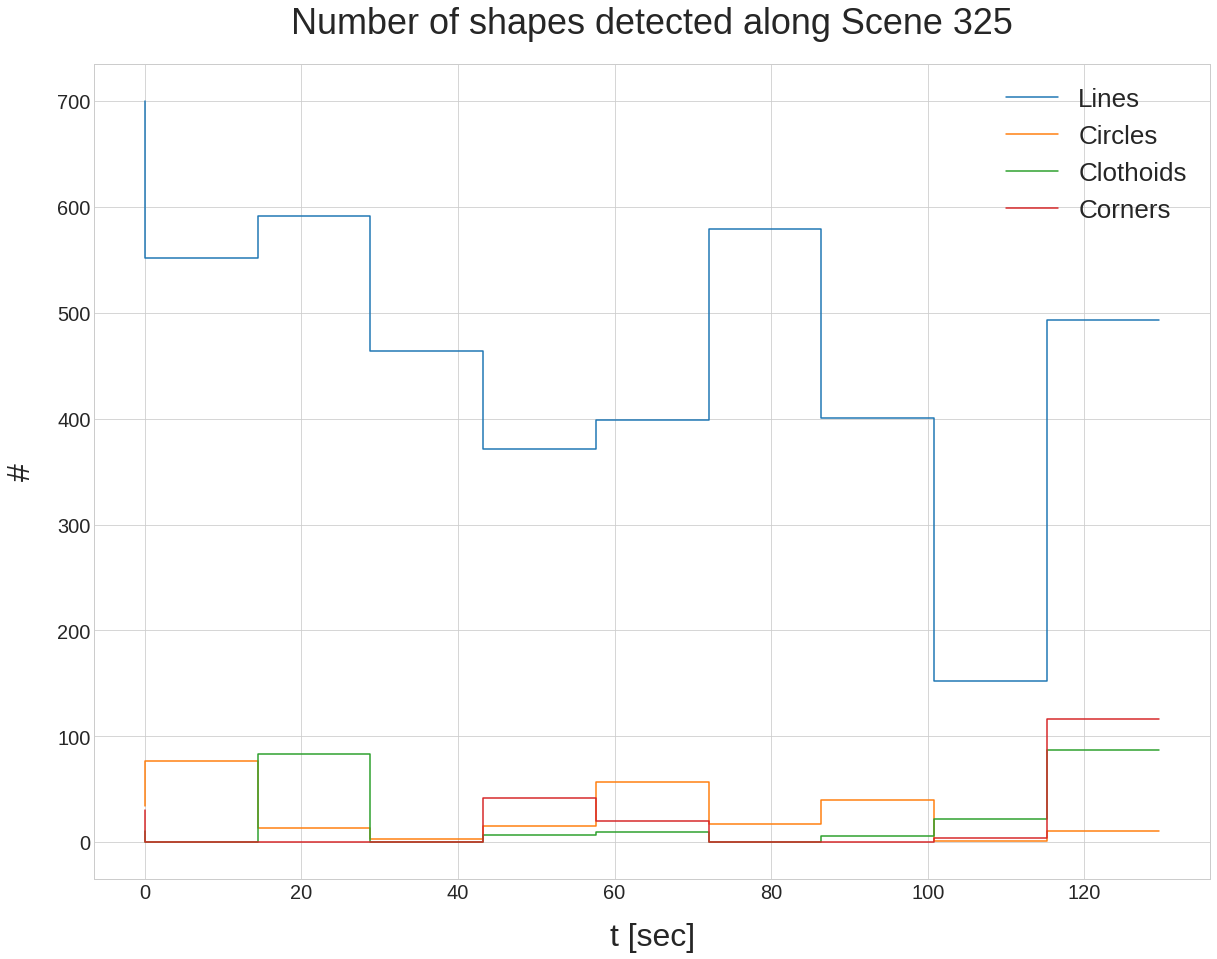

In [190]:
def calculate_summations(n_lines, K):
    n = len(n_lines)
    step = n // K

    result = [sum(n_lines[i * step:(i + 1) * step]) for i in range(K)]

    return result

K = 10
fig, ax = plt.subplots(1,1,figsize=(20,15))

t = np.linspace(0, N / 12.5, 11)[0:-1]
ax.step(t, calculate_summations(n_lines, K), label='Lines')
ax.step(t, calculate_summations(n_circles, K), label='Circles')
ax.step(t, calculate_summations(n_clothoids, K), label='Clothoids')
ax.step(t, calculate_summations(n_corners, K), label='Corners')
ax.legend(prop={'size': 26})
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.xlabel('t [sec]', fontsize=32, labelpad=20.0)
plt.ylabel('#', fontsize=32, labelpad=20.0)
ax.set_title(label=f"Number of shapes detected along Scene {scene}", y=1.03, fontsize=36)

In [169]:
video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(550)
print(polynoms)
(lines, circles, clothoids, corners) = classifyShape(polynoms)
print((lines, circles, clothoids, corners))

[{'f': poly1d([-5.19912214e-03,  6.10367115e+00, -7.70424693e+02]), 'x_start': 417.4400737010776, 'x_end': 429.5745223923158, 'fxFlag': True}, {'f': poly1d([-1.70007054e-02,  1.57291220e+01, -2.73600417e+03]), 'x_start': 409.12552524457453, 'x_end': 416.4113340921775, 'fxFlag': True}, {'f': poly1d([ 6.01350634e-02, -4.59364085e+01,  9.62724838e+03]), 'x_start': 378.7688902581814, 'x_end': 386.0840806710558, 'fxFlag': True}, {'f': poly1d([-2.16596002e-03,  1.35514293e+00,  6.57832251e+02]), 'x_start': 402.96291000307394, 'x_end': 422.1083112035551, 'fxFlag': True}]
([0, 2], [], [], [1, 3])


array([2., 2., 2., 0., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.])

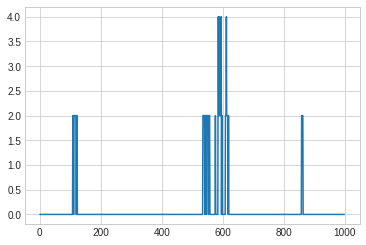

In [170]:
plt.plot(range(0,N), n_corners)
n_corners[550:580]

15.72912204486607 -2736.0041699616722 1.3551429302339437 657.8322509418001


array([-4.32936900e-01,  1.02685199e+03])

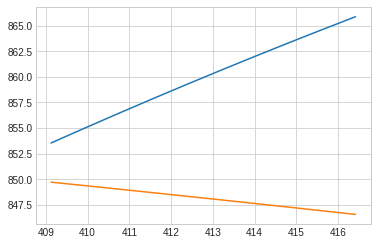

In [171]:
i = 1
j = 3
x = np.linspace(polynoms[i]['x_start'],polynoms[i]['x_end'], 10)
plt.plot(x,polynoms[i]['f'](x))
plt.plot(x,polynoms[j]['f'](x))
a1 = polynoms[i]['f'][2]
b1 = polynoms[i]['f'][1]
c1 = polynoms[i]['f'][0]
a2 = polynoms[j]['f'][2]
b2 = polynoms[j]['f'][1]
c2 = polynoms[j]['f'][0]
print(b1,c1,b2,c2)

np.polyfit(x, polynoms[i]['f'](x),1)
np.polyfit(x, polynoms[j]['f'](x),1)
#solve_quadratic_equation(a1-a2, b1-b2,c1-c2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
self.dir_name images/690/database
self.dir_name images/690/database


  0%|          | 1/1800 [00:00<05:51,  5.11it/s]

[] [] [] []
[] [] [] []


  0%|          | 3/1800 [00:00<05:36,  5.34it/s]

[] [] [] []
[] [] [] []


  0%|          | 5/1800 [00:00<05:29,  5.45it/s]

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 6/1800 [00:01<05:28,  5.46it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acce

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  0%|          | 8/1800 [00:01<05:29,  5.43it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acce

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 10/1800 [00:01<05:29,  5.43it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 12/1800 [00:02<05:26,  5.48it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 14/1800 [00:02<05:21,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 16/1800 [00:02<05:20,  5.57it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 18/1800 [00:03<05:16,  5.63it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 20/1800 [00:03<05:13,  5.68it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue', 'red'] [] [1 4] [0]
['blue', 'red'] [] [1 4] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|          | 22/1800 [00:03<05:13,  5.66it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue', 'red'] [] [1 4] [0]
['blue', 'red'] [] [1 4] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|▏         | 24/1800 [00:04<05:13,  5.67it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue', 'red'] [] [1 4] [0]
['blue', 'red'] [] [1 4] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  1%|▏         | 26/1800 [00:04<05:08,  5.76it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 28/1800 [00:05<05:10,  5.71it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue', 'red'] [] [1 2] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 30/1800 [00:05<05:07,  5.76it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue', 'red'] [] [1 2] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 32/1800 [00:05<05:06,  5.77it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 34/1800 [00:06<05:09,  5.70it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 36/1800 [00:06<05:07,  5.74it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 38/1800 [00:06<05:06,  5.74it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 41/1800 [00:07<05:01,  5.83it/s]

['magenta'] [1] [] []
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 42/1800 [00:07<05:03,  5.80it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  2%|▏         | 44/1800 [00:07<05:04,  5.77it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 46/1800 [00:08<05:05,  5.75it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 48/1800 [00:08<05:06,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 50/1800 [00:08<05:06,  5.72it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 52/1800 [00:09<05:04,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 54/1800 [00:09<05:04,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 56/1800 [00:09<05:05,  5.71it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 58/1800 [00:10<05:04,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 60/1800 [00:10<05:03,  5.74it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  3%|▎         | 62/1800 [00:10<05:03,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▎         | 64/1800 [00:11<05:02,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▎         | 66/1800 [00:11<05:04,  5.69it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 68/1800 [00:11<05:02,  5.72it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 70/1800 [00:12<05:02,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 72/1800 [00:12<05:02,  5.72it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 74/1800 [00:12<05:01,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 76/1800 [00:13<05:00,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 78/1800 [00:13<05:01,  5.71it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  4%|▍         | 80/1800 [00:14<05:03,  5.67it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [1]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 82/1800 [00:14<05:01,  5.71it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 84/1800 [00:14<04:59,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 86/1800 [00:15<04:59,  5.72it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to acc

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  5%|▍         | 89/1800 [00:15<04:53,  5.84it/s]

[] [] [] []
[] [] [] []


  5%|▌         | 91/1800 [00:15<04:50,  5.88it/s]

[] [] [] []
[] [] [] []


  5%|▌         | 93/1800 [00:16<04:49,  5.91it/s]

[] [] [] []
[] [] [] []


  5%|▌         | 95/1800 [00:16<04:48,  5.92it/s]

[] [] [] []
[] [] [] []


  5%|▌         | 97/1800 [00:16<04:48,  5.90it/s]

[] [] [] []
[] [] [] []


  6%|▌         | 99/1800 [00:17<04:47,  5.92it/s]

[] [] [] []
[] [] [] []


  6%|▌         | 101/1800 [00:17<04:46,  5.92it/s]

[] [] [] []
[] [] [] []


  6%|▌         | 103/1800 [00:17<04:47,  5.89it/s]

[] [] [] []
[] [] [] []


  6%|▌         | 105/1800 [00:18<04:46,  5.91it/s]

[] [] [] []
[] [] [] []


  6%|▌         | 107/1800 [00:18<04:46,  5.92it/s]

[] [] [] []
[] [] [] []


  6%|▌         | 109/1800 [00:18<04:46,  5.89it/s]

[] [] [] []
[] [] [] []


  6%|▌         | 111/1800 [00:19<04:45,  5.91it/s]

[] [] [] []
[] [] [] []


  6%|▋         | 113/1800 [00:19<04:44,  5.92it/s]

[] [] [] []
[] [] [] []


  6%|▋         | 115/1800 [00:20<04:45,  5.89it/s]

[] [] [] []
[] [] [] []


  6%|▋         | 117/1800 [00:20<04:45,  5.90it/s]

[] [] [] []
[] [] [] []


  7%|▋         | 119/1800 [00:20<04:44,  5.91it/s]

[] [] [] []
[] [] [] []


  7%|▋         | 121/1800 [00:21<04:44,  5.90it/s]

[] [] [] []
['blue'] [] [] [2]


  7%|▋         | 122/1800 [00:21<04:46,  5.86it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  7%|▋         | 123/1800 [00:21<04:44,  5.89it/s]

[] [] [] []
[] [] [] []


  7%|▋         | 125/1800 [00:21<04:44,  5.90it/s]

[] [] [] []
[] [] [] []


  7%|▋         | 127/1800 [00:22<04:44,  5.89it/s]

[] [] [] []
[] [] [] []


  7%|▋         | 129/1800 [00:22<04:43,  5.89it/s]

[] [] [] []
[] [] [] []


  7%|▋         | 131/1800 [00:22<04:42,  5.90it/s]

[] [] [] []
[] [] [] []


  7%|▋         | 133/1800 [00:23<04:43,  5.89it/s]

[] [] [] []
['blue'] [] [] [2]


  7%|▋         | 134/1800 [00:23<04:45,  5.83it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 135/1800 [00:23<04:44,  5.86it/s]

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 136/1800 [00:23<04:50,  5.72it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 138/1800 [00:23<04:57,  5.58it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 140/1800 [00:24<04:58,  5.57it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 142/1800 [00:24<04:58,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
  8%|▊         | 144/1800 [00:25<05:00,  5.51it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


  8%|▊         | 147/1800 [00:25<04:51,  5.68it/s]

[] [] [] []
[] [] [] []


  8%|▊         | 149/1800 [00:25<04:51,  5.66it/s]

[] [] [] []
[] [] [] []


  8%|▊         | 151/1800 [00:26<04:49,  5.70it/s]

[] [] [] []
[] [] [] []


  8%|▊         | 153/1800 [00:26<04:48,  5.72it/s]

[] [] [] []
[] [] [] []


  9%|▊         | 155/1800 [00:26<04:48,  5.70it/s]

[] [] [] []
[] [] [] []


  9%|▊         | 157/1800 [00:27<04:48,  5.70it/s]

[] [] [] []
[] [] [] []


  9%|▉         | 159/1800 [00:27<04:46,  5.73it/s]

[] [] [] []
[] [] [] []


  9%|▉         | 161/1800 [00:28<04:46,  5.72it/s]

[] [] [] []
[] [] [] []


  9%|▉         | 163/1800 [00:28<04:46,  5.72it/s]

[] [] [] []
[] [] [] []


  9%|▉         | 165/1800 [00:28<04:44,  5.74it/s]

[] [] [] []
[] [] [] []


  9%|▉         | 167/1800 [00:29<04:45,  5.72it/s]

[] [] [] []
[] [] [] []


  9%|▉         | 169/1800 [00:29<04:45,  5.72it/s]

[] [] [] []
[] [] [] []


 10%|▉         | 171/1800 [00:29<04:45,  5.71it/s]

[] [] [] []
[] [] [] []


 10%|▉         | 173/1800 [00:30<04:44,  5.72it/s]

[] [] [] []
[] [] [] []


 10%|▉         | 175/1800 [00:30<04:44,  5.71it/s]

[] [] [] []
[] [] [] []


 10%|▉         | 177/1800 [00:30<04:48,  5.63it/s]

[] [] [] []
[] [] [] []


 10%|▉         | 179/1800 [00:31<04:45,  5.67it/s]

[] [] [] []
[] [] [] []


 10%|█         | 181/1800 [00:31<04:44,  5.69it/s]

[] [] [] []
[] [] [] []


 10%|█         | 183/1800 [00:31<04:44,  5.68it/s]

[] [] [] []
[] [] [] []


 10%|█         | 185/1800 [00:32<04:40,  5.76it/s]

[] [] [] []
[] [] [] []


 10%|█         | 187/1800 [00:32<04:42,  5.71it/s]

[] [] [] []
[] [] [] []


 10%|█         | 189/1800 [00:32<04:44,  5.67it/s]

[] [] [] []
[] [] [] []


 11%|█         | 191/1800 [00:33<04:46,  5.62it/s]

[] [] [] []
[] [] [] []


 11%|█         | 193/1800 [00:33<04:45,  5.63it/s]

[] [] [] []
[] [] [] []


 11%|█         | 195/1800 [00:34<04:45,  5.63it/s]

[] [] [] []
[] [] [] []


 11%|█         | 197/1800 [00:34<04:43,  5.65it/s]

[] [] [] []
[] [] [] []


 11%|█         | 199/1800 [00:34<04:43,  5.66it/s]

[] [] [] []
[] [] [] []


 11%|█         | 201/1800 [00:35<04:43,  5.65it/s]

[] [] [] []
[] [] [] []


 11%|█▏        | 203/1800 [00:35<04:44,  5.62it/s]

[] [] [] []
[] [] [] []


 11%|█▏        | 205/1800 [00:35<04:44,  5.61it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 207/1800 [00:36<04:43,  5.63it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 209/1800 [00:36<04:47,  5.54it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 211/1800 [00:36<04:44,  5.59it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 213/1800 [00:37<04:41,  5.64it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 215/1800 [00:37<04:38,  5.69it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 217/1800 [00:37<04:40,  5.64it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 219/1800 [00:38<04:38,  5.67it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 221/1800 [00:38<04:37,  5.70it/s]

[] [] [] []
[] [] [] []


 12%|█▏        | 223/1800 [00:39<04:35,  5.72it/s]

[] [] [] []
[] [] [] []


 12%|█▎        | 225/1800 [00:39<04:35,  5.72it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 227/1800 [00:39<04:35,  5.71it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 229/1800 [00:40<04:36,  5.68it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 231/1800 [00:40<04:35,  5.69it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 233/1800 [00:40<04:36,  5.67it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 235/1800 [00:41<04:34,  5.70it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 237/1800 [00:41<04:33,  5.71it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 239/1800 [00:41<04:32,  5.72it/s]

[] [] [] []
[] [] [] []


 13%|█▎        | 241/1800 [00:42<04:32,  5.73it/s]

[] [] [] []
[] [] [] []


 14%|█▎        | 243/1800 [00:42<04:31,  5.73it/s]

[] [] [] []
[] [] [] []


 14%|█▎        | 245/1800 [00:42<04:33,  5.68it/s]

[] [] [] []
[] [] [] []


 14%|█▎        | 247/1800 [00:43<04:33,  5.67it/s]

[] [] [] []
[] [] [] []


 14%|█▍        | 249/1800 [00:43<04:33,  5.67it/s]

[] [] [] []
[] [] [] []


 14%|█▍        | 251/1800 [00:43<04:33,  5.67it/s]

[] [] [] []
[] [] [] []


 14%|█▍        | 253/1800 [00:44<04:33,  5.65it/s]

[] [] [] []
[] [] [] []


 14%|█▍        | 255/1800 [00:44<04:33,  5.65it/s]

[] [] [] []
[] [] [] []


 14%|█▍        | 257/1800 [00:45<04:33,  5.65it/s]

[] [] [] []
[] [] [] []


 14%|█▍        | 259/1800 [00:45<04:31,  5.68it/s]

[] [] [] []
[] [] [] []


 14%|█▍        | 261/1800 [00:45<04:29,  5.72it/s]

[] [] [] []
[] [] [] []


 15%|█▍        | 263/1800 [00:46<04:28,  5.73it/s]

[] [] [] []
[] [] [] []


 15%|█▍        | 265/1800 [00:46<04:27,  5.74it/s]

[] [] [] []
[] [] [] []


 15%|█▍        | 267/1800 [00:46<04:33,  5.61it/s]

[] [] [] []
[] [] [] []


 15%|█▍        | 269/1800 [00:47<04:31,  5.64it/s]

[] [] [] []
[] [] [] []


 15%|█▌        | 271/1800 [00:47<04:30,  5.66it/s]

[] [] [] []
[] [] [] []


 15%|█▌        | 273/1800 [00:47<04:31,  5.62it/s]

[] [] [] []
[] [] [] []


 15%|█▌        | 275/1800 [00:48<04:27,  5.69it/s]

[] [] [] []
[] [] [] []


 15%|█▌        | 277/1800 [00:48<04:23,  5.79it/s]

[] [] [] []
[] [] [] []


 16%|█▌        | 279/1800 [00:48<04:22,  5.79it/s]

[] [] [] []
[] [] [] []


 16%|█▌        | 281/1800 [00:49<04:24,  5.74it/s]

[] [] [] []
[] [] [] []


 16%|█▌        | 283/1800 [00:49<04:20,  5.83it/s]

[] [] [] []
[] [] [] []


 16%|█▌        | 285/1800 [00:49<04:33,  5.55it/s]

[] [] [] []
[] [] [] []


 16%|█▌        | 287/1800 [00:50<04:24,  5.72it/s]

[] [] [] []
[] [] [] []


 16%|█▌        | 289/1800 [00:50<04:21,  5.78it/s]

[] [] [] []
[] [] [] []


 16%|█▌        | 291/1800 [00:50<04:22,  5.74it/s]

[] [] [] []
[] [] [] []


 16%|█▋        | 293/1800 [00:51<04:20,  5.78it/s]

[] [] [] []
[] [] [] []


 16%|█▋        | 295/1800 [00:51<04:21,  5.77it/s]

[] [] [] []
[] [] [] []


 16%|█▋        | 297/1800 [00:52<04:19,  5.78it/s]

[] [] [] []
[] [] [] []


 17%|█▋        | 299/1800 [00:52<04:17,  5.82it/s]

[] [] [] []
[] [] [] []


 17%|█▋        | 301/1800 [00:52<04:17,  5.83it/s]

[] [] [] []
[] [] [] []


 17%|█▋        | 303/1800 [00:53<04:17,  5.81it/s]

[] [] [] []
[] [] [] []


 17%|█▋        | 305/1800 [00:53<04:16,  5.82it/s]

[] [] [] []
[] [] [] []


 17%|█▋        | 307/1800 [00:53<04:15,  5.83it/s]

[] [] [] []
[] [] [] []


 17%|█▋        | 309/1800 [00:54<04:15,  5.83it/s]

[] [] [] []
[] [] [] []


 17%|█▋        | 311/1800 [00:54<04:15,  5.82it/s]

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 312/1800 [00:54<04:18,  5.77it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 17%|█▋        | 314/1800 [00:54<04:21,  5.69it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 316/1800 [00:55<04:22,  5.66it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 318/1800 [00:55<04:22,  5.65it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 320/1800 [00:56<04:24,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 18%|█▊        | 323/1800 [00:56<04:19,  5.69it/s]

[] [] [] []
[] [] [] []


 18%|█▊        | 325/1800 [00:56<04:18,  5.70it/s]

[] [] [] []
[] [] [] []


 18%|█▊        | 327/1800 [00:57<04:17,  5.72it/s]

[] [] [] []
[] [] [] []


 18%|█▊        | 329/1800 [00:57<04:16,  5.73it/s]

[] [] [] []
[] [] [] []


 18%|█▊        | 331/1800 [00:57<04:16,  5.73it/s]

[] [] [] []
[] [] [] []


 18%|█▊        | 333/1800 [00:58<04:14,  5.76it/s]

[] [] [] []
[] [] [] []


 19%|█▊        | 335/1800 [00:58<04:12,  5.80it/s]

[] [] [] []
[] [] [] []


 19%|█▊        | 337/1800 [00:59<04:13,  5.78it/s]

[] [] [] []
[] [] [] []


 19%|█▉        | 339/1800 [00:59<04:12,  5.78it/s]

[] [] [] []
[] [] [] []


 19%|█▉        | 341/1800 [00:59<04:12,  5.77it/s]

[] [] [] []
[] [] [] []


 19%|█▉        | 343/1800 [01:00<04:13,  5.76it/s]

[] [] [] []
[] [] [] []


 19%|█▉        | 345/1800 [01:00<04:12,  5.77it/s]

[] [] [] []
[] [] [] []


 19%|█▉        | 347/1800 [01:00<04:11,  5.78it/s]

[] [] [] []
[] [] [] []


 19%|█▉        | 349/1800 [01:01<04:11,  5.77it/s]

[] [] [] []
[] [] [] []


 20%|█▉        | 351/1800 [01:01<04:10,  5.79it/s]

[] [] [] []
[] [] [] []


 20%|█▉        | 353/1800 [01:01<04:09,  5.79it/s]

[] [] [] []
[] [] [] []


 20%|█▉        | 355/1800 [01:02<04:08,  5.81it/s]

[] [] [] []
[] [] [] []


 20%|█▉        | 357/1800 [01:02<04:07,  5.84it/s]

[] [] [] []
[] [] [] []


 20%|█▉        | 359/1800 [01:02<04:08,  5.80it/s]

[] [] [] []
[] [] [] []


 20%|██        | 361/1800 [01:03<04:06,  5.84it/s]

[] [] [] []
[] [] [] []


 20%|██        | 363/1800 [01:03<04:04,  5.87it/s]

[] [] [] []
[] [] [] []


 20%|██        | 365/1800 [01:03<04:09,  5.75it/s]

[] [] [] []
[] [] [] []


 20%|██        | 367/1800 [01:04<04:06,  5.80it/s]

[] [] [] []
[] [] [] []


 20%|██        | 369/1800 [01:04<04:05,  5.83it/s]

[] [] [] []
[] [] [] []


 21%|██        | 371/1800 [01:04<04:05,  5.82it/s]

[] [] [] []
[] [] [] []


 21%|██        | 373/1800 [01:05<04:05,  5.81it/s]

[] [] [] []
[] [] [] []


 21%|██        | 375/1800 [01:05<04:04,  5.83it/s]

[] [] [] []
[] [] [] []


 21%|██        | 377/1800 [01:05<04:04,  5.83it/s]

[] [] [] []
[] [] [] []


 21%|██        | 379/1800 [01:06<04:03,  5.84it/s]

[] [] [] []
[] [] [] []


 21%|██        | 381/1800 [01:06<04:02,  5.84it/s]

[] [] [] []
[] [] [] []


 21%|██▏       | 383/1800 [01:06<04:03,  5.82it/s]

[] [] [] []
[] [] [] []


 21%|██▏       | 385/1800 [01:07<04:02,  5.82it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 387/1800 [01:07<04:01,  5.85it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 389/1800 [01:08<04:04,  5.78it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 391/1800 [01:08<04:05,  5.74it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 393/1800 [01:08<04:03,  5.78it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 395/1800 [01:09<04:03,  5.77it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 397/1800 [01:09<04:02,  5.78it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 399/1800 [01:09<04:02,  5.78it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 401/1800 [01:10<04:02,  5.77it/s]

[] [] [] []
[] [] [] []


 22%|██▏       | 403/1800 [01:10<04:01,  5.80it/s]

[] [] [] []
[] [] [] []


 22%|██▎       | 405/1800 [01:10<03:59,  5.82it/s]

[] [] [] []
[] [] [] []


 23%|██▎       | 407/1800 [01:11<03:59,  5.82it/s]

[] [] [] []
[] [] [] []


 23%|██▎       | 409/1800 [01:11<03:59,  5.80it/s]

[] [] [] []
[] [] [] []


 23%|██▎       | 411/1800 [01:11<03:59,  5.81it/s]

[] [] [] []
['blue'] [] [] [4]


 23%|██▎       | 412/1800 [01:11<04:00,  5.77it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 413/1800 [01:12<03:58,  5.82it/s]

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 414/1800 [01:12<04:01,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 416/1800 [01:12<04:02,  5.70it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 418/1800 [01:13<04:05,  5.64it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 420/1800 [01:13<04:06,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 23%|██▎       | 422/1800 [01:13<04:04,  5.64it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 24%|██▎       | 425/1800 [01:14<03:56,  5.81it/s]

[] [] [] []
[] [] [] []


 24%|██▎       | 427/1800 [01:14<03:55,  5.83it/s]

[] [] [] []
[] [] [] []


 24%|██▍       | 429/1800 [01:14<03:56,  5.81it/s]

[] [] [] []
[] [] [] []


 24%|██▍       | 431/1800 [01:15<03:54,  5.83it/s]

[] [] [] []
[] [] [] []


 24%|██▍       | 433/1800 [01:15<03:54,  5.83it/s]

[] [] [] []
[] [] [] []


 24%|██▍       | 435/1800 [01:16<03:54,  5.82it/s]

[] [] [] []
[] [] [] []


 24%|██▍       | 437/1800 [01:16<03:53,  5.83it/s]

[] [] [] []
[] [] [] []


 24%|██▍       | 439/1800 [01:16<03:53,  5.84it/s]

[] [] [] []
[] [] [] []


 24%|██▍       | 441/1800 [01:17<03:55,  5.76it/s]

[] [] [] []
[] [] [] []


 25%|██▍       | 443/1800 [01:17<03:55,  5.77it/s]

[] [] [] []
[] [] [] []


 25%|██▍       | 445/1800 [01:17<03:54,  5.77it/s]

[] [] [] []
[] [] [] []


 25%|██▍       | 447/1800 [01:18<03:55,  5.73it/s]

[] [] [] []
[] [] [] []


 25%|██▍       | 449/1800 [01:18<03:53,  5.77it/s]

[] [] [] []
[] [] [] []


 25%|██▌       | 451/1800 [01:18<03:52,  5.79it/s]

[] [] [] []
[] [] [] []


 25%|██▌       | 453/1800 [01:19<03:51,  5.83it/s]

[] [] [] []
[] [] [] []


 25%|██▌       | 455/1800 [01:19<03:50,  5.83it/s]

[] [] [] []
[] [] [] []


 25%|██▌       | 457/1800 [01:19<03:50,  5.82it/s]

[] [] [] []
[] [] [] []


 26%|██▌       | 459/1800 [01:20<03:50,  5.82it/s]

[] [] [] []
[] [] [] []


 26%|██▌       | 461/1800 [01:20<03:49,  5.85it/s]

[] [] [] []
[] [] [] []


 26%|██▌       | 463/1800 [01:20<03:51,  5.77it/s]

[] [] [] []
[] [] [] []


 26%|██▌       | 465/1800 [01:21<03:49,  5.82it/s]

[] [] [] []
['magenta'] [3] [] []


 26%|██▌       | 466/1800 [01:21<03:51,  5.75it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 467/1800 [01:21<03:49,  5.81it/s]

['magenta'] [3] [] []
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 468/1800 [01:21<03:53,  5.72it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 470/1800 [01:22<03:55,  5.64it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▌       | 472/1800 [01:22<03:57,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▋       | 474/1800 [01:22<03:56,  5.62it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 26%|██▋       | 476/1800 [01:23<03:57,  5.58it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 27%|██▋       | 479/1800 [01:23<03:48,  5.78it/s]

[] [] [] []
['blue'] [] [] [4]


 27%|██▋       | 480/1800 [01:23<03:51,  5.71it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 481/1800 [01:24<03:48,  5.76it/s]

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 482/1800 [01:24<03:51,  5.70it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 484/1800 [01:24<03:51,  5.68it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 486/1800 [01:24<03:52,  5.66it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 488/1800 [01:25<03:51,  5.67it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 27%|██▋       | 490/1800 [01:25<03:51,  5.66it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 27%|██▋       | 493/1800 [01:26<03:46,  5.78it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 495/1800 [01:26<03:45,  5.80it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 497/1800 [01:26<03:44,  5.80it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 499/1800 [01:27<03:43,  5.82it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 501/1800 [01:27<03:42,  5.83it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 503/1800 [01:27<03:43,  5.80it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 505/1800 [01:28<03:44,  5.77it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 507/1800 [01:28<03:46,  5.71it/s]

[] [] [] []
[] [] [] []


 28%|██▊       | 509/1800 [01:28<03:47,  5.66it/s]

[] [] [] []
['blue'] [] [] [2]


 28%|██▊       | 510/1800 [01:29<03:50,  5.59it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 511/1800 [01:29<03:49,  5.62it/s]

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 28%|██▊       | 512/1800 [01:29<03:54,  5.49it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▊       | 514/1800 [01:29<03:58,  5.38it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▊       | 516/1800 [01:30<03:58,  5.39it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 518/1800 [01:30<03:52,  5.51it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 520/1800 [01:30<03:51,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
['blue'] [] [] [1]


 29%|██▉       | 522/1800 [01:31<03:47,  5.62it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 523/1800 [01:31<03:44,  5.69it/s]

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 524/1800 [01:31<03:46,  5.63it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 526/1800 [01:31<03:50,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 528/1800 [01:32<03:47,  5.59it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 29%|██▉       | 530/1800 [01:32<03:46,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 532/1800 [01:33<03:49,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
['blue'] [] [] [5]


 30%|██▉       | 534/1800 [01:33<03:48,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 535/1800 [01:33<03:44,  5.63it/s]

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 536/1800 [01:33<03:48,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|██▉       | 538/1800 [01:34<03:49,  5.49it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 540/1800 [01:34<03:50,  5.47it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 542/1800 [01:34<03:50,  5.47it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 30%|███       | 544/1800 [01:35<03:48,  5.49it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 30%|███       | 547/1800 [01:35<03:40,  5.68it/s]

[] [] [] []
[] [] [] []


 30%|███       | 549/1800 [01:36<03:37,  5.75it/s]

[] [] [] []
[] [] [] []


 31%|███       | 551/1800 [01:36<03:35,  5.79it/s]

[] [] [] []
[] [] [] []


 31%|███       | 553/1800 [01:36<03:37,  5.73it/s]

[] [] [] []
[] [] [] []


 31%|███       | 555/1800 [01:37<03:36,  5.75it/s]

[] [] [] []
[] [] [] []


 31%|███       | 557/1800 [01:37<03:35,  5.77it/s]

[] [] [] []
[] [] [] []


 31%|███       | 559/1800 [01:37<03:38,  5.67it/s]

[] [] [] []
[] [] [] []


 31%|███       | 561/1800 [01:38<03:35,  5.74it/s]

[] [] [] []
[] [] [] []


 31%|███▏      | 563/1800 [01:38<03:34,  5.77it/s]

[] [] [] []
[] [] [] []


 31%|███▏      | 565/1800 [01:38<03:35,  5.73it/s]

[] [] [] []
[] [] [] []


 32%|███▏      | 567/1800 [01:39<03:34,  5.76it/s]

[] [] [] []
['blue'] [] [] [4]


 32%|███▏      | 568/1800 [01:39<03:36,  5.70it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 569/1800 [01:39<03:33,  5.75it/s]

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 570/1800 [01:39<03:39,  5.61it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [4]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 572/1800 [01:40<03:42,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue', 'blue'] [] [] [0 4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 574/1800 [01:40<03:41,  5.54it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue', 'blue'] [] [] [0 4]
['blue', 'blue'] [] [] [0 4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 576/1800 [01:40<03:44,  5.46it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue', 'blue'] [] [] [0 4]
['blue', 'blue'] [] [] [0 4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 578/1800 [01:41<03:43,  5.48it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 580/1800 [01:41<03:41,  5.51it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 582/1800 [01:41<03:40,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 32%|███▏      | 584/1800 [01:42<03:37,  5.59it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
['blue'] [] [] [3]


 33%|███▎      | 586/1800 [01:42<03:36,  5.62it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 587/1800 [01:42<03:35,  5.62it/s]

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 588/1800 [01:43<03:37,  5.58it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 590/1800 [01:43<03:38,  5.54it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 592/1800 [01:43<03:36,  5.58it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 594/1800 [01:44<03:37,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 596/1800 [01:44<03:35,  5.58it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
['blue'] [] [] [4]


 33%|███▎      | 598/1800 [01:44<03:33,  5.64it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 599/1800 [01:44<03:30,  5.70it/s]

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 600/1800 [01:45<03:32,  5.64it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 33%|███▎      | 602/1800 [01:45<03:32,  5.63it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [4]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▎      | 604/1800 [01:45<03:32,  5.62it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▎      | 606/1800 [01:46<03:32,  5.62it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 34%|███▍      | 608/1800 [01:46<03:31,  5.63it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 34%|███▍      | 611/1800 [01:47<03:26,  5.75it/s]

[] [] [] []
[] [] [] []


 34%|███▍      | 613/1800 [01:47<03:25,  5.78it/s]

[] [] [] []
[] [] [] []


 34%|███▍      | 615/1800 [01:47<03:25,  5.76it/s]

[] [] [] []
[] [] [] []


 34%|███▍      | 617/1800 [01:48<03:24,  5.78it/s]

[] [] [] []
[] [] [] []


 34%|███▍      | 619/1800 [01:48<03:24,  5.77it/s]

[] [] [] []
[] [] [] []


 34%|███▍      | 621/1800 [01:48<03:26,  5.70it/s]

[] [] [] []
[] [] [] []


 35%|███▍      | 623/1800 [01:49<03:24,  5.75it/s]

[] [] [] []
[] [] [] []


 35%|███▍      | 625/1800 [01:49<03:22,  5.81it/s]

[] [] [] []
[] [] [] []


 35%|███▍      | 627/1800 [01:49<03:22,  5.80it/s]

[] [] [] []
[] [] [] []


 35%|███▍      | 629/1800 [01:50<03:21,  5.81it/s]

[] [] [] []
[] [] [] []


 35%|███▌      | 631/1800 [01:50<03:20,  5.82it/s]

[] [] [] []
[] [] [] []


 35%|███▌      | 633/1800 [01:50<03:23,  5.74it/s]

[] [] [] []
['blue'] [] [] [2]


 35%|███▌      | 634/1800 [01:51<03:24,  5.71it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 635/1800 [01:51<03:22,  5.76it/s]

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 636/1800 [01:51<03:24,  5.69it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 35%|███▌      | 638/1800 [01:51<03:25,  5.65it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 640/1800 [01:52<03:26,  5.61it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 642/1800 [01:52<03:25,  5.63it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 36%|███▌      | 644/1800 [01:52<03:27,  5.58it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 36%|███▌      | 647/1800 [01:53<03:20,  5.74it/s]

[] [] [] []
[] [] [] []


 36%|███▌      | 649/1800 [01:53<03:17,  5.82it/s]

[] [] [] []
[] [] [] []


 36%|███▌      | 651/1800 [01:54<03:16,  5.84it/s]

[] [] [] []
[] [] [] []


 36%|███▋      | 653/1800 [01:54<03:16,  5.85it/s]

[] [] [] []
[] [] [] []


 36%|███▋      | 655/1800 [01:54<03:15,  5.86it/s]

[] [] [] []
[] [] [] []


 36%|███▋      | 657/1800 [01:55<03:15,  5.85it/s]

[] [] [] []
[] [] [] []


 37%|███▋      | 659/1800 [01:55<03:15,  5.85it/s]

[] [] [] []
[] [] [] []


 37%|███▋      | 661/1800 [01:55<03:15,  5.84it/s]

[] [] [] []
[] [] [] []


 37%|███▋      | 663/1800 [01:56<03:14,  5.84it/s]

[] [] [] []
[] [] [] []


 37%|███▋      | 665/1800 [01:56<03:14,  5.84it/s]

[] [] [] []
[] [] [] []


 37%|███▋      | 667/1800 [01:56<03:14,  5.81it/s]

['red', 'red'] [] [0 3] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 668/1800 [01:57<03:17,  5.74it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 3] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 670/1800 [01:57<03:18,  5.68it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 3] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 673/1800 [01:57<03:17,  5.71it/s]

['red', 'red'] [] [1 4] []
['red', 'red'] [] [1 4] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 37%|███▋      | 674/1800 [01:58<03:18,  5.68it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [1 4] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 676/1800 [01:58<03:19,  5.64it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 3] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 38%|███▊      | 679/1800 [01:58<03:17,  5.67it/s]

[] [] [] []
[] [] [] []


 38%|███▊      | 681/1800 [01:59<03:14,  5.76it/s]

[] [] [] []
[] [] [] []


 38%|███▊      | 683/1800 [01:59<03:12,  5.80it/s]

[] [] [] []
[] [] [] []


 38%|███▊      | 685/1800 [01:59<03:12,  5.80it/s]

[] [] [] []
[] [] [] []


 38%|███▊      | 687/1800 [02:00<03:11,  5.82it/s]

[] [] [] []
[] [] [] []


 38%|███▊      | 689/1800 [02:00<03:10,  5.83it/s]

[] [] [] []
[] [] [] []


 38%|███▊      | 691/1800 [02:01<03:10,  5.81it/s]

[] [] [] []
[] [] [] []


 38%|███▊      | 693/1800 [02:01<03:09,  5.84it/s]

[] [] [] []
['blue'] [] [] [2]


 39%|███▊      | 694/1800 [02:01<03:11,  5.78it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▊      | 695/1800 [02:01<03:10,  5.81it/s]

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▊      | 696/1800 [02:01<03:14,  5.67it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 698/1800 [02:02<03:16,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 700/1800 [02:02<03:15,  5.61it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 702/1800 [02:02<03:18,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 704/1800 [02:03<03:17,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 39%|███▉      | 707/1800 [02:03<03:14,  5.62it/s]

['blue'] [] [] [5]
['blue'] [] [] [5]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 708/1800 [02:04<03:14,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue', 'magenta'] [6] [] [4]
['blue', 'magenta'] [6] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 39%|███▉      | 710/1800 [02:04<03:15,  5.59it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue', 'magenta'] [5] [] [3]
['blue', 'magenta'] [3] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 712/1800 [02:04<03:15,  5.56it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue', 'magenta'] [3] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 714/1800 [02:05<03:15,  5.57it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 716/1800 [02:05<03:14,  5.59it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|███▉      | 719/1800 [02:06<03:09,  5.71it/s]

['blue'] [] [] [3]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 720/1800 [02:06<03:09,  5.69it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 722/1800 [02:06<03:10,  5.66it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [1]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 724/1800 [02:06<03:10,  5.65it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 726/1800 [02:07<03:11,  5.59it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 40%|████      | 728/1800 [02:07<03:10,  5.62it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 41%|████      | 731/1800 [02:08<03:08,  5.66it/s]

['red', 'blue'] [] [1 4] [3]
['red', 'blue', 'red'] [] [1 4] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 41%|████      | 732/1800 [02:08<03:10,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 3] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 41%|████      | 734/1800 [02:08<03:10,  5.59it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 41%|████      | 737/1800 [02:09<03:08,  5.65it/s]

[] [] [] []
[] [] [] []


 41%|████      | 739/1800 [02:09<03:06,  5.68it/s]

[] [] [] []
[] [] [] []


 41%|████      | 741/1800 [02:09<03:07,  5.66it/s]

[] [] [] []
[] [] [] []


 41%|████▏     | 743/1800 [02:10<03:06,  5.66it/s]

[] [] [] []
[] [] [] []


 41%|████▏     | 745/1800 [02:10<03:06,  5.66it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 747/1800 [02:10<03:06,  5.65it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 749/1800 [02:11<03:05,  5.67it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 751/1800 [02:11<03:04,  5.67it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 753/1800 [02:12<03:04,  5.67it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 755/1800 [02:12<03:03,  5.70it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 757/1800 [02:12<03:03,  5.70it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 759/1800 [02:13<03:02,  5.71it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 761/1800 [02:13<03:02,  5.70it/s]

[] [] [] []
[] [] [] []


 42%|████▏     | 763/1800 [02:13<03:02,  5.69it/s]

[] [] [] []
[] [] [] []


 42%|████▎     | 765/1800 [02:14<03:02,  5.68it/s]

[] [] [] []
[] [] [] []


 43%|████▎     | 767/1800 [02:14<03:01,  5.69it/s]

[] [] [] []
[] [] [] []


 43%|████▎     | 769/1800 [02:14<03:03,  5.63it/s]

[] [] [] []
[] [] [] []


 43%|████▎     | 771/1800 [02:15<03:01,  5.67it/s]

[] [] [] []
[] [] [] []


 43%|████▎     | 773/1800 [02:15<03:00,  5.70it/s]

[] [] [] []
[] [] [] []


 43%|████▎     | 775/1800 [02:15<03:00,  5.69it/s]

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 43%|████▎     | 776/1800 [02:16<03:01,  5.64it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [3]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 43%|████▎     | 778/1800 [02:16<03:04,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 43%|████▎     | 780/1800 [02:16<03:04,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 44%|████▎     | 783/1800 [02:17<03:02,  5.57it/s]

[] [] [] []
[] [] [] []


 44%|████▎     | 785/1800 [02:17<02:58,  5.69it/s]

[] [] [] []
[] [] [] []


 44%|████▎     | 787/1800 [02:18<02:57,  5.70it/s]

[] [] [] []
[] [] [] []


 44%|████▍     | 789/1800 [02:18<02:55,  5.76it/s]

[] [] [] []
[] [] [] []


 44%|████▍     | 791/1800 [02:18<02:56,  5.71it/s]

[] [] [] []
[] [] [] []


 44%|████▍     | 793/1800 [02:19<02:55,  5.72it/s]

[] [] [] []
[] [] [] []


 44%|████▍     | 795/1800 [02:19<02:54,  5.76it/s]

[] [] [] []
[] [] [] []


 44%|████▍     | 797/1800 [02:19<02:53,  5.78it/s]

[] [] [] []
[] [] [] []


 44%|████▍     | 799/1800 [02:20<02:52,  5.81it/s]

[] [] [] []
[] [] [] []


 44%|████▍     | 801/1800 [02:20<02:51,  5.82it/s]

[] [] [] []
[] [] [] []


 45%|████▍     | 803/1800 [02:20<02:51,  5.80it/s]

[] [] [] []
[] [] [] []


 45%|████▍     | 805/1800 [02:21<02:51,  5.81it/s]

[] [] [] []
[] [] [] []


 45%|████▍     | 807/1800 [02:21<02:50,  5.81it/s]

[] [] [] []
[] [] [] []


 45%|████▍     | 809/1800 [02:21<02:51,  5.77it/s]

[] [] [] []
[] [] [] []


 45%|████▌     | 811/1800 [02:22<02:51,  5.75it/s]

[] [] [] []
[] [] [] []


 45%|████▌     | 813/1800 [02:22<02:50,  5.80it/s]

[] [] [] []
[] [] [] []


 45%|████▌     | 815/1800 [02:22<02:49,  5.80it/s]

[] [] [] []
[] [] [] []


 45%|████▌     | 817/1800 [02:23<02:48,  5.82it/s]

[] [] [] []
[] [] [] []


 46%|████▌     | 819/1800 [02:23<02:48,  5.82it/s]

[] [] [] []
[] [] [] []


 46%|████▌     | 821/1800 [02:23<02:48,  5.80it/s]

[] [] [] []
[] [] [] []


 46%|████▌     | 823/1800 [02:24<02:47,  5.84it/s]

[] [] [] []
[] [] [] []


 46%|████▌     | 825/1800 [02:24<02:47,  5.83it/s]

[] [] [] []
[] [] [] []


 46%|████▌     | 827/1800 [02:24<02:47,  5.81it/s]

[] [] [] []
[] [] [] []


 46%|████▌     | 829/1800 [02:25<02:47,  5.81it/s]

[] [] [] []
[] [] [] []


 46%|████▌     | 831/1800 [02:25<02:46,  5.83it/s]

[] [] [] []
[] [] [] []


 46%|████▋     | 833/1800 [02:26<02:46,  5.82it/s]

[] [] [] []
[] [] [] []


 46%|████▋     | 835/1800 [02:26<02:45,  5.83it/s]

[] [] [] []
[] [] [] []


 46%|████▋     | 837/1800 [02:26<02:44,  5.84it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 839/1800 [02:27<02:45,  5.82it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 841/1800 [02:27<02:44,  5.83it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 843/1800 [02:27<02:44,  5.83it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 845/1800 [02:28<02:44,  5.81it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 847/1800 [02:28<02:43,  5.84it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 849/1800 [02:28<02:42,  5.84it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 851/1800 [02:29<02:42,  5.84it/s]

[] [] [] []
[] [] [] []


 47%|████▋     | 853/1800 [02:29<02:42,  5.83it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 855/1800 [02:29<02:41,  5.84it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 857/1800 [02:30<02:41,  5.84it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 859/1800 [02:30<02:40,  5.86it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 861/1800 [02:30<02:42,  5.78it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 863/1800 [02:31<02:40,  5.83it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 865/1800 [02:31<02:40,  5.84it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 867/1800 [02:31<02:41,  5.79it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 869/1800 [02:32<02:40,  5.82it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 871/1800 [02:32<02:39,  5.82it/s]

[] [] [] []
[] [] [] []


 48%|████▊     | 873/1800 [02:32<02:39,  5.81it/s]

[] [] [] []
[] [] [] []


 49%|████▊     | 875/1800 [02:33<02:38,  5.82it/s]

[] [] [] []
[] [] [] []


 49%|████▊     | 877/1800 [02:33<02:38,  5.81it/s]

[] [] [] []
[] [] [] []


 49%|████▉     | 879/1800 [02:33<02:40,  5.73it/s]

[] [] [] []
[] [] [] []


 49%|████▉     | 881/1800 [02:34<02:41,  5.68it/s]

[] [] [] []
[] [] [] []


 49%|████▉     | 883/1800 [02:34<02:39,  5.75it/s]

[] [] [] []
[] [] [] []


 49%|████▉     | 885/1800 [02:35<02:38,  5.78it/s]

[] [] [] []
[] [] [] []


 49%|████▉     | 887/1800 [02:35<02:37,  5.80it/s]

[] [] [] []
[] [] [] []


 49%|████▉     | 889/1800 [02:35<02:36,  5.81it/s]

[] [] [] []
[] [] [] []


 50%|████▉     | 891/1800 [02:36<02:36,  5.83it/s]

[] [] [] []
[] [] [] []


 50%|████▉     | 893/1800 [02:36<02:35,  5.82it/s]

[] [] [] []
[] [] [] []


 50%|████▉     | 895/1800 [02:36<02:35,  5.84it/s]

[] [] [] []
[] [] [] []


 50%|████▉     | 897/1800 [02:37<02:34,  5.83it/s]

[] [] [] []
[] [] [] []


 50%|████▉     | 899/1800 [02:37<02:34,  5.84it/s]

[] [] [] []
[] [] [] []


 50%|█████     | 901/1800 [02:37<02:34,  5.83it/s]

[] [] [] []
[] [] [] []


 50%|█████     | 903/1800 [02:38<02:33,  5.83it/s]

[] [] [] []
[] [] [] []


 50%|█████     | 905/1800 [02:38<02:33,  5.83it/s]

[] [] [] []
[] [] [] []


 50%|█████     | 907/1800 [02:38<02:33,  5.82it/s]

[] [] [] []
[] [] [] []


 50%|█████     | 909/1800 [02:39<02:32,  5.84it/s]

[] [] [] []
[] [] [] []


 51%|█████     | 911/1800 [02:39<02:32,  5.84it/s]

[] [] [] []
[] [] [] []


 51%|█████     | 913/1800 [02:39<02:32,  5.82it/s]

[] [] [] []
[] [] [] []


 51%|█████     | 915/1800 [02:40<02:31,  5.83it/s]

[] [] [] []
[] [] [] []


 51%|█████     | 917/1800 [02:40<02:31,  5.84it/s]

[] [] [] []
[] [] [] []


 51%|█████     | 919/1800 [02:40<02:32,  5.78it/s]

[] [] [] []
[] [] [] []


 51%|█████     | 921/1800 [02:41<02:31,  5.81it/s]

[] [] [] []
[] [] [] []


 51%|█████▏    | 923/1800 [02:41<02:30,  5.83it/s]

[] [] [] []
[] [] [] []


 51%|█████▏    | 925/1800 [02:41<02:30,  5.80it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 927/1800 [02:42<02:29,  5.83it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 929/1800 [02:42<02:28,  5.85it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 931/1800 [02:42<02:29,  5.81it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 933/1800 [02:43<02:29,  5.82it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 935/1800 [02:43<02:28,  5.82it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 937/1800 [02:43<02:28,  5.80it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 939/1800 [02:44<02:28,  5.81it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 941/1800 [02:44<02:25,  5.88it/s]

[] [] [] []
[] [] [] []


 52%|█████▏    | 943/1800 [02:45<02:27,  5.80it/s]

[] [] [] []
[] [] [] []


 52%|█████▎    | 945/1800 [02:45<02:27,  5.79it/s]

[] [] [] []
[] [] [] []


 53%|█████▎    | 947/1800 [02:45<02:27,  5.77it/s]

[] [] [] []
[] [] [] []


 53%|█████▎    | 949/1800 [02:46<02:28,  5.74it/s]

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 53%|█████▎    | 950/1800 [02:46<02:30,  5.67it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

[] [] [] []
[] [] [] []


 53%|█████▎    | 953/1800 [02:46<02:28,  5.71it/s]

[] [] [] []
[] [] [] []


 53%|█████▎    | 955/1800 [02:47<02:27,  5.71it/s]

['red', 'red'] [] [1 2] []
['red', 'red'] [] [0 1] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 53%|█████▎    | 956/1800 [02:47<02:29,  5.65it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 1] []
['red', 'red'] [] [0 1] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 53%|█████▎    | 958/1800 [02:47<02:31,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 1] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 53%|█████▎    | 961/1800 [02:48<02:30,  5.59it/s]

['red', 'red'] [] [0 3] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 53%|█████▎    | 962/1800 [02:48<02:30,  5.57it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 3] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▎    | 964/1800 [02:48<02:31,  5.54it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 3] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▎    | 967/1800 [02:49<02:27,  5.63it/s]

['red', 'red'] [] [2 3] []
['red', 'red'] [] [2 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▍    | 968/1800 [02:49<02:24,  5.75it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [2 3] []
['red', 'red'] [] [2 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▍    | 970/1800 [02:49<02:30,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['red', 'red'] [] [0 1] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▍    | 973/1800 [02:50<02:28,  5.57it/s]

['magenta'] [3] [] []
['magenta'] [3] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▍    | 974/1800 [02:50<02:28,  5.56it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['magenta'] [3] [] []
['magenta'] [3] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▍    | 976/1800 [02:50<02:29,  5.50it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['magenta'] [3] [] []
['magenta'] [1] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▍    | 978/1800 [02:51<02:29,  5.49it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['magenta'] [1] [] []
['magenta'] [1] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 54%|█████▍    | 980/1800 [02:51<02:30,  5.44it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['magenta'] [1] [] []
['magenta'] [1] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 55%|█████▍    | 982/1800 [02:52<02:30,  5.43it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to ac

['magenta'] [0] [] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 55%|█████▍    | 985/1800 [02:52<02:25,  5.59it/s]

[] [] [] []
[] [] [] []


 55%|█████▍    | 987/1800 [02:52<02:25,  5.61it/s]

[] [] [] []
[] [] [] []


 55%|█████▍    | 989/1800 [02:53<02:23,  5.65it/s]

[] [] [] []
[] [] [] []


 55%|█████▌    | 991/1800 [02:53<02:22,  5.67it/s]

[] [] [] []
[] [] [] []


 55%|█████▌    | 993/1800 [02:53<02:22,  5.66it/s]

[] [] [] []
[] [] [] []


 55%|█████▌    | 995/1800 [02:54<02:21,  5.70it/s]

[] [] [] []
[] [] [] []


 55%|█████▌    | 997/1800 [02:54<02:20,  5.72it/s]

[] [] [] []
[] [] [] []


 56%|█████▌    | 999/1800 [02:55<02:21,  5.68it/s]

[] [] [] []
[] [] [] []


 56%|█████▌    | 1001/1800 [02:55<02:20,  5.71it/s]

[] [] [] []
[] [] [] []


 56%|█████▌    | 1003/1800 [02:55<02:19,  5.72it/s]

[] [] [] []
[] [] [] []


 56%|█████▌    | 1005/1800 [02:56<02:18,  5.72it/s]

[] [] [] []
[] [] [] []


 56%|█████▌    | 1007/1800 [02:56<02:18,  5.71it/s]

[] [] [] []
[] [] [] []


 56%|█████▌    | 1009/1800 [02:56<02:18,  5.72it/s]

[] [] [] []
[] [] [] []


 56%|█████▌    | 1011/1800 [02:57<02:18,  5.71it/s]

[] [] [] []
[] [] [] []


 56%|█████▋    | 1013/1800 [02:57<02:17,  5.72it/s]

[] [] [] []
[] [] [] []


 56%|█████▋    | 1015/1800 [02:57<02:17,  5.70it/s]

[] [] [] []
[] [] [] []


 56%|█████▋    | 1017/1800 [02:58<02:17,  5.71it/s]

[] [] [] []
[] [] [] []


 57%|█████▋    | 1019/1800 [02:58<02:16,  5.72it/s]

[] [] [] []
[] [] [] []


 57%|█████▋    | 1021/1800 [02:58<02:16,  5.71it/s]

[] [] [] []
[] [] [] []


 57%|█████▋    | 1023/1800 [02:59<02:16,  5.68it/s]

[] [] [] []
[] [] [] []


 57%|█████▋    | 1025/1800 [02:59<02:15,  5.70it/s]

[] [] [] []
[] [] [] []


 57%|█████▋    | 1027/1800 [02:59<02:15,  5.71it/s]

['blue'] [] [] [2]
['blue', 'magenta'] [2] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 57%|█████▋    | 1028/1800 [03:00<02:16,  5.65it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue', 'magenta'] [2] [] [1]
['blue', 'magenta'] [2] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 57%|█████▋    | 1030/1800 [03:00<02:19,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue', 'magenta'] [1] [] [0]
['blue', 'magenta'] [1] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 57%|█████▋    | 1032/1800 [03:00<02:20,  5.45it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue', 'magenta'] [1] [] [0]
['blue', 'magenta'] [1] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 57%|█████▋    | 1034/1800 [03:01<02:21,  5.43it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue', 'magenta'] [1] [] [0]
['blue', 'magenta'] [1] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1036/1800 [03:01<02:21,  5.41it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue', 'magenta'] [1] [] [0]
['magenta', 'red'] [0] [3 5] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1038/1800 [03:01<02:21,  5.37it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [2 4] []
['red', 'red', 'red', 'red'] [] [0 2 1 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1040/1800 [03:02<02:21,  5.38it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red', 'red', 'red'] [] [0 2 1 3] []
['red', 'red', 'red', 'red'] [] [0 2 1 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1042/1800 [03:02<02:21,  5.37it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 2] []
['red', 'red', 'red', 'red'] [] [0 2 1 4] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1044/1800 [03:03<02:23,  5.26it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red', 'red', 'red'] [] [0 2 1 4] []
['red', 'red', 'red', 'red'] [] [0 2 1 4] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1046/1800 [03:03<02:22,  5.31it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 3] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1048/1800 [03:03<02:20,  5.34it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
['red', 'red'] [] [2 4] []


 58%|█████▊    | 1050/1800 [03:04<02:17,  5.44it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1051/1800 [03:04<02:14,  5.55it/s]

['red', 'red'] [] [1 3] []
['red', 'red'] [] [1 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 58%|█████▊    | 1052/1800 [03:04<02:16,  5.48it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▊    | 1054/1800 [03:04<02:16,  5.45it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
['red', 'red'] [] [1 2] []


 59%|█████▊    | 1056/1800 [03:05<02:13,  5.56it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▊    | 1057/1800 [03:05<02:11,  5.64it/s]

['red', 'red'] [] [1 2] []
['red', 'red'] [] [0 1] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▉    | 1058/1800 [03:05<02:12,  5.60it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 1] []
['red', 'red'] [] [0 1] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▉    | 1060/1800 [03:06<02:12,  5.58it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
['red', 'red'] [] [0 2] []


 59%|█████▉    | 1062/1800 [03:06<02:12,  5.56it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▉    | 1063/1800 [03:06<02:10,  5.65it/s]

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▉    | 1064/1800 [03:06<02:12,  5.57it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▉    | 1066/1800 [03:07<02:12,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
['red', 'red'] [] [1 3] []


 59%|█████▉    | 1068/1800 [03:07<02:11,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▉    | 1069/1800 [03:07<02:09,  5.63it/s]

['red', 'red'] [] [1 3] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 59%|█████▉    | 1070/1800 [03:07<02:11,  5.56it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 60%|█████▉    | 1072/1800 [03:08<02:11,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
[] [] [] []


 60%|█████▉    | 1075/1800 [03:08<02:07,  5.68it/s]

[] [] [] []
[] [] [] []


 60%|█████▉    | 1077/1800 [03:09<02:06,  5.74it/s]

[] [] [] []
[] [] [] []


 60%|█████▉    | 1079/1800 [03:09<02:05,  5.76it/s]

[] [] [] []
[] [] [] []


 60%|██████    | 1081/1800 [03:09<02:04,  5.78it/s]

[] [] [] []
[] [] [] []


 60%|██████    | 1083/1800 [03:10<02:04,  5.77it/s]

[] [] [] []
[] [] [] []


 60%|██████    | 1085/1800 [03:10<02:04,  5.76it/s]

[] [] [] []
[] [] [] []


 60%|██████    | 1087/1800 [03:10<02:03,  5.75it/s]

[] [] [] []
[] [] [] []


 60%|██████    | 1089/1800 [03:11<02:06,  5.62it/s]

[] [] [] []
[] [] [] []


 61%|██████    | 1091/1800 [03:11<02:04,  5.70it/s]

[] [] [] []
[] [] [] []


 61%|██████    | 1093/1800 [03:11<02:04,  5.69it/s]

[] [] [] []
[] [] [] []


 61%|██████    | 1095/1800 [03:12<02:02,  5.74it/s]

[] [] [] []
[] [] [] []


 61%|██████    | 1097/1800 [03:12<02:01,  5.78it/s]

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 61%|██████    | 1098/1800 [03:12<02:02,  5.73it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 61%|██████    | 1101/1800 [03:13<02:05,  5.58it/s]

[] [] [] []
[] [] [] []


 61%|██████▏   | 1103/1800 [03:13<02:03,  5.65it/s]

[] [] [] []
[] [] [] []


 61%|██████▏   | 1105/1800 [03:13<02:03,  5.61it/s]

[] [] [] []
[] [] [] []


 62%|██████▏   | 1107/1800 [03:14<02:02,  5.67it/s]

[] [] [] []
[] [] [] []


 62%|██████▏   | 1109/1800 [03:14<02:00,  5.73it/s]

[] [] [] []
['magenta'] [2] [] []


 62%|██████▏   | 1110/1800 [03:14<02:01,  5.67it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1111/1800 [03:15<02:00,  5.73it/s]

['magenta'] [2] [] []
['magenta'] [2] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1112/1800 [03:15<02:01,  5.65it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['magenta'] [2] [] []
['magenta'] [2] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1114/1800 [03:15<02:04,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['magenta', 'red'] [2] [3 4] []
['magenta', 'red'] [1] [2 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1116/1800 [03:15<02:05,  5.45it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['magenta', 'red', 'red'] [0] [1 2] []
['magenta', 'red', 'red'] [0] [1 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1118/1800 [03:16<02:08,  5.32it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['magenta', 'red', 'red'] [0] [1 2 2 5] []
['magenta', 'red', 'red'] [0] [1 2 2 5] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1120/1800 [03:16<02:09,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red', 'red'] [] [0 1 1 4] []
['red', 'red', 'red'] [] [0 1 1 4] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1122/1800 [03:17<02:07,  5.30it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red', 'red'] [] [0 1 1 4] []
['red', 'red', 'red'] [] [0 1 1 4] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 62%|██████▏   | 1124/1800 [03:17<02:06,  5.33it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 3] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 63%|██████▎   | 1127/1800 [03:18<02:06,  5.31it/s]

['red', 'red'] [] [2 3] []
['red', 'red'] [] [0 1] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 63%|██████▎   | 1128/1800 [03:18<02:05,  5.35it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 1] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 63%|██████▎   | 1131/1800 [03:18<02:02,  5.48it/s]

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 63%|██████▎   | 1132/1800 [03:18<02:01,  5.49it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 63%|██████▎   | 1134/1800 [03:19<02:00,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 2] []
['red', 'red'] [] [0 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 63%|██████▎   | 1136/1800 [03:19<02:01,  5.45it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 2] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 63%|██████▎   | 1139/1800 [03:20<01:59,  5.51it/s]

[] [] [] []
[] [] [] []


 63%|██████▎   | 1141/1800 [03:20<02:01,  5.44it/s]

[] [] [] []
[] [] [] []


 64%|██████▎   | 1143/1800 [03:20<01:59,  5.49it/s]

[] [] [] []
[] [] [] []


 64%|██████▎   | 1145/1800 [03:21<02:00,  5.45it/s]

[] [] [] []
[] [] [] []


 64%|██████▎   | 1147/1800 [03:21<01:57,  5.55it/s]

[] [] [] []
[] [] [] []


 64%|██████▍   | 1149/1800 [03:22<01:55,  5.64it/s]

[] [] [] []
[] [] [] []


 64%|██████▍   | 1151/1800 [03:22<01:55,  5.62it/s]

[] [] [] []
[] [] [] []


 64%|██████▍   | 1153/1800 [03:22<01:56,  5.56it/s]

[] [] [] []
[] [] [] []


 64%|██████▍   | 1155/1800 [03:23<01:56,  5.55it/s]

[] [] [] []
[] [] [] []


 64%|██████▍   | 1157/1800 [03:23<01:54,  5.59it/s]

[] [] [] []
[] [] [] []


 64%|██████▍   | 1159/1800 [03:23<01:51,  5.77it/s]

[] [] [] []
[] [] [] []


 64%|██████▍   | 1161/1800 [03:24<01:51,  5.76it/s]

[] [] [] []
[] [] [] []


 65%|██████▍   | 1163/1800 [03:24<01:52,  5.68it/s]

[] [] [] []
[] [] [] []


 65%|██████▍   | 1165/1800 [03:24<01:55,  5.48it/s]

[] [] [] []
[] [] [] []


 65%|██████▍   | 1167/1800 [03:25<01:59,  5.32it/s]

[] [] [] []
[] [] [] []


 65%|██████▍   | 1169/1800 [03:25<01:56,  5.43it/s]

[] [] [] []
[] [] [] []


 65%|██████▌   | 1171/1800 [03:26<01:56,  5.40it/s]

[] [] [] []
[] [] [] []


 65%|██████▌   | 1173/1800 [03:26<01:55,  5.43it/s]

[] [] [] []
[] [] [] []


 65%|██████▌   | 1175/1800 [03:26<01:55,  5.43it/s]

[] [] [] []
[] [] [] []


 65%|██████▌   | 1177/1800 [03:27<01:56,  5.37it/s]

[] [] [] []


 65%|██████▌   | 1178/1800 [03:27<01:58,  5.24it/s]

[] [] [] []
[] [] [] []


 66%|██████▌   | 1180/1800 [03:27<02:00,  5.16it/s]

[] [] [] []
[] [] [] []


 66%|██████▌   | 1182/1800 [03:28<01:57,  5.24it/s]

[] [] [] []
[] [] [] []


 66%|██████▌   | 1184/1800 [03:28<01:58,  5.20it/s]

[] [] [] []
[] [] [] []


 66%|██████▌   | 1185/1800 [03:28<01:58,  5.18it/s]

['blue'] [] [] [6]


 66%|██████▌   | 1186/1800 [03:28<02:04,  4.92it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 66%|██████▌   | 1187/1800 [03:29<02:02,  4.99it/s]

['blue'] [] [] [5]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 66%|██████▌   | 1188/1800 [03:29<02:00,  5.09it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 66%|██████▌   | 1190/1800 [03:29<01:56,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 66%|██████▌   | 1192/1800 [03:30<01:55,  5.27it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [3]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 66%|██████▋   | 1194/1800 [03:30<01:55,  5.25it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 66%|██████▋   | 1196/1800 [03:30<01:53,  5.30it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
[] [] [] []


 67%|██████▋   | 1199/1800 [03:31<01:50,  5.42it/s]

[] [] [] []
[] [] [] []


 67%|██████▋   | 1201/1800 [03:31<01:51,  5.38it/s]

[] [] [] []
[] [] [] []


 67%|██████▋   | 1203/1800 [03:32<01:52,  5.32it/s]

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 67%|██████▋   | 1204/1800 [03:32<01:52,  5.28it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [4]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 67%|██████▋   | 1206/1800 [03:32<01:51,  5.32it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 67%|██████▋   | 1208/1800 [03:33<01:51,  5.32it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 67%|██████▋   | 1210/1800 [03:33<01:50,  5.32it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 67%|██████▋   | 1212/1800 [03:33<01:52,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 68%|██████▊   | 1215/1800 [03:34<01:51,  5.23it/s]

[] [] [] []
[] [] [] []


 68%|██████▊   | 1217/1800 [03:34<01:49,  5.33it/s]

[] [] [] []
[] [] [] []


 68%|██████▊   | 1219/1800 [03:35<01:48,  5.34it/s]

[] [] [] []
[] [] [] []


 68%|██████▊   | 1221/1800 [03:35<01:45,  5.49it/s]

[] [] [] []
[] [] [] []


 68%|██████▊   | 1223/1800 [03:35<01:47,  5.35it/s]

[] [] [] []
['blue'] [] [] [3]


 68%|██████▊   | 1224/1800 [03:36<01:49,  5.27it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 68%|██████▊   | 1225/1800 [03:36<01:46,  5.41it/s]

['blue'] [] [] [3]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 68%|██████▊   | 1226/1800 [03:36<01:46,  5.40it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 68%|██████▊   | 1228/1800 [03:36<01:46,  5.35it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 68%|██████▊   | 1230/1800 [03:37<01:54,  4.96it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 68%|██████▊   | 1232/1800 [03:37<01:49,  5.19it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 69%|██████▊   | 1234/1800 [03:37<01:50,  5.11it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
[] [] [] []


 69%|██████▊   | 1237/1800 [03:38<01:46,  5.30it/s]

[] [] [] []
[] [] [] []


 69%|██████▉   | 1239/1800 [03:38<01:43,  5.43it/s]

[] [] [] []
['blue'] [] [] [2]


 69%|██████▉   | 1240/1800 [03:39<01:43,  5.42it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 69%|██████▉   | 1241/1800 [03:39<01:44,  5.33it/s]

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 69%|██████▉   | 1242/1800 [03:39<01:44,  5.32it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 69%|██████▉   | 1244/1800 [03:39<01:44,  5.34it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 69%|██████▉   | 1246/1800 [03:40<01:43,  5.36it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 69%|██████▉   | 1248/1800 [03:40<01:42,  5.39it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 70%|██████▉   | 1251/1800 [03:41<01:39,  5.50it/s]

[] [] [] []
['blue'] [] [] [2]


 70%|██████▉   | 1252/1800 [03:41<01:40,  5.47it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 70%|██████▉   | 1253/1800 [03:41<01:38,  5.55it/s]

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 70%|██████▉   | 1254/1800 [03:41<01:40,  5.46it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 70%|██████▉   | 1256/1800 [03:42<01:40,  5.41it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 70%|██████▉   | 1258/1800 [03:42<01:40,  5.41it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 70%|███████   | 1260/1800 [03:42<01:40,  5.40it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 70%|███████   | 1262/1800 [03:43<01:39,  5.39it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
[] [] [] []


 70%|███████   | 1265/1800 [03:43<01:37,  5.49it/s]

[] [] [] []
[] [] [] []


 70%|███████   | 1267/1800 [03:44<01:37,  5.47it/s]

[] [] [] []
[] [] [] []


 70%|███████   | 1269/1800 [03:44<01:36,  5.50it/s]

[] [] [] []
[] [] [] []


 71%|███████   | 1271/1800 [03:44<01:35,  5.56it/s]

[] [] [] []
[] [] [] []


 71%|███████   | 1273/1800 [03:45<01:33,  5.63it/s]

[] [] [] []
[] [] [] []


 71%|███████   | 1275/1800 [03:45<01:33,  5.65it/s]

[] [] [] []
[] [] [] []


 71%|███████   | 1277/1800 [03:45<01:32,  5.65it/s]

[] [] [] []
[] [] [] []


 71%|███████   | 1279/1800 [03:46<01:32,  5.63it/s]

[] [] [] []
[] [] [] []


 71%|███████   | 1281/1800 [03:46<01:33,  5.56it/s]

[] [] [] []
[] [] [] []


 71%|███████▏  | 1283/1800 [03:46<01:36,  5.36it/s]

[] [] [] []
[] [] [] []


 71%|███████▏  | 1285/1800 [03:47<01:33,  5.51it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1287/1800 [03:47<01:32,  5.55it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1289/1800 [03:48<01:32,  5.55it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1291/1800 [03:48<01:31,  5.55it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1293/1800 [03:48<01:31,  5.57it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1295/1800 [03:49<01:31,  5.52it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1297/1800 [03:49<01:30,  5.59it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1299/1800 [03:49<01:30,  5.53it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1301/1800 [03:50<01:30,  5.54it/s]

[] [] [] []
[] [] [] []


 72%|███████▏  | 1303/1800 [03:50<01:29,  5.56it/s]

[] [] [] []
[] [] [] []


 72%|███████▎  | 1305/1800 [03:50<01:31,  5.43it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1307/1800 [03:51<01:29,  5.49it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1309/1800 [03:51<01:28,  5.57it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1311/1800 [03:51<01:27,  5.60it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1313/1800 [03:52<01:26,  5.60it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1315/1800 [03:52<01:26,  5.62it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1317/1800 [03:53<01:26,  5.59it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1319/1800 [03:53<01:28,  5.44it/s]

[] [] [] []
[] [] [] []


 73%|███████▎  | 1321/1800 [03:53<01:27,  5.47it/s]

[] [] [] []
[] [] [] []


 74%|███████▎  | 1323/1800 [03:54<01:26,  5.51it/s]

[] [] [] []
[] [] [] []


 74%|███████▎  | 1325/1800 [03:54<01:24,  5.61it/s]

[] [] [] []
[] [] [] []


 74%|███████▎  | 1327/1800 [03:54<01:24,  5.59it/s]

[] [] [] []
[] [] [] []


 74%|███████▍  | 1329/1800 [03:55<01:24,  5.54it/s]

[] [] [] []
[] [] [] []


 74%|███████▍  | 1331/1800 [03:55<01:24,  5.52it/s]

[] [] [] []
[] [] [] []


 74%|███████▍  | 1333/1800 [03:55<01:24,  5.55it/s]

[] [] [] []
[] [] [] []


 74%|███████▍  | 1335/1800 [03:56<01:22,  5.62it/s]

[] [] [] []
[] [] [] []


 74%|███████▍  | 1337/1800 [03:56<01:22,  5.59it/s]

[] [] [] []
[] [] [] []


 74%|███████▍  | 1339/1800 [03:57<01:23,  5.55it/s]

[] [] [] []
[] [] [] []


 74%|███████▍  | 1341/1800 [03:57<01:23,  5.53it/s]

[] [] [] []
[] [] [] []


 75%|███████▍  | 1343/1800 [03:57<01:21,  5.59it/s]

[] [] [] []
['blue'] [] [] [3]


 75%|███████▍  | 1344/1800 [03:57<01:22,  5.55it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 75%|███████▍  | 1345/1800 [03:58<01:21,  5.58it/s]

['blue'] [] [] [3]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 75%|███████▍  | 1346/1800 [03:58<01:22,  5.53it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 75%|███████▍  | 1348/1800 [03:58<01:23,  5.39it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 75%|███████▌  | 1350/1800 [03:59<01:25,  5.26it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 75%|███████▌  | 1352/1800 [03:59<01:25,  5.23it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 75%|███████▌  | 1354/1800 [03:59<01:24,  5.26it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
[] [] [] []


 75%|███████▌  | 1357/1800 [04:00<01:21,  5.47it/s]

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 75%|███████▌  | 1358/1800 [04:00<01:22,  5.38it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 76%|███████▌  | 1360/1800 [04:00<01:23,  5.28it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 76%|███████▌  | 1362/1800 [04:01<01:22,  5.32it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 76%|███████▌  | 1364/1800 [04:01<01:21,  5.35it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 76%|███████▌  | 1366/1800 [04:02<01:21,  5.34it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 76%|███████▌  | 1369/1800 [04:02<01:18,  5.46it/s]

[] [] [] []
[] [] [] []


 76%|███████▌  | 1371/1800 [04:02<01:17,  5.52it/s]

[] [] [] []
[] [] [] []


 76%|███████▋  | 1373/1800 [04:03<01:17,  5.52it/s]

[] [] [] []
[] [] [] []


 76%|███████▋  | 1375/1800 [04:03<01:16,  5.58it/s]

[] [] [] []
[] [] [] []


 76%|███████▋  | 1377/1800 [04:04<01:16,  5.52it/s]

[] [] [] []
[] [] [] []


 77%|███████▋  | 1379/1800 [04:04<01:16,  5.52it/s]

[] [] [] []
[] [] [] []


 77%|███████▋  | 1381/1800 [04:04<01:16,  5.44it/s]

[] [] [] []
['blue'] [] [] [4]


 77%|███████▋  | 1382/1800 [04:05<01:17,  5.41it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 77%|███████▋  | 1383/1800 [04:05<01:16,  5.47it/s]

['blue'] [] [] [4]
['blue'] [] [] [3]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 77%|███████▋  | 1384/1800 [04:05<01:16,  5.45it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 77%|███████▋  | 1386/1800 [04:05<01:17,  5.34it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 77%|███████▋  | 1388/1800 [04:06<01:18,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 77%|███████▋  | 1390/1800 [04:06<01:18,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 77%|███████▋  | 1392/1800 [04:06<01:17,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
[] [] [] []


 78%|███████▊  | 1395/1800 [04:07<01:16,  5.32it/s]

[] [] [] []
[] [] [] []


 78%|███████▊  | 1397/1800 [04:07<01:17,  5.21it/s]

['red', 'red'] [] [1 2] []
['red', 'red'] [] [1 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 78%|███████▊  | 1398/1800 [04:08<01:16,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [1 2] []
['red', 'red'] [] [1 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 78%|███████▊  | 1400/1800 [04:08<01:15,  5.31it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [1 2] []
['red', 'red'] [] [1 2] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 78%|███████▊  | 1402/1800 [04:08<01:15,  5.26it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [1 2] []
['red', 'red'] [] [0 1] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 78%|███████▊  | 1404/1800 [04:09<01:14,  5.33it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 78%|███████▊  | 1406/1800 [04:09<01:13,  5.34it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [4]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 78%|███████▊  | 1408/1800 [04:09<01:13,  5.36it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 78%|███████▊  | 1411/1800 [04:10<01:15,  5.19it/s]

[] [] [] []
[] [] [] []


 78%|███████▊  | 1413/1800 [04:10<01:14,  5.18it/s]

[] [] [] []
[] [] [] []


 79%|███████▊  | 1415/1800 [04:11<01:12,  5.28it/s]

[] [] [] []
[] [] [] []


 79%|███████▊  | 1417/1800 [04:11<01:11,  5.38it/s]

['red', 'red'] [] [0 5] []
['red', 'red'] [] [0 5] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 79%|███████▉  | 1418/1800 [04:11<01:12,  5.29it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 5] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 79%|███████▉  | 1421/1800 [04:12<01:12,  5.21it/s]

['red', 'red'] [] [2 5] []
['red', 'red'] [] [2 5] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 79%|███████▉  | 1422/1800 [04:12<01:12,  5.21it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [2 5] []
['red', 'red'] [] [2 5] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 79%|███████▉  | 1424/1800 [04:12<01:12,  5.17it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [1 4] []
['red', 'red'] [] [1 4] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 79%|███████▉  | 1426/1800 [04:13<01:12,  5.14it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [1 4] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 79%|███████▉  | 1428/1800 [04:13<01:13,  5.04it/s]

[] [] [] []
[] [] [] []


 79%|███████▉  | 1430/1800 [04:14<01:11,  5.14it/s]

[] [] [] []
[] [] [] []


 80%|███████▉  | 1432/1800 [04:14<01:10,  5.24it/s]

[] [] [] []
[] [] [] []


 80%|███████▉  | 1434/1800 [04:14<01:09,  5.30it/s]

[] [] [] []
[] [] [] []


 80%|███████▉  | 1436/1800 [04:15<01:06,  5.47it/s]

[] [] [] []
[] [] [] []


 80%|███████▉  | 1438/1800 [04:15<01:05,  5.55it/s]

[] [] [] []
[] [] [] []


 80%|████████  | 1440/1800 [04:16<01:07,  5.35it/s]

['red', 'red'] [] [2 5] []
['red', 'red', 'red', 'red'] [] [2 5 3 6] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 80%|████████  | 1441/1800 [04:16<01:07,  5.33it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red', 'red', 'red'] [] [1 4 2 5] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 80%|████████  | 1443/1800 [04:16<01:08,  5.21it/s]

['red', 'red', 'red', 'red'] [] [1 4 2 5] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 80%|████████  | 1445/1800 [04:16<01:08,  5.20it/s]

[] [] [] []
[] [] [] []


 80%|████████  | 1447/1800 [04:17<01:05,  5.40it/s]

[] [] [] []
[] [] [] []


 80%|████████  | 1449/1800 [04:17<01:03,  5.50it/s]

[] [] [] []
['red', 'red'] [] [0 5] []


 81%|████████  | 1450/1800 [04:17<01:04,  5.44it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 81%|████████  | 1451/1800 [04:18<01:02,  5.54it/s]

[] [] [] []
[] [] [] []


 81%|████████  | 1453/1800 [04:18<01:01,  5.62it/s]

[] [] [] []
[] [] [] []


 81%|████████  | 1455/1800 [04:18<01:01,  5.59it/s]

[] [] [] []
[] [] [] []


 81%|████████  | 1457/1800 [04:19<01:03,  5.43it/s]

[] [] [] []
[] [] [] []


 81%|████████  | 1459/1800 [04:19<01:02,  5.49it/s]

[] [] [] []
[] [] [] []


 81%|████████  | 1461/1800 [04:19<01:01,  5.53it/s]

[] [] [] []
[] [] [] []


 81%|████████▏ | 1463/1800 [04:20<01:00,  5.58it/s]

[] [] [] []
[] [] [] []


 81%|████████▏ | 1465/1800 [04:20<01:00,  5.57it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1467/1800 [04:20<01:02,  5.34it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1469/1800 [04:21<01:01,  5.37it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1471/1800 [04:21<00:59,  5.51it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1473/1800 [04:22<00:58,  5.57it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1475/1800 [04:22<00:58,  5.60it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1477/1800 [04:22<00:57,  5.59it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1479/1800 [04:23<00:57,  5.54it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1481/1800 [04:23<00:57,  5.56it/s]

[] [] [] []
[] [] [] []


 82%|████████▏ | 1483/1800 [04:23<00:57,  5.55it/s]

[] [] [] []
[] [] [] []


 82%|████████▎ | 1485/1800 [04:24<00:58,  5.37it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1487/1800 [04:24<00:58,  5.32it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1489/1800 [04:24<00:57,  5.38it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1491/1800 [04:25<00:59,  5.20it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1493/1800 [04:25<00:58,  5.22it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1495/1800 [04:26<00:59,  5.15it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1497/1800 [04:26<00:58,  5.19it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1499/1800 [04:26<00:57,  5.24it/s]

[] [] [] []
[] [] [] []


 83%|████████▎ | 1501/1800 [04:27<00:55,  5.41it/s]

[] [] [] []
[] [] [] []


 84%|████████▎ | 1503/1800 [04:27<00:56,  5.30it/s]

[] [] [] []
[] [] [] []


 84%|████████▎ | 1505/1800 [04:28<00:55,  5.29it/s]

[] [] [] []
[] [] [] []


 84%|████████▎ | 1507/1800 [04:28<00:56,  5.17it/s]

[] [] [] []
[] [] [] []


 84%|████████▍ | 1509/1800 [04:28<00:56,  5.17it/s]

[] [] [] []
[] [] [] []


 84%|████████▍ | 1511/1800 [04:29<00:55,  5.18it/s]

[] [] [] []
[] [] [] []


 84%|████████▍ | 1513/1800 [04:29<00:53,  5.33it/s]

[] [] [] []
[] [] [] []


 84%|████████▍ | 1515/1800 [04:29<00:53,  5.33it/s]

[] [] [] []
[] [] [] []


 84%|████████▍ | 1517/1800 [04:30<00:52,  5.44it/s]

[] [] [] []
[] [] [] []


 84%|████████▍ | 1519/1800 [04:30<00:53,  5.26it/s]

[] [] [] []
[] [] [] []


 84%|████████▍ | 1521/1800 [04:31<00:52,  5.32it/s]

[] [] [] []
[] [] [] []


 85%|████████▍ | 1523/1800 [04:31<00:51,  5.40it/s]

[] [] [] []
[] [] [] []


 85%|████████▍ | 1525/1800 [04:31<00:50,  5.42it/s]

[] [] [] []
[] [] [] []


 85%|████████▍ | 1527/1800 [04:32<00:51,  5.27it/s]

[] [] [] []
[] [] [] []


 85%|████████▍ | 1529/1800 [04:32<00:51,  5.28it/s]

[] [] [] []
[] [] [] []


 85%|████████▌ | 1531/1800 [04:32<00:52,  5.14it/s]

[] [] [] []
[] [] [] []


 85%|████████▌ | 1533/1800 [04:33<00:49,  5.34it/s]

[] [] [] []
[] [] [] []


 85%|████████▌ | 1535/1800 [04:33<00:48,  5.47it/s]

[] [] [] []
[] [] [] []


 85%|████████▌ | 1537/1800 [04:34<00:48,  5.47it/s]

[] [] [] []
[] [] [] []


 86%|████████▌ | 1539/1800 [04:34<00:47,  5.51it/s]

[] [] [] []
[] [] [] []


 86%|████████▌ | 1541/1800 [04:34<00:48,  5.39it/s]

[] [] [] []
[] [] [] []


 86%|████████▌ | 1543/1800 [04:35<00:47,  5.39it/s]

[] [] [] []
[] [] [] []


 86%|████████▌ | 1545/1800 [04:35<00:46,  5.44it/s]

[] [] [] []
[] [] [] []


 86%|████████▌ | 1547/1800 [04:35<00:46,  5.43it/s]

[] [] [] []
[] [] [] []


 86%|████████▌ | 1549/1800 [04:36<00:45,  5.51it/s]

['blue'] [] [] [5]
['blue'] [] [] [5]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 86%|████████▌ | 1550/1800 [04:36<00:45,  5.46it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [4]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 86%|████████▌ | 1552/1800 [04:36<00:46,  5.31it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 86%|████████▋ | 1554/1800 [04:37<00:46,  5.24it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 86%|████████▋ | 1556/1800 [04:37<00:48,  5.08it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1558/1800 [04:38<00:48,  5.03it/s]

['blue'] [] [] [1]
['blue'] [] [] [1]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1559/1800 [04:38<00:47,  5.09it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

[] [] [] []
[] [] [] []


 87%|████████▋ | 1562/1800 [04:38<00:46,  5.09it/s]

['blue'] [] [] [5]
['blue'] [] [] [4]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1563/1800 [04:39<00:46,  5.15it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1565/1800 [04:39<00:45,  5.18it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1567/1800 [04:39<00:44,  5.18it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1569/1800 [04:40<00:43,  5.29it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1571/1800 [04:40<00:44,  5.20it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 87%|████████▋ | 1574/1800 [04:41<00:42,  5.32it/s]

['blue'] [] [] [4]
['blue'] [] [] [2]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 88%|████████▊ | 1575/1800 [04:41<00:42,  5.30it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [2]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 88%|████████▊ | 1577/1800 [04:41<00:41,  5.33it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 88%|████████▊ | 1579/1800 [04:42<00:41,  5.37it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [0]
['blue'] [] [] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 88%|████████▊ | 1581/1800 [04:42<00:41,  5.25it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue', 'red'] [] [1 4] [0]
['blue', 'red'] [] [1 4] [0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 88%|████████▊ | 1583/1800 [04:42<00:41,  5.18it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [1 4] []
['red', 'red'] [] [0 3] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 88%|████████▊ | 1585/1800 [04:43<00:40,  5.27it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['red', 'red'] [] [0 3] []
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 88%|████████▊ | 1588/1800 [04:43<00:39,  5.35it/s]

[] [] [] []
[] [] [] []


 88%|████████▊ | 1590/1800 [04:44<00:38,  5.51it/s]

[] [] [] []
[] [] [] []


 88%|████████▊ | 1592/1800 [04:44<00:38,  5.43it/s]

[] [] [] []
[] [] [] []


 89%|████████▊ | 1594/1800 [04:44<00:38,  5.41it/s]

[] [] [] []
[] [] [] []


 89%|████████▊ | 1596/1800 [04:45<00:36,  5.53it/s]

[] [] [] []
[] [] [] []


 89%|████████▉ | 1598/1800 [04:45<00:36,  5.60it/s]

[] [] [] []
[] [] [] []


 89%|████████▉ | 1600/1800 [04:45<00:36,  5.51it/s]

[] [] [] []
[] [] [] []


 89%|████████▉ | 1602/1800 [04:46<00:36,  5.43it/s]

[] [] [] []
[] [] [] []


 89%|████████▉ | 1604/1800 [04:46<00:36,  5.36it/s]

[] [] [] []
[] [] [] []


 89%|████████▉ | 1606/1800 [04:47<00:36,  5.36it/s]

[] [] [] []
[] [] [] []


 89%|████████▉ | 1608/1800 [04:47<00:35,  5.39it/s]

[] [] [] []
[] [] [] []


 89%|████████▉ | 1610/1800 [04:47<00:34,  5.51it/s]

[] [] [] []
[] [] [] []


 90%|████████▉ | 1612/1800 [04:48<00:33,  5.58it/s]

[] [] [] []
[] [] [] []


 90%|████████▉ | 1614/1800 [04:48<00:33,  5.62it/s]

[] [] [] []
[] [] [] []


 90%|████████▉ | 1616/1800 [04:48<00:33,  5.57it/s]

[] [] [] []
[] [] [] []


 90%|████████▉ | 1618/1800 [04:49<00:33,  5.46it/s]

[] [] [] []
[] [] [] []


 90%|█████████ | 1620/1800 [04:49<00:31,  5.66it/s]

[] [] [] []
[] [] [] []


 90%|█████████ | 1621/1800 [04:49<00:31,  5.72it/s]

[] [] [] []


 90%|█████████ | 1623/1800 [04:50<00:33,  5.27it/s]

[] [] [] []
[] [] [] []


 90%|█████████ | 1625/1800 [04:50<00:32,  5.44it/s]

[] [] [] []
[] [] [] []


 90%|█████████ | 1627/1800 [04:50<00:31,  5.41it/s]

[] [] [] []
[] [] [] []


 90%|█████████ | 1629/1800 [04:51<00:32,  5.26it/s]

[] [] [] []
[] [] [] []


 91%|█████████ | 1631/1800 [04:51<00:31,  5.40it/s]

[] [] [] []
[] [] [] []


 91%|█████████ | 1633/1800 [04:52<00:31,  5.34it/s]

[] [] [] []
[] [] [] []


 91%|█████████ | 1635/1800 [04:52<00:30,  5.35it/s]

[] [] [] []
[] [] [] []


 91%|█████████ | 1637/1800 [04:52<00:30,  5.40it/s]

[] [] [] []
[] [] [] []


 91%|█████████ | 1639/1800 [04:53<00:29,  5.51it/s]

[] [] [] []
[] [] [] []


 91%|█████████ | 1641/1800 [04:53<00:28,  5.53it/s]

[] [] [] []
[] [] [] []


 91%|█████████▏| 1643/1800 [04:53<00:28,  5.57it/s]

[] [] [] []
[] [] [] []


 91%|█████████▏| 1645/1800 [04:54<00:27,  5.60it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1647/1800 [04:54<00:27,  5.61it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1649/1800 [04:54<00:26,  5.61it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1651/1800 [04:55<00:26,  5.54it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1653/1800 [04:55<00:26,  5.57it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1655/1800 [04:56<00:26,  5.51it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1657/1800 [04:56<00:25,  5.57it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1659/1800 [04:56<00:25,  5.58it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1661/1800 [04:57<00:24,  5.59it/s]

[] [] [] []
[] [] [] []


 92%|█████████▏| 1663/1800 [04:57<00:24,  5.54it/s]

[] [] [] []
[] [] [] []


 92%|█████████▎| 1665/1800 [04:57<00:24,  5.56it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1667/1800 [04:58<00:23,  5.56it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1669/1800 [04:58<00:23,  5.56it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1671/1800 [04:58<00:23,  5.46it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1673/1800 [04:59<00:23,  5.48it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1675/1800 [04:59<00:23,  5.26it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1677/1800 [05:00<00:24,  5.10it/s]

[] [] [] []


 93%|█████████▎| 1678/1800 [05:00<00:23,  5.09it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1680/1800 [05:00<00:22,  5.27it/s]

[] [] [] []
[] [] [] []


 93%|█████████▎| 1682/1800 [05:00<00:22,  5.31it/s]

[] [] [] []
[] [] [] []


 94%|█████████▎| 1684/1800 [05:01<00:21,  5.30it/s]

[] [] [] []
[] [] [] []


 94%|█████████▎| 1686/1800 [05:01<00:21,  5.25it/s]

[] [] [] []
[] [] [] []


 94%|█████████▍| 1688/1800 [05:02<00:20,  5.37it/s]

[] [] [] []
[] [] [] []


 94%|█████████▍| 1690/1800 [05:02<00:20,  5.45it/s]

[] [] [] []
[] [] [] []


 94%|█████████▍| 1692/1800 [05:02<00:20,  5.34it/s]

[] [] [] []
[] [] [] []


 94%|█████████▍| 1694/1800 [05:03<00:19,  5.47it/s]

[] [] [] []
[] [] [] []


 94%|█████████▍| 1696/1800 [05:03<00:18,  5.55it/s]

[] [] [] []
[] [] [] []


 94%|█████████▍| 1698/1800 [05:03<00:18,  5.49it/s]

[] [] [] []
[] [] [] []


 94%|█████████▍| 1700/1800 [05:04<00:18,  5.53it/s]

[] [] [] []
[] [] [] []


 95%|█████████▍| 1702/1800 [05:04<00:18,  5.23it/s]

[] [] [] []
[] [] [] []


 95%|█████████▍| 1704/1800 [05:05<00:18,  5.29it/s]

[] [] [] []
[] [] [] []


 95%|█████████▍| 1706/1800 [05:05<00:18,  5.15it/s]

[] [] [] []
[] [] [] []


 95%|█████████▍| 1708/1800 [05:05<00:17,  5.17it/s]

[] [] [] []
[] [] [] []


 95%|█████████▌| 1710/1800 [05:06<00:16,  5.36it/s]

[] [] [] []
[] [] [] []


 95%|█████████▌| 1712/1800 [05:06<00:16,  5.46it/s]

[] [] [] []
[] [] [] []


 95%|█████████▌| 1714/1800 [05:06<00:16,  5.37it/s]

[] [] [] []
[] [] [] []


 95%|█████████▌| 1716/1800 [05:07<00:15,  5.42it/s]

[] [] [] []
[] [] [] []


 95%|█████████▌| 1718/1800 [05:07<00:15,  5.44it/s]

[] [] [] []
[] [] [] []


 96%|█████████▌| 1720/1800 [05:08<00:14,  5.50it/s]

[] [] [] []
[] [] [] []


 96%|█████████▌| 1722/1800 [05:08<00:14,  5.53it/s]

[] [] [] []
[] [] [] []


 96%|█████████▌| 1724/1800 [05:08<00:13,  5.56it/s]

[] [] [] []
[] [] [] []


 96%|█████████▌| 1726/1800 [05:09<00:13,  5.56it/s]

[] [] [] []
[] [] [] []


 96%|█████████▌| 1728/1800 [05:09<00:12,  5.58it/s]

[] [] [] []
[] [] [] []


 96%|█████████▌| 1730/1800 [05:09<00:12,  5.57it/s]

[] [] [] []
[] [] [] []


 96%|█████████▌| 1732/1800 [05:10<00:12,  5.59it/s]

[] [] [] []
[] [] [] []


 96%|█████████▋| 1734/1800 [05:10<00:11,  5.60it/s]

[] [] [] []
['blue'] [] [] [5]


 96%|█████████▋| 1735/1800 [05:10<00:11,  5.52it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 96%|█████████▋| 1736/1800 [05:10<00:11,  5.56it/s]

['blue'] [] [] [5]
['blue'] [] [] [5]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 96%|█████████▋| 1737/1800 [05:11<00:11,  5.47it/s]/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to a

['blue'] [] [] [5]
[] [] [] []


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
 97%|█████████▋| 1740/1800 [05:11<00:11,  5.41it/s]

[] [] [] []
[] [] [] []


 97%|█████████▋| 1742/1800 [05:12<00:10,  5.48it/s]

[] [] [] []
[] [] [] []


 97%|█████████▋| 1744/1800 [05:12<00:10,  5.54it/s]

[] [] [] []
[] [] [] []


 97%|█████████▋| 1746/1800 [05:12<00:09,  5.58it/s]

[] [] [] []
[] [] [] []


 97%|█████████▋| 1748/1800 [05:13<00:09,  5.47it/s]

[] [] [] []
[] [] [] []


 97%|█████████▋| 1750/1800 [05:13<00:09,  5.53it/s]

[] [] [] []
[] [] [] []


 97%|█████████▋| 1752/1800 [05:13<00:08,  5.54it/s]

[] [] [] []
[] [] [] []


 97%|█████████▋| 1754/1800 [05:14<00:08,  5.45it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1756/1800 [05:14<00:08,  5.45it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1758/1800 [05:15<00:07,  5.39it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1760/1800 [05:15<00:07,  5.48it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1762/1800 [05:15<00:06,  5.50it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1764/1800 [05:16<00:06,  5.46it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1766/1800 [05:16<00:06,  5.39it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1768/1800 [05:16<00:05,  5.38it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1770/1800 [05:17<00:05,  5.44it/s]

[] [] [] []
[] [] [] []


 98%|█████████▊| 1772/1800 [05:17<00:05,  5.49it/s]

[] [] [] []
[] [] [] []


 99%|█████████▊| 1774/1800 [05:17<00:04,  5.52it/s]

[] [] [] []
[] [] [] []


 99%|█████████▊| 1776/1800 [05:18<00:04,  5.59it/s]

[] [] [] []
[] [] [] []


 99%|█████████▉| 1778/1800 [05:18<00:03,  5.65it/s]

[] [] [] []
[] [] [] []


 99%|█████████▉| 1780/1800 [05:19<00:03,  5.67it/s]

[] [] [] []
[] [] [] []


 99%|█████████▉| 1782/1800 [05:19<00:03,  5.65it/s]

[] [] [] []
[] [] [] []


 99%|█████████▉| 1784/1800 [05:19<00:02,  5.61it/s]

[] [] [] []
[] [] [] []


 99%|█████████▉| 1786/1800 [05:20<00:02,  5.59it/s]

[] [] [] []
[] [] [] []


 99%|█████████▉| 1788/1800 [05:20<00:02,  5.59it/s]

[] [] [] []
[] [] [] []


 99%|█████████▉| 1790/1800 [05:20<00:01,  5.58it/s]

[] [] [] []
[] [] [] []


100%|█████████▉| 1792/1800 [05:21<00:01,  5.58it/s]

[] [] [] []
[] [] [] []


100%|█████████▉| 1794/1800 [05:21<00:01,  5.60it/s]

[] [] [] []
[] [] [] []


100%|█████████▉| 1796/1800 [05:21<00:00,  5.59it/s]

[] [] [] []
[] [] [] []


100%|█████████▉| 1798/1800 [05:22<00:00,  5.52it/s]

[] [] [] []
[] [] [] []


100%|██████████| 1800/1800 [05:22<00:00,  5.58it/s]

[] [] [] []


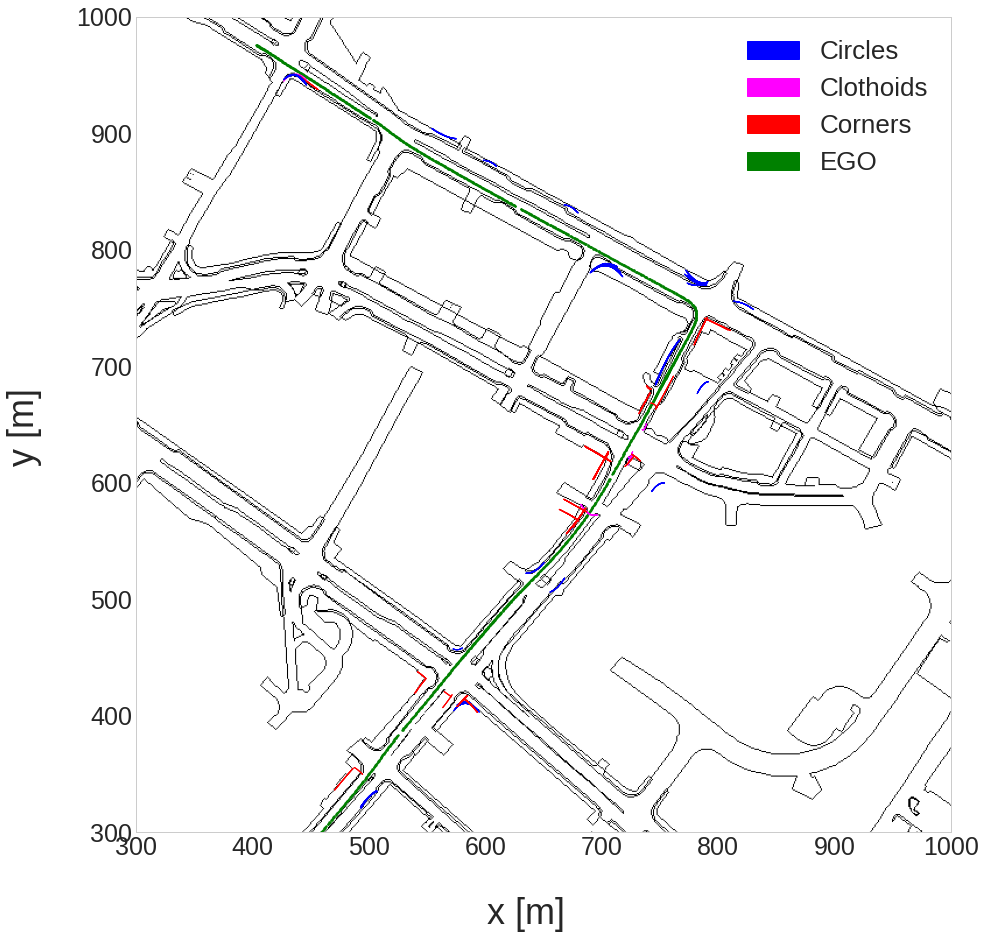

In [233]:
%load_ext autoreload
%autoreload 2
from database import NuscenesProcessedDatabase
from tqdm import tqdm
import matplotlib.pyplot as plt
data = NuscenesProcessedDatabase(scene_id=scene)
from plotting import PolynomsOnMapGraph
import matplotlib.patches as mpatches
import numpy as np
import pickle
from plotting import PolynomsOnMapGraph

def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"  
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

fig, ax = plt.subplots(1,1,figsize=(20,15),sharex=True,sharey=True)

scene = 690
data = NuscenesProcessedDatabase(scene_id=scene)

plot = PolynomsOnMapGraph()

for t in tqdm(range(0,1800)):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    (lines, circles, clothoids, corners) = classifyShape(polynoms)
    
    colors = ['magenta'] * len(polynoms)
    labels = ['polynoms'] * len(polynoms)
    lines = np.array(lines).astype(int)
    circles = np.array(circles).astype(int)
    clothoids = np.array(clothoids).astype(int)
    corners = np.array(corners).astype(int)
    #print(f"t = {t} line = {lines} colors = {colors}")

    #colors = ['magenta' if i in lines else color for i, color in enumerate(colors)]
    #labels = ['Lines' if i in lines else label for i, label in enumerate(labels)]
    colors = ['blue' if i in circles else color for i, color in enumerate(colors)]
    labels = ['Circles' if i in circles else label for i, label in enumerate(labels)]
    colors = ['magenta' if i in clothoids else color for i, color in enumerate(colors)]
    labels = ['Clothoids' if i in clothoids else label for i, label in enumerate(labels)]
    colors = ['red' if i in corners else color for i, color in enumerate(colors)]
    labels = ['Corners' if i in corners else label for i, label in enumerate(labels)]
    
    polynoms = [polynom for index, polynom in enumerate(polynoms) if index not in lines]
    colors = [color for index, color in enumerate(colors) if index not in lines]
    labels = [label for index, label in enumerate(labels) if index not in lines]
    
    print(colors, clothoids, corners, circles)
    
    print(polynoms)
            
    ax = plot.run(t, np.array(video_data['pos']), video_data["ego_path"], polynoms, nusc_map, fig, ax, xlimits=[300, 1000], ylimits=[300, 1000], colors=colors,labels=labels)
    
ax.tick_params(axis="x", labelsize=25)
ax.tick_params(axis="y", labelsize=25)
ax.tick_params(axis="x", labelsize=25)
ax.tick_params(axis="y", labelsize=25)
fig.text(0.5, 0.04, 'x [m]', ha='center', fontsize=36)
fig.text(0.14, 0.5, 'y [m]', va='center', rotation='vertical', fontsize=36)

#line_patch = mpatches.Patch(color='magenta', label='Lines')
circle_patch = mpatches.Patch(color='blue', label='Circles')
clothoid_patch = mpatches.Patch(color='magenta', label='Clothoids')
corner_patch = mpatches.Patch(color='red', label='Corners')
ego_patch = mpatches.Patch(color='green', label='EGO')
ax.legend(handles=[circle_patch, clothoid_patch, corner_patch, ego_patch], prop={'size': 26})


In [ ]:
solve_